### Find good u and fix it to see if S converges to good result...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import vampnet
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from vampnet import data_generator
import os
from tensorflow.keras.backend import get_session
from tensorflow.keras.layers import Layer
import datetime

### Specify hyperparameters

In [2]:
run_total=1
bt_run = 0

# prepare variables to save results for the 4 eigenfunction approximations for all three models
eigfunc_rev_all = np.zeros((run_total, 10000,4))
eigfunc_sym_all = np.zeros((run_total, 10000,4))
eigfunc_msm_all = np.zeros((run_total, 10000,4))

kT_prinz = 1.

prinz = data_generator.PrinzModel(dt = 0.001, kT = kT_prinz)

skip = 5
traj_len = 11 * skip
traj_num = 10000*2 # *2 for validation/training

# Estimate epochs for different training routines
epochs_cap = 1e7

nb_epoch = np.ceil(epochs_cap / (traj_len * traj_num / skip)).astype('int') + 1

epoch_chi = nb_epoch
epoch_Su = nb_epoch
epoch_all = nb_epoch * 10


# define starting distribution
base_stl = np.array([15, 70, 9, 6])
stl = np.ceil(base_stl/base_stl.sum()*traj_num/2).astype('int')

# define hyperparameters 

# number of output nodes/states
output_size = 4
# tau list for timescales estimation
tau_list = [1,2,3,4,6,8,10]
number_taus = len(tau_list)

# Tau, how much is the timeshift of the two datasets
tau = 1

# Batch size for Stochastic Gradient descent
batch_size = 5000

# Which trajectory points percentage is used as training
train_ratio = 0.5

# How many hidden layers the network has
network_depth = 6

# Width of every layer
layer_width = 100

# Learning rate used for the ADAM optimizer
learning_rate = 5e-4


nodes = [layer_width]*network_depth

# epsilon for numerical inversion of correlation matrices
epsilon = 1e-6
vamp = vampnet.VampnetTools(epsilon = epsilon)
# input size of the data
input_size = 1

### Data generation

In [3]:
short_trajs_train = np.array(
    [prinz.sample(-0.75 + 0.15 * np.random.rand(1), traj_len) for i in range(stl[0])] \
  + [prinz.sample(-0.25 + 0.15 * np.random.rand(1), traj_len) for i in range(stl[1])] \
  + [prinz.sample(0.25  + 0.15 * np.random.rand(1), traj_len) for i in range(stl[2])] \
  + [prinz.sample(0.75  + 0.15 * np.random.rand(1), traj_len) for i in range(stl[3])]
)

short_trajs_valid = np.array(
    [prinz.sample(-0.75 + 0.15 * np.random.randn(1), traj_len) for i in range(stl[0])] \
  + [prinz.sample(-0.25 + 0.15 * np.random.randn(1), traj_len) for i in range(stl[1])] \
  + [prinz.sample(0.25  + 0.15 * np.random.randn(1), traj_len) for i in range(stl[2])] \
  + [prinz.sample(0.75  + 0.15 * np.random.randn(1), traj_len) for i in range(stl[3])]
)

training_trajs = short_trajs_train[:,::skip]
validation_trajs = short_trajs_valid[:,::skip]

traj_data_train = np.concatenate([traj[:-tau] for traj in training_trajs])[:,None]
traj_data_train_lag = np.concatenate([traj[tau:] for traj in training_trajs])[:,None]

traj_data_valid = np.concatenate([traj[:-tau] for traj in validation_trajs])[:,None]
traj_data_valid_lag = np.concatenate([traj[tau:] for traj in validation_trajs])[:,None]





# Input of the first network
X1_train = traj_data_train.astype('float32')
X2_train  = traj_data_train_lag.astype('float32')

# Input for validation
X1_vali = traj_data_valid.astype('float32')
X2_vali = traj_data_valid_lag.astype('float32')

# Needs a Y-train set which we dont have.
Y_train = np.zeros((X1_train.shape[0],2*output_size)).astype('float32')
Y_vali = np.zeros((X1_vali.shape[0],2*output_size)).astype('float32')

train_mean = np.load('./train_mean.npy') #X1_train.mean(0)
train_std = np.load('./train_std.npy') #X1_train.std(0)

whiten = lambda x, m = train_mean, s = train_std : (x-m)/s

### Define helper layers for keras

In [4]:
class Vamp_matrix_u(Layer):

    def __init__(self, output_dim, acti, **kwargs):

        self.M = output_dim
        self.acti = acti

        super(Vamp_matrix_u, self).__init__(**kwargs)

    def build(self, input_shape):

        self.u_kernel = self.add_weight(name='u_var', 
                                shape=(self.M,),
                                 initializer=tf.constant_initializer(1/output_size),
                                 trainable=True)

        super(Vamp_matrix_u, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):    



        tf_chi_t, tf_chi_tau = x

        batchsize_int = tf.shape(tf_chi_t)[0]
        batchsize = tf.to_float(batchsize_int)

        tf_C0 = 1./batchsize * tf.matmul(tf_chi_tau, tf_chi_tau, transpose_a=True)
        tf_chi_mean = tf.reduce_mean(tf_chi_tau, axis=0, keepdims=True)

        tf_kernel_u = tf.expand_dims(self.acti(self.u_kernel), axis=0)

        tf_u = tf_kernel_u / tf.reduce_sum(tf_chi_mean * tf_kernel_u, keepdims=True)

        tf_v = tf.matmul(tf_C0, tf_u, transpose_b=True)

        mu = 1./batchsize * tf.matmul(tf_chi_tau, tf_u, transpose_b=True) # batchsize x 1
        Sigma =  tf.matmul(tf_chi_tau * mu, tf_chi_tau, transpose_a=True) # weighted covariance matrix

        gamma = tf_chi_tau * (tf.matmul(tf_chi_tau, tf_u, transpose_b=True))

        tf_C_00 = 1./batchsize * tf.matmul(tf_chi_t, tf_chi_t, transpose_a=True)
        tf_C_11 = 1./batchsize * tf.matmul(gamma, gamma, transpose_a=True)
        tf_C_01 = 1./batchsize * tf.matmul(tf_chi_t, gamma, transpose_a=True)

        def tile_for_keras(x):
            x_exp = tf.expand_dims(x, axis=0)
            x_shape = x.get_shape().as_list()
            ones = [1] * len(x_shape)
            stack_x = tf.tile(x_exp, [batchsize_int, *ones])
            
            return stack_x

        ret = [
            tile_for_keras(tf_u),
            tile_for_keras(tf_v),
            tile_for_keras(tf_C_00),
            tile_for_keras(tf_C_11),
            tile_for_keras(tf_C_01),
            tile_for_keras(Sigma),
            mu
        ]


        return ret

    def compute_output_shape(self, input_shape):
#         assert isinstance(input_shape, list)

        return [(self.M), (self.M), (self.M, self.M), (self.M, self.M), (self.M, self.M), (self.M, self.M), (self.M)]#[(self.M, self.M), (self.M, self.M)]



class Vamp_matrix_S(Layer):

    def __init__(self, output_dim, acti, renorm=False, **kwargs):

        self.M = output_dim
        self.acti = acti
        self.renorm = renorm

        super(Vamp_matrix_S, self).__init__(**kwargs)

    def build(self, input_shape):

        self.S_kernel = self.add_weight(name='S_var', 
                                shape=(self.M,self.M),
#                                  initializer=tf.random_normal_initializer(),
                                 initializer=tf.constant_initializer(.1),
#                                  initializer=tf.random_uniform_initializer(minval =0.,maxval=0.1),
                                 trainable=True)

        super(Vamp_matrix_S, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):    



        if len(x) == 5:

            tf_v, tf_C_00, tf_C_11, tf_C_01, Sigma = x
            batchsize_int = tf.shape(tf_v)[0]
        else:
            tf_chi_t, tf_chi_tau, tf_u, tf_v, tf_C_00, tf_C_11, tf_C_01, Sigma = x
            batchsize_int = tf.shape(tf_chi_t)[0]
            batchsize = tf.to_float(batchsize_int)
            tf_u = tf_u[0]

        tf_C_00 = tf_C_00[0]
        tf_C_11 = tf_C_11[0]
        tf_C_01 = tf_C_01[0]
        Sigma = Sigma[0]
        tf_v = tf_v[0]

        tf_kernel_w = self.acti(self.S_kernel)

        tf_W = tf_kernel_w + tf.transpose(tf_kernel_w)

        norm = tf_W @ tf_v
        if self.renorm:
            tf_W = tf_W /manu_norm(norm)

            norm = tf_W @ tf_v

        w = (1 - tf.squeeze(norm)) / tf.squeeze(tf_v)
        tf_S = tf_W + tf.diag(w)

        if len(x) == 8:

            q =  tf.transpose(tf.matmul(tf_S, tf_chi_tau, transpose_b=True)) * tf.matmul(tf_chi_tau, tf_u, transpose_b=True) / batchsize

            probs = tf.reduce_sum(tf_chi_t * q, axis=1) 

        K = tf_S @ Sigma

        VampE_matrix = tf.transpose(tf_S) @ tf_C_00 @ tf_S @ tf_C_11 - 2*tf.transpose(tf_S) @ tf_C_01
        # Has to be expanded for keras so it has a batchsize
        VampE_matrix_tile = tf.tile(tf.expand_dims(VampE_matrix, axis=0), [batchsize_int,1,1])
        K_mult = tf.tile(tf.expand_dims(K, axis=0), [batchsize_int,1,1])
        tf_S_mult = tf.tile(tf.expand_dims(tf_S, axis=0), [batchsize_int,1,1])

        if len(x) == 5:
            ret = [VampE_matrix_tile, K_mult, tf.zeros((batchsize_int, self.M)), tf_S_mult]
        else:
            ret = [VampE_matrix_tile, K_mult, probs, tf_S_mult] 

        return ret

    def compute_output_shape(self, input_shape):
#         assert isinstance(input_shape, list)

        return [(self.M, self.M), (self.M, self.M), (self.M), (self.M, self.M)]#[(self.M, self.M), (self.M, self.M)]

In [5]:
# possible activations for u and S
factor_S = 0.001 # 0.001
factor_u = .000001 # 0.0001

manu_norm = lambda x: tf.reduce_sum((x**20))**(1./20)

shifted_elu_u = lambda x: 0.1* (tf.nn.elu(x) + 1.)

shifted_elu_S = lambda x: 0.01* (tf.nn.elu(x) + 1.)

exp_tf = lambda x: tf.exp(x)

poly = lambda x: x**3

poly2 = lambda x: -x**2 + 1

ident = lambda x: factor_S* x

ident_u = lambda x: factor_u * x

# activations for reversible VAMPnets
acti_S = ident # poly
acti_u = ident_u # shifted_elu # tf.exp

#activations for revDMSM
acti_S2 = tf.exp
acti_u2 = tf.exp

# define loss functions
mlh = lambda x: - tf.reduce_sum( tf.log(y_pred), axis=0)

trace_vampe = lambda y_true, y_pred: tf.trace(y_pred[0])


def estimate_koopman_op(trajs, tau, both_corr_mat = False, force_symmetric = False):
    '''Estimates the koopman operator for a given trajectory at the lag time
        specified. The formula for the estimation is:
            K = C00 ^ -1/2 @ C01 @ C11 ^ -1/2

    Parameters
    ----------
    traj: numpy array with size [traj_timesteps, traj_dimensions]
        Trajectory described by the returned koopman operator

    tau: int
        Time shift at which the koopman operator is estimated

    Returns
    -------
    koopman_op: numpy array with shape [traj_dimensions, traj_dimensions]
        Koopman operator estimated at timeshift tau

    '''
    if tau > 0:
        if type(trajs) == list:
            traj = np.concatenate([t[:-tau] for t in trajs], axis = 0)
            traj_lag = np.concatenate([t[tau:] for t in trajs], axis = 0)
        else:
            traj = trajs[:-tau]
            traj_lag = trajs[tau:]
    else:
        traj = traj[0]
        traj_lag = traj[1]
        
        
    koopman_op = np.eye(traj.shape[1])

    c_0 = traj.T @ traj
    c_tau = traj.T @ traj_lag
    c_1 = traj_lag.T @ traj_lag

    if force_symmetric:
        c_0 += c_1
        c_1 += c_0
        c_tau += traj_lag.T @ traj

    if both_corr_mat:
        eigv0_all, eigvec0_all = np.linalg.eig(c_0)
        include0 = eigv0_all > epsilon
        eigv0_root = np.sqrt(eigv0[include0])
        eigvec0 = eigvec0[:,include0]
        c0_inv = eigvec0 @ np.diag(1/eigv0)
        c0_inv_root = eigvec0 @ np.diag(1/eigv0_root) @ eigvec0.T

        eigv1, eigvec1 = np.linalg.eig(c_1)
        include1 = eigv1 > epsilon
        eigv1_root = np.sqrt(eigv1[include1])
        eigvec1 = eigvec1[:,include1]
        c1_inv_root = eigvec1 @ np.diag(1/eigv1_root) @ eigvec1.T

        koopman_op = c0_inv_root @ c_tau @ c1_inv_root

    else:
        eigv_all, eigvec_all = np.linalg.eig(c_0)
        include = eigv_all > epsilon
        eigv = eigv_all[include]
        eigvec = eigvec_all[:,include]
        c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)


        koopman_op = c0_inv @ c_tau

    return koopman_op



def get_its(data, lags, calculate_K = True, multiple_runs = False):
    
    def get_single_its(data):

        if type(data) == list:
            outputsize = data[0].shape[1]
        else:
            outputsize = data.shape[1]

        single_its = np.zeros((outputsize-1, len(lags)))

        for t, tau_lag in enumerate(lags):
            if calculate_K:
                koopman_op = self.estimate_koopman_op(data, tau_lag)
            else:
                koopman_op = data[t]
            k_eigvals, k_eigvec = np.linalg.eig(np.real(koopman_op))
            k_eigvals = np.sort(np.absolute(k_eigvals))
            k_eigvals = k_eigvals[:-1]
            single_its[:,t] = (-tau_lag / np.log(k_eigvals))

        return np.array(single_its)


    if not multiple_runs:

        its = get_single_its(data)

    else:

        its = []
        for data_run in data:
            its.append(get_single_its(data_run))

    return its

    
def reset_weights(var):
    session = get_session()

    var.initializer.run(session=session)

### Define revVAMPnet and normal VAMPnet

In [6]:
Data_X_keras = keras.layers.Input(shape = (input_size,))
Data_Y_keras = keras.layers.Input(shape = (input_size,))

# A batch normalization layer improves convergence speed
# Instance layers and assign them to the two lobes of the network
dense_layers = [tf.keras.layers.Dense(node, activation = tf.nn.elu)
                for index_layer,node in enumerate(nodes)]

# Add a softmax output layer.
# Should be replaced with a linear activation layer if
# the outputs of the network cannot be interpreted as states

softmax = tf.keras.layers.Dense(output_size, activation='softmax')

vamp_layer_u = Vamp_matrix_u(output_size, acti_u)
vamp_layer_S = Vamp_matrix_S(output_size, acti_S, renorm=False)

vamp_layer_u_msm = Vamp_matrix_u(output_size, acti_u2)
vamp_layer_S_msm = Vamp_matrix_S(output_size, acti_S2, renorm=True)

lx_branch_keras = Data_X_keras
rx_branch_keras = Data_Y_keras

for i, layer in enumerate(dense_layers):

    lx_branch_keras = dense_layers[i](lx_branch_keras)
    rx_branch_keras = dense_layers[i](rx_branch_keras)


# Add a softmax output layer.
# Should be replaced with a linear activation layer if
# the outputs of the network cannot be interpreted as states

lx_branch_keras = softmax(lx_branch_keras)
rx_branch_keras = softmax(rx_branch_keras)
merged_chi = keras.layers.concatenate([lx_branch_keras, rx_branch_keras]) 

tf_u_all, tf_v_all, tf_C_00_all, tf_C_11_all , tf_C_01_all, Sigma_all, mu_all = vamp_layer_u([lx_branch_keras, rx_branch_keras])

VampE_matrix_all, K_all, probs_all, S_all = vamp_layer_S([lx_branch_keras, rx_branch_keras, tf_u_all, tf_v_all, tf_C_00_all, tf_C_11_all , tf_C_01_all, Sigma_all])

Data_chi_t_keras = keras.layers.Input(shape = (output_size,))
Data_chi_tau_keras = keras.layers.Input(shape = (output_size,))

tf_u_both, tf_v_both, tf_C_00_both, tf_C_11_both , tf_C_01_both, Sigma_both, _ = vamp_layer_u([Data_chi_t_keras, Data_chi_tau_keras])
VampE_matrix_both, K_both, probs_both, S_both = vamp_layer_S([Data_chi_t_keras, Data_chi_tau_keras, tf_u_both, tf_v_both, tf_C_00_both, tf_C_11_both , tf_C_01_both, Sigma_both])

Data_v_keras = keras.layers.Input(shape = (output_size, 1))
Data_C_00_keras = keras.layers.Input(shape = (output_size,output_size))
Data_C_01_keras = keras.layers.Input(shape = (output_size,output_size))
Data_C_11_keras = keras.layers.Input(shape = (output_size,output_size))
Data_Sigma_keras = keras.layers.Input(shape = (output_size,output_size))

VampE_matrix_S, K_S, _ , S_S= vamp_layer_S([Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras])

var_u = vamp_layer_u.weights
var_S = vamp_layer_S.weights

W1210 17:14:45.780567 139674274412352 deprecation.py:506] From /storage/mi/andreasmardt/anaconda3/envs/tf14/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1210 17:14:46.119570 139674274412352 deprecation.py:323] From /storage/mi/andreasmardt/anaconda3/envs/tf14/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:255: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W1210 17:14:46.219359 139674274412352 deprecation_wrapper.py:119] From /storage/mi/andreasmardt/anaconda3/envs/tf14/lib/python3.7/site-packages/tensorflow/python/autograph/converters/directives.py:117: The name tf.diag is deprecated. Pl

### Define revDMSM

In [7]:
# for the rev msm case

tf_u_all_msm, tf_v_all_msm, tf_C_00_all_msm, tf_C_11_all_msm , tf_C_01_all_msm, Sigma_all_msm, mu_all_msm = vamp_layer_u_msm([lx_branch_keras, rx_branch_keras])

VampE_matrix_all_msm, K_all_msm, probs_all_msm, S_all_msm = vamp_layer_S_msm([lx_branch_keras, rx_branch_keras, tf_u_all_msm, tf_v_all_msm, tf_C_00_all_msm, tf_C_11_all_msm , tf_C_01_all_msm, Sigma_all_msm])

tf_u_both_msm, tf_v_both_msm, tf_C_00_both_msm, tf_C_11_both_msm , tf_C_01_both_msm, Sigma_both_msm, _ = vamp_layer_u_msm([Data_chi_t_keras, Data_chi_tau_keras])
VampE_matrix_both_msm, K_both_msm, probs_both_msm, S_both_msm = vamp_layer_S_msm([Data_chi_t_keras, Data_chi_tau_keras, tf_u_both_msm, tf_v_both_msm, tf_C_00_both_msm, tf_C_11_both_msm , tf_C_01_both_msm, Sigma_both_msm])

VampE_matrix_S_msm, K_S_msm, _ , S_S_msm= vamp_layer_S_msm([Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras])

var_u_msm = vamp_layer_u_msm.weights
var_S_msm = vamp_layer_S_msm.weights

### Define actual models

In [8]:
model_chi = keras.models.Model(inputs = [Data_X_keras, Data_Y_keras], outputs = merged_chi)
model_chi.compile(keras.optimizers.Adam(learning_rate=learning_rate*.5),
                 vamp._loss_VAMP_sym,
                 metrics = [
                      vamp.metric_VAMP,
                      vamp.metric_VAMP2,])


model_mu = keras.models.Model(inputs= [Data_X_keras, Data_Y_keras], outputs=mu_all)
model_all_vampE = keras.models.Model(inputs = [Data_X_keras, Data_Y_keras], outputs = VampE_matrix_all)
model_all_vampE.compile(keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.),
                 trace_vampe,
             )
model_K_all = keras.models.Model(inputs = [Data_X_keras, Data_Y_keras], outputs = K_all)


model_both_vampE = keras.models.Model(inputs = [Data_chi_t_keras, Data_chi_tau_keras], outputs = VampE_matrix_both)
model_both_vampE.compile(keras.optimizers.Adam(learning_rate=learning_rate*1000),
                 trace_vampe,
                 )
model_K_both = keras.models.Model(inputs = [Data_chi_t_keras, Data_chi_tau_keras], outputs = K_both)

model_input_S = keras.models.Model(inputs = [Data_chi_t_keras, Data_chi_tau_keras], outputs = [tf_v_both, tf_C_00_both, tf_C_11_both , tf_C_01_both, Sigma_both])

model_S_vampE = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = VampE_matrix_S)
model_S_vampE.compile(keras.optimizers.Adam(learning_rate=learning_rate*1000, ),
                 trace_vampe,
             )
model_K_S = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = K_S)

model_S_S = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = S_S)
model_S_both = keras.models.Model(inputs =  [Data_chi_t_keras, Data_chi_tau_keras], outputs = S_both)

W1210 17:14:46.862633 139674274412352 deprecation_wrapper.py:119] From /storage/mi/andreasmardt/gitreps/deeptime/vampnet/vampnet/vampnet.py:608: The name tf.self_adjoint_eig is deprecated. Please use tf.linalg.eigh instead.

W1210 17:14:46.864973 139674274412352 deprecation.py:323] From /storage/mi/andreasmardt/gitreps/deeptime/vampnet/vampnet/vampnet.py:612: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W1210 17:14:46.885896 139674274412352 deprecation_wrapper.py:119] From /storage/mi/andreasmardt/gitreps/deeptime/vampnet/vampnet/vampnet.py:268: The name tf.svd is deprecated. Please use tf.linalg.svd instead.



In [9]:
model_mu_msm = keras.models.Model(inputs= [Data_X_keras, Data_Y_keras], outputs=mu_all_msm)
model_all_vampE_msm = keras.models.Model(inputs = [Data_X_keras, Data_Y_keras], outputs = VampE_matrix_all_msm)
model_all_vampE_msm.compile(keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.),
                 trace_vampe,
             )
model_K_all_msm = keras.models.Model(inputs = [Data_X_keras, Data_Y_keras], outputs = K_all_msm)


model_both_vampE_msm = keras.models.Model(inputs = [Data_chi_t_keras, Data_chi_tau_keras], outputs = VampE_matrix_both_msm)
model_both_vampE_msm.compile(keras.optimizers.Adam(learning_rate=learning_rate*1000),
                 trace_vampe,
                 )
model_K_both_msm = keras.models.Model(inputs = [Data_chi_t_keras, Data_chi_tau_keras], outputs = K_both_msm)

model_input_S_msm = keras.models.Model(inputs = [Data_chi_t_keras, Data_chi_tau_keras], outputs = [tf_v_both_msm, tf_C_00_both_msm, tf_C_11_both_msm , tf_C_01_both_msm, Sigma_both_msm])

model_S_vampE_msm = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = VampE_matrix_S_msm)
model_S_vampE_msm.compile(keras.optimizers.Adam(learning_rate=learning_rate*1000, ),
                 trace_vampe,
             )
model_K_S_msm = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = K_S_msm)

model_S_S_msm = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = S_S_msm)
model_S_both_msm = keras.models.Model(inputs =  [Data_chi_t_keras, Data_chi_tau_keras], outputs = S_both_msm)

### Train chi

In [10]:
def get_initializers_list(model):
    list_initializers = []
    for layer in model_chi.layers:
        if layer:
            [list_initializers.append(t) for t in layer.variables]
    return list_initializers

In [11]:
def predict(model, trajs):
    resh_traj = trajs.reshape(-1)
    pred_arr = model.predict([whiten(resh_traj), whiten(resh_traj)],batch_size=resh_traj.shape[0]).reshape(*trajs.shape, 2*output_size) [:,:,:output_size]
    pred_list = [t for t in pred_arr]
    return pred_list

### Define helper functions for building symmetrized VAMP2 model

In [12]:
def loss_VAMP2_autograd_sym(y_true, y_pred):
    '''Calculates the VAMP-2 score with respect to the network lobes. Same function
    as loss_VAMP2, but the gradient is computed automatically by tensorflow. Added
    after tensorflow 1.5 introduced gradients for eigenvalue decomposition and SVD

    Parameters
    ----------
    y_true: tensorflow tensor.
        parameter not needed for the calculation, added to comply with Keras
        rules for loss fuctions format.

    y_pred: tensorflow tensor with shape [batch_size, 2 * output_size]
        output of the two lobes of the network

    Returns
    -------
    loss_score: tensorflow tensor with shape [batch_size, 2 * output_size].
        gradient of the VAMP-2 score
    '''

    # Remove the mean from the data
    x, y, batch_size, output_size = _prep_data(y_pred) 

    # Calculate the covariance matrices
    cov_01 = 1/(batch_size - 1) * tf.matmul(x, y, transpose_b=True)
    cov_00 = 1/(batch_size - 1) * tf.matmul(x, x, transpose_b=True) 
    cov_11 = 1/(batch_size - 1) * tf.matmul(y, y, transpose_b=True)
    
    cov_00 = 1/2*(cov_00 + cov_11)
    cov_01 = 1/2*(cov_01 + tf.transpose(cov_01))
    
    # Calculate the inverse of the self-covariance matrices
    cov_00_inv = _inv(cov_00, ret_sqrt = True)
    cov_11_inv = cov_00_inv

    vamp_matrix = tf.matmul(tf.matmul(cov_00_inv, cov_01), cov_11_inv)


    vamp_score = tf.norm(vamp_matrix)

    return - tf.square(vamp_score)

def _inv(x, ret_sqrt=False):
    '''Utility function that returns the inverse of a matrix, with the
    option to return the square root of the inverse matrix.
    Parameters
    ----------
    x: numpy array with shape [m,m]
        matrix to be inverted

    ret_sqrt: bool, optional, default = False
        if True, the square root of the inverse matrix is returned instead
    Returns
    -------
    x_inv: numpy array with shape [m,m]
        inverse of the original matrix
    '''

    # Calculate eigvalues and eigvectors
    eigval_all, eigvec_all = tf.self_adjoint_eig(x)

    # Filter out eigvalues below threshold and corresponding eigvectors
    eig_th = tf.constant(epsilon, dtype=tf.float32)
    index_eig = tf.to_int32(eigval_all > eig_th)
    _, eigval = tf.dynamic_partition(eigval_all, index_eig, 2)
    _, eigvec = tf.dynamic_partition(tf.transpose(eigvec_all), index_eig, 2)

    # Build the diagonal matrix with the filtered eigenvalues or square
    # root of the filtered eigenvalues according to the parameter
    eigval_inv = tf.diag(1/eigval)
    eigval_inv_sqrt = tf.diag(tf.sqrt(1/eigval))

    cond_sqrt = tf.convert_to_tensor(ret_sqrt)

    diag = tf.cond(cond_sqrt, lambda: eigval_inv_sqrt, lambda: eigval_inv)

    # Rebuild the square root of the inverse matrix
    x_inv = tf.matmul(tf.transpose(eigvec), tf.matmul(diag, eigvec))

    return x_inv


def _prep_data(data):
    '''Utility function that transorms the input data from a tensorflow - 
    viable format to a structure used by the following functions in the
    pipeline.
    Parameters
    ----------
    data: tensorflow tensor with shape [b, 2*o]
        original format of the data
    Returns
    -------
    x: tensorflow tensor with shape [o, b]
        transposed, mean-free data corresponding to the left, lag-free lobe
        of the network

    y: tensorflow tensor with shape [o, b]
        transposed, mean-free data corresponding to the right, lagged lobe
        of the network

    b: tensorflow float32
        batch size of the data

    o: int
        output size of each lobe of the network

    '''

    shape = tf.shape(data)
    b = tf.to_float(shape[0])
    o = shape[1]//2

    # Split the data of the two networks and transpose it
    x_biased = tf.transpose(data[:,:o])
    y_biased = tf.transpose(data[:,o:])

    # Subtract the mean
    x = x_biased - tf.reduce_mean(x_biased, axis=1, keepdims=True)
    y = y_biased - tf.reduce_mean(y_biased, axis=1, keepdims=True)

    return x, y, b, o

### Train Vampnets with initilized pretrained model 

Train on 110000 samples, validate on 110000 samples
Epoch 1/300
110000/110000 [==============================] - 2s 16us/sample - loss: -2.6515 - metric_VAMP: 2.8205 - metric_VAMP2: 2.6560 - val_loss: -2.6564 - val_metric_VAMP: 2.8218 - val_metric_VAMP2: 2.6577
Epoch 2/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7109 - metric_VAMP: 2.8509 - metric_VAMP2: 2.7117 - val_loss: -2.6915 - val_metric_VAMP: 2.8399 - val_metric_VAMP2: 2.6910
Epoch 3/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7279 - metric_VAMP: 2.8582 - metric_VAMP2: 2.7254 - val_loss: -2.6998 - val_metric_VAMP: 2.8440 - val_metric_VAMP2: 2.6987
Epoch 4/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7299 - metric_VAMP: 2.8597 - metric_VAMP2: 2.7284 - val_loss: -2.7069 - val_metric_VAMP: 2.8485 - val_metric_VAMP2: 2.7071
Epoch 5/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7352 - metric_VAMP: 2.864

Epoch 40/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7512 - metric_VAMP: 2.8716 - metric_VAMP2: 2.7505 - val_loss: -2.7324 - val_metric_VAMP: 2.8621 - val_metric_VAMP2: 2.7326
Epoch 41/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7512 - metric_VAMP: 2.8725 - metric_VAMP2: 2.7522 - val_loss: -2.7323 - val_metric_VAMP: 2.8624 - val_metric_VAMP2: 2.7330
Epoch 42/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7511 - metric_VAMP: 2.8716 - metric_VAMP2: 2.7505 - val_loss: -2.7323 - val_metric_VAMP: 2.8624 - val_metric_VAMP2: 2.7330
Epoch 43/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7512 - metric_VAMP: 2.8722 - metric_VAMP2: 2.7516 - val_loss: -2.7326 - val_metric_VAMP: 2.8624 - val_metric_VAMP2: 2.7330
Epoch 44/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7512 - metric_VAMP: 2.8710 - metric_VAMP2: 2.7495 - val_loss: -2.7325 - v

110000/110000 [==============================] - 0s 2us/sample - loss: -2.7521 - metric_VAMP: 2.8729 - metric_VAMP2: 2.7531 - val_loss: -2.7328 - val_metric_VAMP: 2.8617 - val_metric_VAMP2: 2.7317
Epoch 80/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7520 - metric_VAMP: 2.8724 - metric_VAMP2: 2.7521 - val_loss: -2.7328 - val_metric_VAMP: 2.8623 - val_metric_VAMP2: 2.7329
Epoch 81/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7521 - metric_VAMP: 2.8729 - metric_VAMP2: 2.7529 - val_loss: -2.7328 - val_metric_VAMP: 2.8625 - val_metric_VAMP2: 2.7333
Epoch 82/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7521 - metric_VAMP: 2.8732 - metric_VAMP2: 2.7536 - val_loss: -2.7327 - val_metric_VAMP: 2.8621 - val_metric_VAMP2: 2.7325
Epoch 83/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7520 - metric_VAMP: 2.8723 - metric_VAMP2: 2.7520 - val_loss: -2.7327 - val_metric_VAM

Epoch 118/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7523 - metric_VAMP: 2.8727 - metric_VAMP2: 2.7526 - val_loss: -2.7328 - val_metric_VAMP: 2.8627 - val_metric_VAMP2: 2.7337
Epoch 119/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7523 - metric_VAMP: 2.8727 - metric_VAMP2: 2.7527 - val_loss: -2.7331 - val_metric_VAMP: 2.8627 - val_metric_VAMP2: 2.7336
Epoch 120/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7524 - metric_VAMP: 2.8717 - metric_VAMP2: 2.7509 - val_loss: -2.7330 - val_metric_VAMP: 2.8625 - val_metric_VAMP2: 2.7333
Epoch 121/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7523 - metric_VAMP: 2.8730 - metric_VAMP2: 2.7532 - val_loss: -2.7330 - val_metric_VAMP: 2.8632 - val_metric_VAMP2: 2.7347
Epoch 122/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7525 - metric_VAMP: 2.8735 - metric_VAMP2: 2.7541 - val_loss: -2.732

Epoch 157/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7524 - metric_VAMP: 2.8722 - metric_VAMP2: 2.7517 - val_loss: -2.7333 - val_metric_VAMP: 2.8629 - val_metric_VAMP2: 2.7341
Epoch 158/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7525 - metric_VAMP: 2.8724 - metric_VAMP2: 2.7521 - val_loss: -2.7331 - val_metric_VAMP: 2.8625 - val_metric_VAMP2: 2.7332
Epoch 159/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7525 - metric_VAMP: 2.8725 - metric_VAMP2: 2.7523 - val_loss: -2.7332 - val_metric_VAMP: 2.8629 - val_metric_VAMP2: 2.7340
Epoch 160/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7525 - metric_VAMP: 2.8715 - metric_VAMP2: 2.7503 - val_loss: -2.7335 - val_metric_VAMP: 2.8632 - val_metric_VAMP2: 2.7347
Epoch 161/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7525 - metric_VAMP: 2.8727 - metric_VAMP2: 2.7526 - val_loss: -2.733

Epoch 196/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7526 - metric_VAMP: 2.8723 - metric_VAMP2: 2.7519 - val_loss: -2.7332 - val_metric_VAMP: 2.8622 - val_metric_VAMP2: 2.7328
Epoch 197/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7528 - metric_VAMP: 2.8734 - metric_VAMP2: 2.7539 - val_loss: -2.7334 - val_metric_VAMP: 2.8623 - val_metric_VAMP2: 2.7330
Epoch 198/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7528 - metric_VAMP: 2.8729 - metric_VAMP2: 2.7531 - val_loss: -2.7334 - val_metric_VAMP: 2.8624 - val_metric_VAMP2: 2.7331
Epoch 199/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7528 - metric_VAMP: 2.8728 - metric_VAMP2: 2.7529 - val_loss: -2.7334 - val_metric_VAMP: 2.8628 - val_metric_VAMP2: 2.7338
Epoch 200/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7528 - metric_VAMP: 2.8731 - metric_VAMP2: 2.7534 - val_loss: -2.733

Epoch 235/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7530 - metric_VAMP: 2.8725 - metric_VAMP2: 2.7523 - val_loss: -2.7336 - val_metric_VAMP: 2.8628 - val_metric_VAMP2: 2.7338
Epoch 236/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7529 - metric_VAMP: 2.8728 - metric_VAMP2: 2.7529 - val_loss: -2.7334 - val_metric_VAMP: 2.8627 - val_metric_VAMP2: 2.7337
Epoch 237/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7530 - metric_VAMP: 2.8732 - metric_VAMP2: 2.7535 - val_loss: -2.7336 - val_metric_VAMP: 2.8625 - val_metric_VAMP2: 2.7333
Epoch 238/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7529 - metric_VAMP: 2.8729 - metric_VAMP2: 2.7530 - val_loss: -2.7333 - val_metric_VAMP: 2.8627 - val_metric_VAMP2: 2.7336
Epoch 239/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7528 - metric_VAMP: 2.8732 - metric_VAMP2: 2.7536 - val_loss: -2.733

Epoch 274/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7531 - metric_VAMP: 2.8729 - metric_VAMP2: 2.7530 - val_loss: -2.7338 - val_metric_VAMP: 2.8623 - val_metric_VAMP2: 2.7329
Epoch 275/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7529 - metric_VAMP: 2.8730 - metric_VAMP2: 2.7532 - val_loss: -2.7340 - val_metric_VAMP: 2.8629 - val_metric_VAMP2: 2.7341
Epoch 276/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7531 - metric_VAMP: 2.8727 - metric_VAMP2: 2.7526 - val_loss: -2.7330 - val_metric_VAMP: 2.8629 - val_metric_VAMP2: 2.7341
Epoch 277/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7529 - metric_VAMP: 2.8730 - metric_VAMP2: 2.7532 - val_loss: -2.7339 - val_metric_VAMP: 2.8633 - val_metric_VAMP2: 2.7348
Epoch 278/300
110000/110000 [==============================] - 0s 2us/sample - loss: -2.7530 - metric_VAMP: 2.8724 - metric_VAMP2: 2.7521 - val_loss: -2.734

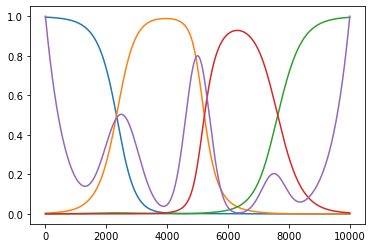

2.2657535


In [13]:
score_vamp_sym = 0
while score_vamp_sym < 0.1:
    try:

        model_chi.compile(
            keras.optimizers.Adam(learning_rate=learning_rate*0.1),
#             vamp._loss_VAMP_sym,
            vamp.loss_VAMP2_autograd,
            metrics = [
                      vamp.metric_VAMP,
                      vamp.metric_VAMP2,]
        )

        [reset_weights(v) for v in get_initializers_list(model_chi)]
        model_chi.load_weights('./working_prinz_model{}.h5'.format(bt_run))
        
        hist = model_chi.fit([whiten(X1_train), whiten(X2_train)], Y_train ,
                         batch_size = 20000,
                         epochs =300, # epoch_chi,
                         validation_data=([whiten(X1_vali), whiten(X2_vali)], Y_vali ),
                         verbose=1,
                         shuffle=True)

        pred_ord_chi = predict(model_chi, training_trajs)
        
        xax = np.linspace(-1, 1, 10000)
        pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
        for i in range(output_size):
            plt.plot(pred_xax[:,i])
        pot = data_generator.prinz_energy(xax)
        plt.plot(pot / pot.max())
        plt.show()
        
        score_vamp_sym = model_chi.evaluate([whiten(X1_vali), whiten(X2_vali)],  batch_size=batch_size, verbose = 0)[-1]
        print(score_vamp_sym)

    except tf.errors.InvalidArgumentError:
        score_vamp_sym = 0.

### Save weights to reuse as initialization of training other models

In [14]:
weights_chi = model_chi.get_weights()

### Train symVAMPnet

Train on 110000 samples, validate on 110000 samples
Epoch 1/100
110000/110000 [==============================] - 1s 13us/sample - loss: -2.7457 - loss_VAMP2_autograd_sym: -2.7457 - metric_VAMP: 2.8693 - val_loss: -2.7340 - val_loss_VAMP2_autograd_sym: -2.7340 - val_metric_VAMP: 2.8633
Epoch 2/100
110000/110000 [==============================] - 0s 4us/sample - loss: -2.7513 - loss_VAMP2_autograd_sym: -2.7513 - metric_VAMP: 2.8723 - val_loss: -2.7312 - val_loss_VAMP2_autograd_sym: -2.7312 - val_metric_VAMP: 2.8618
Epoch 3/100
110000/110000 [==============================] - 0s 3us/sample - loss: -2.7516 - loss_VAMP2_autograd_sym: -2.7516 - metric_VAMP: 2.8724 - val_loss: -2.7320 - val_loss_VAMP2_autograd_sym: -2.7320 - val_metric_VAMP: 2.8622
Epoch 4/100
110000/110000 [==============================] - 0s 3us/sample - loss: -2.7509 - loss_VAMP2_autograd_sym: -2.7509 - metric_VAMP: 2.8721 - val_loss: -2.7261 - val_loss_VAMP2_autograd_sym: -2.7261 - val_metric_VAMP: 2.8591
Epoch 5/100
110

Epoch 36/100
110000/110000 [==============================] - 0s 4us/sample - loss: -2.7523 - loss_VAMP2_autograd_sym: -2.7523 - metric_VAMP: 2.8728 - val_loss: -2.7325 - val_loss_VAMP2_autograd_sym: -2.7325 - val_metric_VAMP: 2.8624
Epoch 37/100
110000/110000 [==============================] - 0s 4us/sample - loss: -2.7525 - loss_VAMP2_autograd_sym: -2.7525 - metric_VAMP: 2.8729 - val_loss: -2.7303 - val_loss_VAMP2_autograd_sym: -2.7303 - val_metric_VAMP: 2.8612
Epoch 38/100
110000/110000 [==============================] - 0s 4us/sample - loss: -2.7506 - loss_VAMP2_autograd_sym: -2.7506 - metric_VAMP: 2.8719 - val_loss: -2.7302 - val_loss_VAMP2_autograd_sym: -2.7302 - val_metric_VAMP: 2.8613
Epoch 39/100
110000/110000 [==============================] - 0s 4us/sample - loss: -2.7514 - loss_VAMP2_autograd_sym: -2.7514 - metric_VAMP: 2.8723 - val_loss: -2.7344 - val_loss_VAMP2_autograd_sym: -2.7344 - val_metric_VAMP: 2.8634
Epoch 40/100
110000/110000 [==============================] - 0s

110000/110000 [==============================] - 0s 3us/sample - loss: -2.7525 - loss_VAMP2_autograd_sym: -2.7525 - metric_VAMP: 2.8729 - val_loss: -2.7349 - val_loss_VAMP2_autograd_sym: -2.7349 - val_metric_VAMP: 2.8637
Epoch 72/100
110000/110000 [==============================] - 0s 3us/sample - loss: -2.7520 - loss_VAMP2_autograd_sym: -2.7520 - metric_VAMP: 2.8726 - val_loss: -2.7343 - val_loss_VAMP2_autograd_sym: -2.7343 - val_metric_VAMP: 2.8634
Epoch 73/100
110000/110000 [==============================] - 0s 3us/sample - loss: -2.7522 - loss_VAMP2_autograd_sym: -2.7522 - metric_VAMP: 2.8727 - val_loss: -2.7334 - val_loss_VAMP2_autograd_sym: -2.7334 - val_metric_VAMP: 2.8629
Epoch 74/100
110000/110000 [==============================] - 0s 3us/sample - loss: -2.7517 - loss_VAMP2_autograd_sym: -2.7517 - metric_VAMP: 2.8725 - val_loss: -2.7273 - val_loss_VAMP2_autograd_sym: -2.7273 - val_metric_VAMP: 2.8596
Epoch 75/100
110000/110000 [==============================] - 0s 3us/sample -

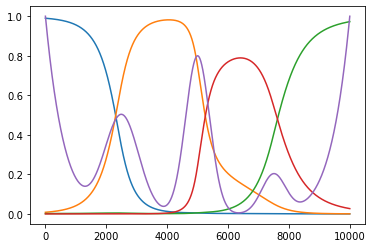

2.4929397


In [15]:
score_vamp_sym = 0


try:

    model_chi.compile(
        keras.optimizers.Adam(learning_rate=learning_rate*1),
#         vamp._loss_VAMP_sym,
#             vamp.loss_VAMP2_autograd,
         loss_VAMP2_autograd_sym,
        metrics = [
                  loss_VAMP2_autograd_sym,
                  vamp.metric_VAMP,]
    )

    [reset_weights(v) for v in get_initializers_list(model_chi)]
    model_chi.set_weights(weights_chi)

    hist = model_chi.fit([whiten(X1_train), whiten(X2_train)], Y_train ,
                     batch_size = batch_size,
                     epochs = 100, # epoch_chi,
                     validation_data=([whiten(X1_vali), whiten(X2_vali)], Y_vali ),
                     verbose=1,
                     shuffle=True)

    pred_ord_chi = predict(model_chi, training_trajs)

    xax = np.linspace(-1, 1, 10000)
    pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
    for i in range(output_size):
        plt.plot(pred_xax[:,i])
    pot = data_generator.prinz_energy(xax)
    plt.plot(pot / pot.max())
    plt.show()

    score_vamp_sym = model_chi.evaluate([whiten(X1_vali), whiten(X2_vali)],  batch_size=batch_size, verbose = 0)[-1]
    print(score_vamp_sym)


except tf.errors.InvalidArgumentError:
    score_vamp_sym = 0.


In [16]:
# model_chi.save_weights('./working_prinz_model4.h5')

### Plot $\chi$ output

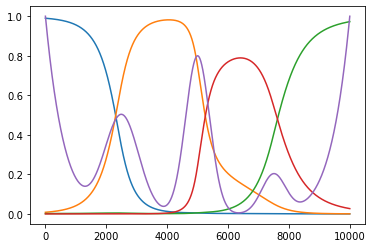

In [28]:
pred_ord_chi = pred_ord_chi = predict(model_chi, training_trajs)
        
xax = np.linspace(-1, 1, 10000)
pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
for i in range(output_size):
    plt.plot(pred_xax[:,i])
pot = data_generator.prinz_energy(xax)
plt.plot(pot / pot.max())
plt.show()

### Save weights for later analysis

In [29]:
weights_chi_sym = model_chi.get_weights()

### Get mu and implied timescales for symVAMPnet


In [19]:
K_mat_sym = estimate_koopman_op(pred_ord_chi, tau, force_symmetric = True)
C00 = np.concatenate(pred_ord_chi, axis=0).T @ np.concatenate(pred_ord_chi, axis=0)
shifted_K_sym = np.linalg.inv(C00) @ K_mat_sym.T @ C00

In [20]:
ev, ew = np.linalg.eig(shifted_K_sym)
u_vec = ew[:,np.argmin((ev-1)**2)]
mu_result_sym = np.concatenate(pred_ord_chi, axis=0) @ u_vec
mu_result_sym = mu_result_sym / mu_result_sym.sum()

In [21]:
xax = np.linspace(-1,1,10000)
prinz_en = data_generator.prinz_energy(xax)
prinz_stat = np.exp(-prinz_en/kT_prinz)
scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (xax[1]-xax[0]))

In [22]:
hist_sym, bin = np.histogram(training_trajs.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_sym)

In [23]:
# K_results_rev = np.ones((number_taus, output_size, output_size))
K_results = np.ones((len(tau_list) ,output_size, output_size))
for i, tau_i in enumerate(tau_list):
    print(tau_i)
#     K_results_rev[i]= training_for_tau_both(tau_i)
    K_results[i]  = estimate_koopman_op(pred_ord_chi, tau_i, force_symmetric = True)

1
2
3
4
6
8
10


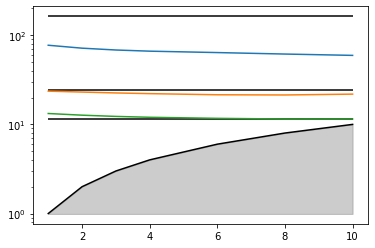

In [24]:
timescale_real_values = np.array([ 11.53593249,  24.48666445, 163.41165771])
for tsrv in timescale_real_values:
    plt.hlines(tsrv, tau_list[0], tau_list[-1])
vamp.plot_its(get_its(K_results, tau_list, False), tau_list)

In [25]:
eigvals_sym, eigvec_sym = np.linalg.eig(K_mat_sym)
sort_ind = np.argsort(eigvals_sym)[::-1]
eigvals_sym = eigvals_sym[sort_ind]
eigvec_sym = eigvec_sym[:,sort_ind]

In [26]:
data_true = np.load('./True_eigfunc_Prinz.npz')
true_eigfunc = data_true['true_eigfunc']
true_eigvals = data_true['true_eigvals']

### Plot eigenfunctions for symVAMPnet

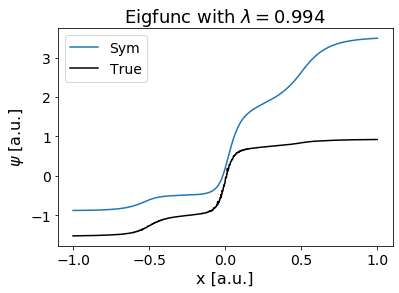

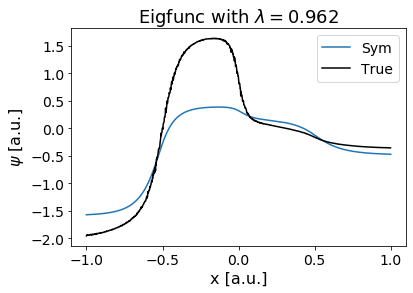

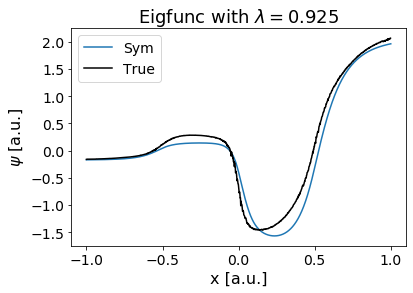

In [34]:
eigfunc_sym = pred_xax @ eigvec_sym
for i in range(1,output_size):
    plt.title('Eigfunc with $\lambda={:.3}$'.format(true_eigvals[i]), fontsize=18)
    fac = true_eigfunc[0,i] / eigfunc_sym[0,i]
    fac1 = true_eigfunc[0,i] / eigfunc_sym[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_sym[-1,i]
    fac = (fac1 + fac2)/2
    plt.plot(xax, fac*eigfunc_sym[:,i], label='Sym')
    plt.plot(xax[::10], true_eigfunc[:,i], 'k', label='True')
    plt.legend(fontsize=14)
    plt.xlabel('x [a.u.]', fontsize=16)
    plt.xticks([-1,-.5,0.,.5,1.],fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('$\psi$ [a.u.]', fontsize=16)
    plt.show()


## Training for revVAMPnet

### Initialization method

In [68]:
def estimate_u_S_with_vampnets(factor_u, factor_S):
    ''' For linear S and u, resulted in strange behaviour of S, K matrix had a lot of eigenvalues larger
    than 1...'''

    model_chi.set_weights(weights_chi)
        
    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    N = Data_chi_X.shape[0]
    
    xax = np.linspace(-1, 1, 10000)
    pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
    for i in range(output_size):
        plt.plot(pred_xax[:,i])
    pot = data_generator.prinz_energy(xax)
    plt.plot(pot / pot.max())
    plt.show()
    
    c_0 = 1/N*Data_chi_X.T @ Data_chi_X
    c_tau = 1/N*Data_chi_X.T @ Data_chi_Y
    c_1 = 1/N*Data_chi_Y.T @ Data_chi_Y
    
    
    eigv_all, eigvec_all = np.linalg.eigh(c_0)
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
        
    K_vamp = c0_inv @ c_tau
    
    # estimate pi
    eigv, eigvec = np.linalg.eig(K_vamp.T)
    ind_pi = np.argmin((eigv-1)**2)
    
    pi_vec = eigvec[:,ind_pi]
#     print(eigv, ind_pi, pi_vec, eigvec)
    pi = pi_vec / np.sum(pi_vec, keepdims=True)
    print('Stationary vector is {}'.format(pi))
    
    model_chi.set_weights(weights_chi)
    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    N = Data_chi_X.shape[0]

    
    c_0 = 1/N*Data_chi_X.T @ Data_chi_X
    eigv_all, eigvec_all = np.linalg.eigh(c_0)
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
    
    c_tau = 1/N*Data_chi_X.T @ Data_chi_Y
#     K_vamp = c0_inv @ c_tau
    
    u_guess = c0_inv @ pi
    u_kernel = u_guess / factor_u
    
    print('Estimated u is: {} '.format(u_guess))

    
    # get Sigma, invert it to get proxy S
    vamp_layer_u.set_weights([u_kernel])
    model_chi.set_weights(weights_chi)
    mu_result_rev = model_mu.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
    prinz_en = data_generator.prinz_energy(bin[:-1])
    prinz_stat = np.exp(-prinz_en/kT_prinz)
    scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
    plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
    plt.plot(bin[:-1], hist_rev, label = 'Rev')
    plt.plot(bin[:-1], hist_sym, label = 'Sym')
    plt.legend()
    plt.show()

    rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
    sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
    tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
    plt.plot(np.abs(rev_states_prob - tru_states_prob), label = "Rev")
    plt.plot(np.abs(sym_states_prob - tru_states_prob), label = "Sym")
    plt.legend()
    plt.show()
    print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))
    
    v_input, C_00_input, C_11_input, C_01_input, Sigma_input = model_input_S.predict([Data_chi_X, Data_chi_Y], batch_size=Data_chi_X.shape[0])
    
    eigv_all, eigvec_all = np.linalg.eigh(Sigma_input[0])
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    sigma_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
    
#     print(K_vamp, np.linalg.eigvals(K_vamp))
    S_nonrev = K_vamp @ sigma_inv
    
    S_rev_add = 1/2 * (S_nonrev + S_nonrev.T)
#     print(S_rev_add @ Sigma_input[0])
    
    kernel_S = S_nonrev / 2. / factor_S
    
    vamp_layer_S.set_weights([kernel_S])
    
    K_result = model_K_all.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
#     print(K_result[0])

#     print(np.linalg.eigvals(K_result[0]))
    
    return u_kernel, kernel_S

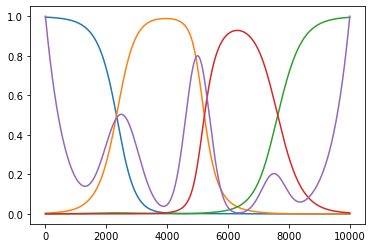

Stationary vector is [0.03133573 0.09906208 0.3895086  0.48009363]
Estimated u is: [0.21654446 0.04775097 5.9557323  4.653107  ] 


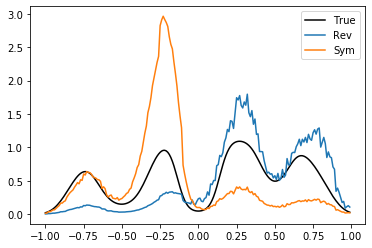

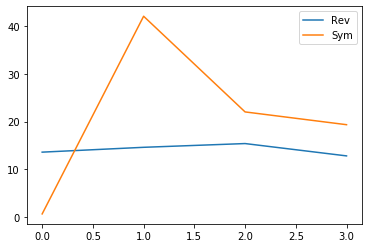

Error of rev: 5.067384625416882, of sym: 8.929578208487277


In [69]:
u_init, S_init = estimate_u_S_with_vampnets(factor_u, factor_S)

### Train for S and u with full batch

In [39]:
np_epoch_S = 10000
patience = 100
vamp_layer_u.trainable = True
vamp_layer_S.trainable = True
Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
Data_chi_X = Data_chi[:,:output_size]
Data_chi_Y = Data_chi[:,output_size:]
Data_chi_vali = model_chi.predict([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])
Data_chi_X_vali = Data_chi_vali[:,:output_size]
Data_chi_Y_vali = Data_chi_vali[:,output_size:]


model_both_vampE.compile(keras.optimizers.Adam(learning_rate=learning_rate*10000, clipnorm=1.),
             trace_vampe,
         )

callbacks = [EarlyStopping('val_loss', patience=patience, mode='min', restore_best_weights=True),
#              EarlyStoppingByLossVal('val_loss', value=-3.70)
        ]
hist = model_both_vampE.fit([Data_chi_X, Data_chi_Y], Y_train ,
                 batch_size=Data_chi_X.shape[0],
                 epochs = np_epoch_S,
                 validation_data=([Data_chi_X_vali, Data_chi_Y_vali], Y_vali ),
                 verbose=1,
                 callbacks=callbacks,
                 shuffle=True)

W1210 17:32:23.887862 139674274412352 deprecation.py:323] From /storage/mi/andreasmardt/anaconda3/envs/tf14/lib/python3.7/site-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 110000 samples, validate on 110000 samples
Epoch 1/10000
110000/110000 [==============================] - 1s 7us/sample - loss: -1.5950 - val_loss: -1.4182
Epoch 2/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -1.6227 - val_loss: -1.4448
Epoch 3/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -1.6498 - val_loss: -1.4709
Epoch 4/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -1.6762 - val_loss: -1.4966
Epoch 5/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -1.7020 - val_loss: -1.5219
Epoch 6/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -1.7272 - val_loss: -1.5465
Epoch 7/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -1.7517 - val_loss: -1.5707
Epoch 8/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -1.7755 - val_loss: -1.5942
Epoch 9/10000
110000/110000 [===============

Epoch 73/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.3626 - val_loss: -2.2165
Epoch 74/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.3654 - val_loss: -2.2191
Epoch 75/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.3681 - val_loss: -2.2217
Epoch 76/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.3708 - val_loss: -2.2242
Epoch 77/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.3733 - val_loss: -2.2267
Epoch 78/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.3758 - val_loss: -2.2290
Epoch 79/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.3783 - val_loss: -2.2314
Epoch 80/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.3806 - val_loss: -2.2336
Epoch 81/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2

Epoch 145/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4543 - val_loss: -2.3156
Epoch 146/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4548 - val_loss: -2.3163
Epoch 147/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4554 - val_loss: -2.3170
Epoch 148/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4559 - val_loss: -2.3177
Epoch 149/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4564 - val_loss: -2.3184
Epoch 150/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4569 - val_loss: -2.3191
Epoch 151/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4574 - val_loss: -2.3197
Epoch 152/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4579 - val_loss: -2.3204
Epoch 153/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 217/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4841 - val_loss: -2.3547
Epoch 218/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4844 - val_loss: -2.3551
Epoch 219/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4847 - val_loss: -2.3556
Epoch 220/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4851 - val_loss: -2.3560
Epoch 221/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4854 - val_loss: -2.3564
Epoch 222/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4857 - val_loss: -2.3569
Epoch 223/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4861 - val_loss: -2.3573
Epoch 224/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.4864 - val_loss: -2.3577
Epoch 225/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 289/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5048 - val_loss: -2.3818
Epoch 290/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5051 - val_loss: -2.3821
Epoch 291/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5053 - val_loss: -2.3824
Epoch 292/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5055 - val_loss: -2.3827
Epoch 293/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5058 - val_loss: -2.3830
Epoch 294/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5060 - val_loss: -2.3834
Epoch 295/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5063 - val_loss: -2.3837
Epoch 296/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5065 - val_loss: -2.3840
Epoch 297/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 361/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5197 - val_loss: -2.4015
Epoch 362/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5199 - val_loss: -2.4017
Epoch 363/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5200 - val_loss: -2.4019
Epoch 364/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5202 - val_loss: -2.4021
Epoch 365/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5204 - val_loss: -2.4024
Epoch 366/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5205 - val_loss: -2.4026
Epoch 367/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5207 - val_loss: -2.4028
Epoch 368/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5209 - val_loss: -2.4031
Epoch 369/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 433/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5304 - val_loss: -2.4157
Epoch 434/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5305 - val_loss: -2.4159
Epoch 435/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5306 - val_loss: -2.4161
Epoch 436/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5308 - val_loss: -2.4162
Epoch 437/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5309 - val_loss: -2.4164
Epoch 438/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5310 - val_loss: -2.4166
Epoch 439/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5311 - val_loss: -2.4167
Epoch 440/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5313 - val_loss: -2.4169
Epoch 441/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 505/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5383 - val_loss: -2.4262
Epoch 506/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5384 - val_loss: -2.4264
Epoch 507/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5385 - val_loss: -2.4265
Epoch 508/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5386 - val_loss: -2.4266
Epoch 509/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5387 - val_loss: -2.4267
Epoch 510/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5388 - val_loss: -2.4269
Epoch 511/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5389 - val_loss: -2.4270
Epoch 512/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5390 - val_loss: -2.4271
Epoch 513/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 577/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5446 - val_loss: -2.4342
Epoch 578/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5446 - val_loss: -2.4343
Epoch 579/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5447 - val_loss: -2.4344
Epoch 580/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5448 - val_loss: -2.4345
Epoch 581/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5449 - val_loss: -2.4346
Epoch 582/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5450 - val_loss: -2.4347
Epoch 583/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5450 - val_loss: -2.4348
Epoch 584/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5451 - val_loss: -2.4349
Epoch 585/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 649/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5498 - val_loss: -2.4406
Epoch 650/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5499 - val_loss: -2.4407
Epoch 651/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5500 - val_loss: -2.4408
Epoch 652/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5500 - val_loss: -2.4409
Epoch 653/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5501 - val_loss: -2.4409
Epoch 654/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5502 - val_loss: -2.4410
Epoch 655/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5502 - val_loss: -2.4411
Epoch 656/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5503 - val_loss: -2.4412
Epoch 657/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 721/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5546 - val_loss: -2.4460
Epoch 722/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5547 - val_loss: -2.4461
Epoch 723/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5547 - val_loss: -2.4462
Epoch 724/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5548 - val_loss: -2.4462
Epoch 725/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5549 - val_loss: -2.4463
Epoch 726/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5549 - val_loss: -2.4464
Epoch 727/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5550 - val_loss: -2.4464
Epoch 728/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5551 - val_loss: -2.4465
Epoch 729/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 793/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5591 - val_loss: -2.4508
Epoch 794/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5592 - val_loss: -2.4509
Epoch 795/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5593 - val_loss: -2.4509
Epoch 796/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5593 - val_loss: -2.4510
Epoch 797/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5594 - val_loss: -2.4511
Epoch 798/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5595 - val_loss: -2.4511
Epoch 799/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5595 - val_loss: -2.4512
Epoch 800/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5596 - val_loss: -2.4513
Epoch 801/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 865/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5636 - val_loss: -2.4553
Epoch 866/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5636 - val_loss: -2.4553
Epoch 867/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5637 - val_loss: -2.4554
Epoch 868/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5638 - val_loss: -2.4555
Epoch 869/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5638 - val_loss: -2.4555
Epoch 870/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5639 - val_loss: -2.4556
Epoch 871/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5639 - val_loss: -2.4556
Epoch 872/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5640 - val_loss: -2.4557
Epoch 873/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 937/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5680 - val_loss: -2.4595
Epoch 938/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5680 - val_loss: -2.4596
Epoch 939/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5681 - val_loss: -2.4596
Epoch 940/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5682 - val_loss: -2.4597
Epoch 941/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5682 - val_loss: -2.4597
Epoch 942/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5683 - val_loss: -2.4598
Epoch 943/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5683 - val_loss: -2.4599
Epoch 944/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5684 - val_loss: -2.4599
Epoch 945/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 1009/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5724 - val_loss: -2.4636
Epoch 1010/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5724 - val_loss: -2.4637
Epoch 1011/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5725 - val_loss: -2.4637
Epoch 1012/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5726 - val_loss: -2.4638
Epoch 1013/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5726 - val_loss: -2.4639
Epoch 1014/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5727 - val_loss: -2.4639
Epoch 1015/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5727 - val_loss: -2.4640
Epoch 1016/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5728 - val_loss: -2.4640
Epoch 1017/10000
110000/110000 [==============================] - 0s 1us

Epoch 1080/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5767 - val_loss: -2.4676
Epoch 1081/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5768 - val_loss: -2.4677
Epoch 1082/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5768 - val_loss: -2.4677
Epoch 1083/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5769 - val_loss: -2.4678
Epoch 1084/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5769 - val_loss: -2.4678
Epoch 1085/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5770 - val_loss: -2.4679
Epoch 1086/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5771 - val_loss: -2.4680
Epoch 1087/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5771 - val_loss: -2.4680
Epoch 1088/10000
110000/110000 [==============================] - 0s 1us

Epoch 1151/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5810 - val_loss: -2.4716
Epoch 1152/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5811 - val_loss: -2.4716
Epoch 1153/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5812 - val_loss: -2.4717
Epoch 1154/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5812 - val_loss: -2.4717
Epoch 1155/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5813 - val_loss: -2.4718
Epoch 1156/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5813 - val_loss: -2.4718
Epoch 1157/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5814 - val_loss: -2.4719
Epoch 1158/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5815 - val_loss: -2.4720
Epoch 1159/10000
110000/110000 [==============================] - 0s 1us

Epoch 1222/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5854 - val_loss: -2.4755
Epoch 1223/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5854 - val_loss: -2.4755
Epoch 1224/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5855 - val_loss: -2.4756
Epoch 1225/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5855 - val_loss: -2.4757
Epoch 1226/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5856 - val_loss: -2.4757
Epoch 1227/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5857 - val_loss: -2.4758
Epoch 1228/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5857 - val_loss: -2.4758
Epoch 1229/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5858 - val_loss: -2.4759
Epoch 1230/10000
110000/110000 [==============================] - 0s 1us

Epoch 1293/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5897 - val_loss: -2.4794
Epoch 1294/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5897 - val_loss: -2.4795
Epoch 1295/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5898 - val_loss: -2.4795
Epoch 1296/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5899 - val_loss: -2.4796
Epoch 1297/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5899 - val_loss: -2.4796
Epoch 1298/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5900 - val_loss: -2.4797
Epoch 1299/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5900 - val_loss: -2.4797
Epoch 1300/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5901 - val_loss: -2.4798
Epoch 1301/10000
110000/110000 [==============================] - 0s 1us

Epoch 1364/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5940 - val_loss: -2.4833
Epoch 1365/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5941 - val_loss: -2.4833
Epoch 1366/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5941 - val_loss: -2.4834
Epoch 1367/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5942 - val_loss: -2.4835
Epoch 1368/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5942 - val_loss: -2.4835
Epoch 1369/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5943 - val_loss: -2.4836
Epoch 1370/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5944 - val_loss: -2.4836
Epoch 1371/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5944 - val_loss: -2.4837
Epoch 1372/10000
110000/110000 [==============================] - 0s 1us

Epoch 1435/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5983 - val_loss: -2.4872
Epoch 1436/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5984 - val_loss: -2.4872
Epoch 1437/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5984 - val_loss: -2.4873
Epoch 1438/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5985 - val_loss: -2.4873
Epoch 1439/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5985 - val_loss: -2.4874
Epoch 1440/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5986 - val_loss: -2.4875
Epoch 1441/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5987 - val_loss: -2.4875
Epoch 1442/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.5987 - val_loss: -2.4876
Epoch 1443/10000
110000/110000 [==============================] - 0s 1us

Epoch 1506/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6026 - val_loss: -2.4911
Epoch 1507/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6027 - val_loss: -2.4911
Epoch 1508/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6027 - val_loss: -2.4912
Epoch 1509/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6028 - val_loss: -2.4912
Epoch 1510/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6028 - val_loss: -2.4913
Epoch 1511/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6029 - val_loss: -2.4913
Epoch 1512/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6030 - val_loss: -2.4914
Epoch 1513/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6030 - val_loss: -2.4914
Epoch 1514/10000
110000/110000 [==============================] - 0s 1us

Epoch 1577/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6069 - val_loss: -2.4949
Epoch 1578/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6069 - val_loss: -2.4950
Epoch 1579/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6070 - val_loss: -2.4951
Epoch 1580/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6071 - val_loss: -2.4951
Epoch 1581/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6071 - val_loss: -2.4952
Epoch 1582/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6072 - val_loss: -2.4952
Epoch 1583/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6072 - val_loss: -2.4953
Epoch 1584/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6073 - val_loss: -2.4953
Epoch 1585/10000
110000/110000 [==============================] - 0s 1us

Epoch 1648/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6112 - val_loss: -2.4988
Epoch 1649/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6112 - val_loss: -2.4989
Epoch 1650/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6113 - val_loss: -2.4989
Epoch 1651/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6113 - val_loss: -2.4990
Epoch 1652/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6114 - val_loss: -2.4990
Epoch 1653/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6115 - val_loss: -2.4991
Epoch 1654/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6115 - val_loss: -2.4991
Epoch 1655/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6116 - val_loss: -2.4992
Epoch 1656/10000
110000/110000 [==============================] - 0s 1us

Epoch 1719/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6154 - val_loss: -2.5027
Epoch 1720/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6155 - val_loss: -2.5027
Epoch 1721/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6155 - val_loss: -2.5028
Epoch 1722/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6156 - val_loss: -2.5028
Epoch 1723/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6157 - val_loss: -2.5029
Epoch 1724/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6157 - val_loss: -2.5029
Epoch 1725/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6158 - val_loss: -2.5030
Epoch 1726/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6158 - val_loss: -2.5031
Epoch 1727/10000
110000/110000 [==============================] - 0s 1us

Epoch 1790/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6197 - val_loss: -2.5065
Epoch 1791/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6197 - val_loss: -2.5066
Epoch 1792/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6198 - val_loss: -2.5066
Epoch 1793/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6198 - val_loss: -2.5067
Epoch 1794/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6199 - val_loss: -2.5067
Epoch 1795/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6200 - val_loss: -2.5068
Epoch 1796/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6200 - val_loss: -2.5068
Epoch 1797/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6201 - val_loss: -2.5069
Epoch 1798/10000
110000/110000 [==============================] - 0s 1us

Epoch 1861/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6239 - val_loss: -2.5104
Epoch 1862/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6239 - val_loss: -2.5104
Epoch 1863/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6240 - val_loss: -2.5105
Epoch 1864/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6241 - val_loss: -2.5105
Epoch 1865/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6241 - val_loss: -2.5106
Epoch 1866/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6242 - val_loss: -2.5106
Epoch 1867/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6242 - val_loss: -2.5107
Epoch 1868/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6243 - val_loss: -2.5107
Epoch 1869/10000
110000/110000 [==============================] - 0s 1us

Epoch 1932/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6281 - val_loss: -2.5142
Epoch 1933/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6282 - val_loss: -2.5143
Epoch 1934/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6282 - val_loss: -2.5143
Epoch 1935/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6283 - val_loss: -2.5144
Epoch 1936/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6283 - val_loss: -2.5144
Epoch 1937/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6284 - val_loss: -2.5145
Epoch 1938/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6285 - val_loss: -2.5145
Epoch 1939/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6285 - val_loss: -2.5146
Epoch 1940/10000
110000/110000 [==============================] - 0s 1us

Epoch 2003/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6323 - val_loss: -2.5180
Epoch 2004/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6324 - val_loss: -2.5181
Epoch 2005/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6324 - val_loss: -2.5181
Epoch 2006/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6325 - val_loss: -2.5182
Epoch 2007/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6325 - val_loss: -2.5182
Epoch 2008/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6326 - val_loss: -2.5183
Epoch 2009/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6327 - val_loss: -2.5183
Epoch 2010/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6327 - val_loss: -2.5184
Epoch 2011/10000
110000/110000 [==============================] - 0s 1us

Epoch 2074/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6365 - val_loss: -2.5218
Epoch 2075/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6365 - val_loss: -2.5219
Epoch 2076/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6366 - val_loss: -2.5219
Epoch 2077/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6367 - val_loss: -2.5220
Epoch 2078/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6367 - val_loss: -2.5220
Epoch 2079/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6368 - val_loss: -2.5221
Epoch 2080/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6368 - val_loss: -2.5222
Epoch 2081/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6369 - val_loss: -2.5222
Epoch 2082/10000
110000/110000 [==============================] - 0s 1us

Epoch 2145/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6407 - val_loss: -2.5256
Epoch 2146/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6407 - val_loss: -2.5257
Epoch 2147/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6408 - val_loss: -2.5257
Epoch 2148/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6408 - val_loss: -2.5258
Epoch 2149/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6409 - val_loss: -2.5258
Epoch 2150/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6409 - val_loss: -2.5259
Epoch 2151/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6410 - val_loss: -2.5260
Epoch 2152/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6411 - val_loss: -2.5260
Epoch 2153/10000
110000/110000 [==============================] - 0s 1us

Epoch 2216/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6448 - val_loss: -2.5294
Epoch 2217/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6449 - val_loss: -2.5295
Epoch 2218/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6449 - val_loss: -2.5295
Epoch 2219/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6450 - val_loss: -2.5296
Epoch 2220/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6450 - val_loss: -2.5296
Epoch 2221/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6451 - val_loss: -2.5297
Epoch 2222/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6452 - val_loss: -2.5297
Epoch 2223/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6452 - val_loss: -2.5298
Epoch 2224/10000
110000/110000 [==============================] - 0s 1us

Epoch 2287/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6489 - val_loss: -2.5332
Epoch 2288/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6490 - val_loss: -2.5333
Epoch 2289/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6490 - val_loss: -2.5333
Epoch 2290/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6491 - val_loss: -2.5334
Epoch 2291/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6492 - val_loss: -2.5334
Epoch 2292/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6492 - val_loss: -2.5335
Epoch 2293/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6493 - val_loss: -2.5335
Epoch 2294/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6493 - val_loss: -2.5336
Epoch 2295/10000
110000/110000 [==============================] - 0s 1us

Epoch 2358/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6530 - val_loss: -2.5370
Epoch 2359/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6531 - val_loss: -2.5370
Epoch 2360/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6532 - val_loss: -2.5371
Epoch 2361/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6532 - val_loss: -2.5371
Epoch 2362/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6533 - val_loss: -2.5372
Epoch 2363/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6533 - val_loss: -2.5372
Epoch 2364/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6534 - val_loss: -2.5373
Epoch 2365/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6535 - val_loss: -2.5373
Epoch 2366/10000
110000/110000 [==============================] - 0s 1us

Epoch 2429/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6571 - val_loss: -2.5407
Epoch 2430/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6572 - val_loss: -2.5408
Epoch 2431/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6573 - val_loss: -2.5408
Epoch 2432/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6573 - val_loss: -2.5409
Epoch 2433/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6574 - val_loss: -2.5409
Epoch 2434/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6574 - val_loss: -2.5410
Epoch 2435/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6575 - val_loss: -2.5410
Epoch 2436/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6575 - val_loss: -2.5411
Epoch 2437/10000
110000/110000 [==============================] - 0s 1us

Epoch 2500/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6612 - val_loss: -2.5445
Epoch 2501/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6613 - val_loss: -2.5445
Epoch 2502/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6613 - val_loss: -2.5446
Epoch 2503/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6614 - val_loss: -2.5446
Epoch 2504/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6615 - val_loss: -2.5447
Epoch 2505/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6615 - val_loss: -2.5447
Epoch 2506/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6616 - val_loss: -2.5448
Epoch 2507/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6616 - val_loss: -2.5448
Epoch 2508/10000
110000/110000 [==============================] - 0s 1us

Epoch 2571/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6653 - val_loss: -2.5482
Epoch 2572/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6653 - val_loss: -2.5482
Epoch 2573/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6654 - val_loss: -2.5483
Epoch 2574/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6655 - val_loss: -2.5483
Epoch 2575/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6655 - val_loss: -2.5484
Epoch 2576/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6656 - val_loss: -2.5485
Epoch 2577/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6656 - val_loss: -2.5485
Epoch 2578/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6657 - val_loss: -2.5486
Epoch 2579/10000
110000/110000 [==============================] - 0s 1us

Epoch 2642/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6693 - val_loss: -2.5519
Epoch 2643/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6694 - val_loss: -2.5520
Epoch 2644/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6694 - val_loss: -2.5520
Epoch 2645/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6695 - val_loss: -2.5521
Epoch 2646/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6696 - val_loss: -2.5521
Epoch 2647/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6696 - val_loss: -2.5522
Epoch 2648/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6697 - val_loss: -2.5522
Epoch 2649/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6697 - val_loss: -2.5523
Epoch 2650/10000
110000/110000 [==============================] - 0s 1us

Epoch 2713/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6734 - val_loss: -2.5556
Epoch 2714/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6734 - val_loss: -2.5557
Epoch 2715/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6735 - val_loss: -2.5557
Epoch 2716/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6735 - val_loss: -2.5558
Epoch 2717/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6736 - val_loss: -2.5558
Epoch 2718/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6736 - val_loss: -2.5559
Epoch 2719/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6737 - val_loss: -2.5559
Epoch 2720/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6738 - val_loss: -2.5560
Epoch 2721/10000
110000/110000 [==============================] - 0s 1us

Epoch 2784/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6774 - val_loss: -2.5593
Epoch 2785/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6774 - val_loss: -2.5593
Epoch 2786/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6775 - val_loss: -2.5594
Epoch 2787/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6775 - val_loss: -2.5594
Epoch 2788/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6776 - val_loss: -2.5595
Epoch 2789/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6776 - val_loss: -2.5595
Epoch 2790/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6777 - val_loss: -2.5596
Epoch 2791/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6778 - val_loss: -2.5596
Epoch 2792/10000
110000/110000 [==============================] - 0s 1us

Epoch 2855/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6814 - val_loss: -2.5630
Epoch 2856/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6814 - val_loss: -2.5630
Epoch 2857/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6815 - val_loss: -2.5631
Epoch 2858/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6815 - val_loss: -2.5631
Epoch 2859/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6816 - val_loss: -2.5632
Epoch 2860/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6816 - val_loss: -2.5632
Epoch 2861/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6817 - val_loss: -2.5633
Epoch 2862/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6817 - val_loss: -2.5633
Epoch 2863/10000
110000/110000 [==============================] - 0s 1us

Epoch 2926/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6853 - val_loss: -2.5666
Epoch 2927/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6854 - val_loss: -2.5667
Epoch 2928/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6854 - val_loss: -2.5667
Epoch 2929/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6855 - val_loss: -2.5668
Epoch 2930/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6855 - val_loss: -2.5668
Epoch 2931/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6856 - val_loss: -2.5669
Epoch 2932/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6857 - val_loss: -2.5670
Epoch 2933/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6857 - val_loss: -2.5670
Epoch 2934/10000
110000/110000 [==============================] - 0s 1us

Epoch 2997/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6893 - val_loss: -2.5703
Epoch 2998/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6893 - val_loss: -2.5703
Epoch 2999/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6894 - val_loss: -2.5704
Epoch 3000/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6894 - val_loss: -2.5704
Epoch 3001/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6895 - val_loss: -2.5705
Epoch 3002/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6896 - val_loss: -2.5705
Epoch 3003/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6896 - val_loss: -2.5706
Epoch 3004/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6897 - val_loss: -2.5706
Epoch 3005/10000
110000/110000 [==============================] - 0s 1us

Epoch 3068/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6932 - val_loss: -2.5739
Epoch 3069/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6933 - val_loss: -2.5740
Epoch 3070/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6933 - val_loss: -2.5740
Epoch 3071/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6934 - val_loss: -2.5741
Epoch 3072/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6934 - val_loss: -2.5741
Epoch 3073/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6935 - val_loss: -2.5742
Epoch 3074/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6935 - val_loss: -2.5743
Epoch 3075/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6936 - val_loss: -2.5743
Epoch 3076/10000
110000/110000 [==============================] - 0s 1us

Epoch 3139/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6971 - val_loss: -2.5776
Epoch 3140/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6972 - val_loss: -2.5776
Epoch 3141/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6972 - val_loss: -2.5777
Epoch 3142/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6973 - val_loss: -2.5777
Epoch 3143/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6974 - val_loss: -2.5778
Epoch 3144/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6974 - val_loss: -2.5778
Epoch 3145/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6975 - val_loss: -2.5779
Epoch 3146/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.6975 - val_loss: -2.5779
Epoch 3147/10000
110000/110000 [==============================] - 0s 1us

Epoch 3210/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7010 - val_loss: -2.5812
Epoch 3211/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7011 - val_loss: -2.5812
Epoch 3212/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7011 - val_loss: -2.5813
Epoch 3213/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7012 - val_loss: -2.5813
Epoch 3214/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7013 - val_loss: -2.5814
Epoch 3215/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7013 - val_loss: -2.5814
Epoch 3216/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7014 - val_loss: -2.5815
Epoch 3217/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7014 - val_loss: -2.5815
Epoch 3218/10000
110000/110000 [==============================] - 0s 1us

Epoch 3281/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7049 - val_loss: -2.5848
Epoch 3282/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7050 - val_loss: -2.5848
Epoch 3283/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7050 - val_loss: -2.5849
Epoch 3284/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7051 - val_loss: -2.5849
Epoch 3285/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7051 - val_loss: -2.5850
Epoch 3286/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7052 - val_loss: -2.5850
Epoch 3287/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7052 - val_loss: -2.5851
Epoch 3288/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7053 - val_loss: -2.5851
Epoch 3289/10000
110000/110000 [==============================] - 0s 1us

Epoch 3352/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7088 - val_loss: -2.5884
Epoch 3353/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7088 - val_loss: -2.5884
Epoch 3354/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7089 - val_loss: -2.5885
Epoch 3355/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7089 - val_loss: -2.5885
Epoch 3356/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7090 - val_loss: -2.5886
Epoch 3357/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7091 - val_loss: -2.5886
Epoch 3358/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7091 - val_loss: -2.5887
Epoch 3359/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7092 - val_loss: -2.5887
Epoch 3360/10000
110000/110000 [==============================] - 0s 1us

Epoch 3423/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7126 - val_loss: -2.5919
Epoch 3424/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7127 - val_loss: -2.5920
Epoch 3425/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7127 - val_loss: -2.5920
Epoch 3426/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7128 - val_loss: -2.5921
Epoch 3427/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7129 - val_loss: -2.5921
Epoch 3428/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7129 - val_loss: -2.5922
Epoch 3429/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7130 - val_loss: -2.5922
Epoch 3430/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7130 - val_loss: -2.5923
Epoch 3431/10000
110000/110000 [==============================] - 0s 1us

Epoch 3494/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7165 - val_loss: -2.5955
Epoch 3495/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7165 - val_loss: -2.5955
Epoch 3496/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7166 - val_loss: -2.5956
Epoch 3497/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7166 - val_loss: -2.5956
Epoch 3498/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7167 - val_loss: -2.5957
Epoch 3499/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7167 - val_loss: -2.5957
Epoch 3500/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7168 - val_loss: -2.5958
Epoch 3501/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7168 - val_loss: -2.5958
Epoch 3502/10000
110000/110000 [==============================] - 0s 1us

Epoch 3565/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7203 - val_loss: -2.5990
Epoch 3566/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7203 - val_loss: -2.5991
Epoch 3567/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7204 - val_loss: -2.5991
Epoch 3568/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7204 - val_loss: -2.5992
Epoch 3569/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7205 - val_loss: -2.5992
Epoch 3570/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7205 - val_loss: -2.5993
Epoch 3571/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7206 - val_loss: -2.5993
Epoch 3572/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7207 - val_loss: -2.5994
Epoch 3573/10000
110000/110000 [==============================] - 0s 1us

Epoch 3636/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7241 - val_loss: -2.6026
Epoch 3637/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7241 - val_loss: -2.6026
Epoch 3638/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7242 - val_loss: -2.6027
Epoch 3639/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7242 - val_loss: -2.6027
Epoch 3640/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7243 - val_loss: -2.6028
Epoch 3641/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7243 - val_loss: -2.6028
Epoch 3642/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7244 - val_loss: -2.6029
Epoch 3643/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7244 - val_loss: -2.6029
Epoch 3644/10000
110000/110000 [==============================] - 0s 1us

Epoch 3707/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7279 - val_loss: -2.6061
Epoch 3708/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7279 - val_loss: -2.6061
Epoch 3709/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7280 - val_loss: -2.6062
Epoch 3710/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7280 - val_loss: -2.6062
Epoch 3711/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7281 - val_loss: -2.6063
Epoch 3712/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7281 - val_loss: -2.6063
Epoch 3713/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7282 - val_loss: -2.6064
Epoch 3714/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7282 - val_loss: -2.6064
Epoch 3715/10000
110000/110000 [==============================] - 0s 1us

Epoch 3778/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7316 - val_loss: -2.6096
Epoch 3779/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7317 - val_loss: -2.6097
Epoch 3780/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7317 - val_loss: -2.6097
Epoch 3781/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7318 - val_loss: -2.6098
Epoch 3782/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7318 - val_loss: -2.6098
Epoch 3783/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7319 - val_loss: -2.6099
Epoch 3784/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7319 - val_loss: -2.6099
Epoch 3785/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7320 - val_loss: -2.6100
Epoch 3786/10000
110000/110000 [==============================] - 0s 1us

Epoch 3849/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7354 - val_loss: -2.6131
Epoch 3850/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7354 - val_loss: -2.6132
Epoch 3851/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7355 - val_loss: -2.6132
Epoch 3852/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7355 - val_loss: -2.6133
Epoch 3853/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7356 - val_loss: -2.6133
Epoch 3854/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7356 - val_loss: -2.6134
Epoch 3855/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7357 - val_loss: -2.6134
Epoch 3856/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7357 - val_loss: -2.6135
Epoch 3857/10000
110000/110000 [==============================] - 0s 1us

Epoch 3920/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7391 - val_loss: -2.6166
Epoch 3921/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7391 - val_loss: -2.6166
Epoch 3922/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7392 - val_loss: -2.6167
Epoch 3923/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7392 - val_loss: -2.6167
Epoch 3924/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7393 - val_loss: -2.6168
Epoch 3925/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7393 - val_loss: -2.6168
Epoch 3926/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7394 - val_loss: -2.6169
Epoch 3927/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7395 - val_loss: -2.6169
Epoch 3928/10000
110000/110000 [==============================] - 0s 1us

Epoch 3991/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7428 - val_loss: -2.6201
Epoch 3992/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7428 - val_loss: -2.6201
Epoch 3993/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7429 - val_loss: -2.6202
Epoch 3994/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7429 - val_loss: -2.6202
Epoch 3995/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7430 - val_loss: -2.6203
Epoch 3996/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7431 - val_loss: -2.6203
Epoch 3997/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7431 - val_loss: -2.6204
Epoch 3998/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7432 - val_loss: -2.6204
Epoch 3999/10000
110000/110000 [==============================] - 0s 1us

Epoch 4062/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7465 - val_loss: -2.6235
Epoch 4063/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7465 - val_loss: -2.6236
Epoch 4064/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7466 - val_loss: -2.6236
Epoch 4065/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7466 - val_loss: -2.6237
Epoch 4066/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7467 - val_loss: -2.6237
Epoch 4067/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7467 - val_loss: -2.6238
Epoch 4068/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7468 - val_loss: -2.6238
Epoch 4069/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7468 - val_loss: -2.6239
Epoch 4070/10000
110000/110000 [==============================] - 0s 1us

Epoch 4133/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7502 - val_loss: -2.6270
Epoch 4134/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7502 - val_loss: -2.6270
Epoch 4135/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7503 - val_loss: -2.6271
Epoch 4136/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7503 - val_loss: -2.6271
Epoch 4137/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7504 - val_loss: -2.6272
Epoch 4138/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7504 - val_loss: -2.6272
Epoch 4139/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7505 - val_loss: -2.6273
Epoch 4140/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7505 - val_loss: -2.6273
Epoch 4141/10000
110000/110000 [==============================] - 0s 1us

Epoch 4204/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7538 - val_loss: -2.6304
Epoch 4205/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7539 - val_loss: -2.6305
Epoch 4206/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7539 - val_loss: -2.6305
Epoch 4207/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7540 - val_loss: -2.6305
Epoch 4208/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7540 - val_loss: -2.6306
Epoch 4209/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7541 - val_loss: -2.6306
Epoch 4210/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7541 - val_loss: -2.6307
Epoch 4211/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7542 - val_loss: -2.6307
Epoch 4212/10000
110000/110000 [==============================] - 0s 1us

Epoch 4275/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7575 - val_loss: -2.6338
Epoch 4276/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7575 - val_loss: -2.6339
Epoch 4277/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7576 - val_loss: -2.6339
Epoch 4278/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7576 - val_loss: -2.6340
Epoch 4279/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7577 - val_loss: -2.6340
Epoch 4280/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7577 - val_loss: -2.6341
Epoch 4281/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7578 - val_loss: -2.6341
Epoch 4282/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7578 - val_loss: -2.6341
Epoch 4283/10000
110000/110000 [==============================] - 0s 1us

Epoch 4346/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7611 - val_loss: -2.6372
Epoch 4347/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7611 - val_loss: -2.6373
Epoch 4348/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7612 - val_loss: -2.6373
Epoch 4349/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7612 - val_loss: -2.6374
Epoch 4350/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7613 - val_loss: -2.6374
Epoch 4351/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7613 - val_loss: -2.6375
Epoch 4352/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7614 - val_loss: -2.6375
Epoch 4353/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7614 - val_loss: -2.6376
Epoch 4354/10000
110000/110000 [==============================] - 0s 1us

Epoch 4417/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7647 - val_loss: -2.6406
Epoch 4418/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7648 - val_loss: -2.6407
Epoch 4419/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7648 - val_loss: -2.6407
Epoch 4420/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7649 - val_loss: -2.6408
Epoch 4421/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7649 - val_loss: -2.6408
Epoch 4422/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7650 - val_loss: -2.6409
Epoch 4423/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7650 - val_loss: -2.6409
Epoch 4424/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7651 - val_loss: -2.6410
Epoch 4425/10000
110000/110000 [==============================] - 0s 1us

Epoch 4488/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7683 - val_loss: -2.6440
Epoch 4489/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7683 - val_loss: -2.6441
Epoch 4490/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7684 - val_loss: -2.6441
Epoch 4491/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7684 - val_loss: -2.6442
Epoch 4492/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7685 - val_loss: -2.6442
Epoch 4493/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7685 - val_loss: -2.6443
Epoch 4494/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7686 - val_loss: -2.6443
Epoch 4495/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7686 - val_loss: -2.6443
Epoch 4496/10000
110000/110000 [==============================] - 0s 1us

Epoch 4559/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7719 - val_loss: -2.6474
Epoch 4560/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7719 - val_loss: -2.6474
Epoch 4561/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7720 - val_loss: -2.6475
Epoch 4562/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7720 - val_loss: -2.6475
Epoch 4563/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7721 - val_loss: -2.6476
Epoch 4564/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7721 - val_loss: -2.6476
Epoch 4565/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7722 - val_loss: -2.6477
Epoch 4566/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7722 - val_loss: -2.6477
Epoch 4567/10000
110000/110000 [==============================] - 0s 1us

Epoch 4630/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7754 - val_loss: -2.6508
Epoch 4631/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7755 - val_loss: -2.6508
Epoch 4632/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7755 - val_loss: -2.6508
Epoch 4633/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7756 - val_loss: -2.6509
Epoch 4634/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7756 - val_loss: -2.6509
Epoch 4635/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7757 - val_loss: -2.6510
Epoch 4636/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7757 - val_loss: -2.6510
Epoch 4637/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7758 - val_loss: -2.6511
Epoch 4638/10000
110000/110000 [==============================] - 0s 1us

Epoch 4701/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7790 - val_loss: -2.6541
Epoch 4702/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7790 - val_loss: -2.6541
Epoch 4703/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7791 - val_loss: -2.6542
Epoch 4704/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7791 - val_loss: -2.6542
Epoch 4705/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7792 - val_loss: -2.6543
Epoch 4706/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7792 - val_loss: -2.6543
Epoch 4707/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7793 - val_loss: -2.6544
Epoch 4708/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7793 - val_loss: -2.6544
Epoch 4709/10000
110000/110000 [==============================] - 0s 1us

Epoch 4772/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7825 - val_loss: -2.6574
Epoch 4773/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7826 - val_loss: -2.6575
Epoch 4774/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7826 - val_loss: -2.6575
Epoch 4775/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7827 - val_loss: -2.6576
Epoch 4776/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7827 - val_loss: -2.6576
Epoch 4777/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7828 - val_loss: -2.6577
Epoch 4778/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7828 - val_loss: -2.6577
Epoch 4779/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7829 - val_loss: -2.6578
Epoch 4780/10000
110000/110000 [==============================] - 0s 1us

Epoch 4843/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7860 - val_loss: -2.6607
Epoch 4844/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7861 - val_loss: -2.6608
Epoch 4845/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7861 - val_loss: -2.6608
Epoch 4846/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7862 - val_loss: -2.6609
Epoch 4847/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7862 - val_loss: -2.6609
Epoch 4848/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7863 - val_loss: -2.6610
Epoch 4849/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7863 - val_loss: -2.6610
Epoch 4850/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7864 - val_loss: -2.6611
Epoch 4851/10000
110000/110000 [==============================] - 0s 1us

Epoch 4914/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7895 - val_loss: -2.6641
Epoch 4915/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7896 - val_loss: -2.6641
Epoch 4916/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7896 - val_loss: -2.6642
Epoch 4917/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7897 - val_loss: -2.6642
Epoch 4918/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7897 - val_loss: -2.6643
Epoch 4919/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7898 - val_loss: -2.6643
Epoch 4920/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7898 - val_loss: -2.6643
Epoch 4921/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7899 - val_loss: -2.6644
Epoch 4922/10000
110000/110000 [==============================] - 0s 1us

Epoch 4985/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7930 - val_loss: -2.6674
Epoch 4986/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7930 - val_loss: -2.6674
Epoch 4987/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7931 - val_loss: -2.6675
Epoch 4988/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7931 - val_loss: -2.6675
Epoch 4989/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7932 - val_loss: -2.6676
Epoch 4990/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7932 - val_loss: -2.6676
Epoch 4991/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7933 - val_loss: -2.6677
Epoch 4992/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7933 - val_loss: -2.6677
Epoch 4993/10000
110000/110000 [==============================] - 0s 1us

Epoch 5056/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7965 - val_loss: -2.6707
Epoch 5057/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7965 - val_loss: -2.6707
Epoch 5058/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7966 - val_loss: -2.6707
Epoch 5059/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7966 - val_loss: -2.6708
Epoch 5060/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7967 - val_loss: -2.6708
Epoch 5061/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7967 - val_loss: -2.6709
Epoch 5062/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7967 - val_loss: -2.6709
Epoch 5063/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7968 - val_loss: -2.6710
Epoch 5064/10000
110000/110000 [==============================] - 0s 1us

Epoch 5127/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7999 - val_loss: -2.6739
Epoch 5128/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8000 - val_loss: -2.6740
Epoch 5129/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8000 - val_loss: -2.6740
Epoch 5130/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8001 - val_loss: -2.6741
Epoch 5131/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8001 - val_loss: -2.6741
Epoch 5132/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8001 - val_loss: -2.6742
Epoch 5133/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8002 - val_loss: -2.6742
Epoch 5134/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8002 - val_loss: -2.6742
Epoch 5135/10000
110000/110000 [==============================] - 0s 1us

Epoch 5198/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8033 - val_loss: -2.6772
Epoch 5199/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8034 - val_loss: -2.6772
Epoch 5200/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8034 - val_loss: -2.6773
Epoch 5201/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8035 - val_loss: -2.6773
Epoch 5202/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8035 - val_loss: -2.6774
Epoch 5203/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8036 - val_loss: -2.6774
Epoch 5204/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8036 - val_loss: -2.6775
Epoch 5205/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8037 - val_loss: -2.6775
Epoch 5206/10000
110000/110000 [==============================] - 0s 1us

Epoch 5269/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8068 - val_loss: -2.6804
Epoch 5270/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8068 - val_loss: -2.6805
Epoch 5271/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8069 - val_loss: -2.6805
Epoch 5272/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8069 - val_loss: -2.6806
Epoch 5273/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8070 - val_loss: -2.6806
Epoch 5274/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8070 - val_loss: -2.6807
Epoch 5275/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8070 - val_loss: -2.6807
Epoch 5276/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8071 - val_loss: -2.6808
Epoch 5277/10000
110000/110000 [==============================] - 0s 1us

Epoch 5340/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8102 - val_loss: -2.6837
Epoch 5341/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8102 - val_loss: -2.6837
Epoch 5342/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8103 - val_loss: -2.6838
Epoch 5343/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8103 - val_loss: -2.6838
Epoch 5344/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8104 - val_loss: -2.6839
Epoch 5345/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8104 - val_loss: -2.6839
Epoch 5346/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8104 - val_loss: -2.6840
Epoch 5347/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8105 - val_loss: -2.6840
Epoch 5348/10000
110000/110000 [==============================] - 0s 1us

Epoch 5411/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8135 - val_loss: -2.6869
Epoch 5412/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8136 - val_loss: -2.6869
Epoch 5413/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8136 - val_loss: -2.6870
Epoch 5414/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8137 - val_loss: -2.6870
Epoch 5415/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8137 - val_loss: -2.6871
Epoch 5416/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8138 - val_loss: -2.6871
Epoch 5417/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8138 - val_loss: -2.6872
Epoch 5418/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8139 - val_loss: -2.6872
Epoch 5419/10000
110000/110000 [==============================] - 0s 1us

Epoch 5482/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8169 - val_loss: -2.6901
Epoch 5483/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8170 - val_loss: -2.6902
Epoch 5484/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8170 - val_loss: -2.6902
Epoch 5485/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8171 - val_loss: -2.6903
Epoch 5486/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8171 - val_loss: -2.6903
Epoch 5487/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8172 - val_loss: -2.6904
Epoch 5488/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8172 - val_loss: -2.6904
Epoch 5489/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8173 - val_loss: -2.6904
Epoch 5490/10000
110000/110000 [==============================] - 0s 1us

Epoch 5553/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8203 - val_loss: -2.6933
Epoch 5554/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8203 - val_loss: -2.6934
Epoch 5555/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8204 - val_loss: -2.6934
Epoch 5556/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8204 - val_loss: -2.6935
Epoch 5557/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8205 - val_loss: -2.6935
Epoch 5558/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8205 - val_loss: -2.6936
Epoch 5559/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8206 - val_loss: -2.6936
Epoch 5560/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8206 - val_loss: -2.6936
Epoch 5561/10000
110000/110000 [==============================] - 0s 1us

Epoch 5624/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8236 - val_loss: -2.6965
Epoch 5625/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8237 - val_loss: -2.6966
Epoch 5626/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8237 - val_loss: -2.6966
Epoch 5627/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8238 - val_loss: -2.6967
Epoch 5628/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8238 - val_loss: -2.6967
Epoch 5629/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8239 - val_loss: -2.6968
Epoch 5630/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8239 - val_loss: -2.6968
Epoch 5631/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8240 - val_loss: -2.6968
Epoch 5632/10000
110000/110000 [==============================] - 0s 1us

Epoch 5695/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8270 - val_loss: -2.6997
Epoch 5696/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8270 - val_loss: -2.6998
Epoch 5697/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8270 - val_loss: -2.6998
Epoch 5698/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8271 - val_loss: -2.6998
Epoch 5699/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8271 - val_loss: -2.6999
Epoch 5700/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8272 - val_loss: -2.6999
Epoch 5701/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8272 - val_loss: -2.7000
Epoch 5702/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8273 - val_loss: -2.7000
Epoch 5703/10000
110000/110000 [==============================] - 0s 1us

Epoch 5766/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8303 - val_loss: -2.7029
Epoch 5767/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8303 - val_loss: -2.7029
Epoch 5768/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8304 - val_loss: -2.7030
Epoch 5769/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8304 - val_loss: -2.7030
Epoch 5770/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8305 - val_loss: -2.7031
Epoch 5771/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8305 - val_loss: -2.7031
Epoch 5772/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8305 - val_loss: -2.7031
Epoch 5773/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8306 - val_loss: -2.7032
Epoch 5774/10000
110000/110000 [==============================] - 0s 1us

Epoch 5837/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8336 - val_loss: -2.7060
Epoch 5838/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8336 - val_loss: -2.7061
Epoch 5839/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8337 - val_loss: -2.7061
Epoch 5840/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8337 - val_loss: -2.7062
Epoch 5841/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8338 - val_loss: -2.7062
Epoch 5842/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8338 - val_loss: -2.7063
Epoch 5843/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8338 - val_loss: -2.7063
Epoch 5844/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8339 - val_loss: -2.7064
Epoch 5845/10000
110000/110000 [==============================] - 0s 1us

Epoch 5908/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8369 - val_loss: -2.7092
Epoch 5909/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8369 - val_loss: -2.7092
Epoch 5910/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8369 - val_loss: -2.7093
Epoch 5911/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8370 - val_loss: -2.7093
Epoch 5912/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8370 - val_loss: -2.7094
Epoch 5913/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8371 - val_loss: -2.7094
Epoch 5914/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8371 - val_loss: -2.7095
Epoch 5915/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8372 - val_loss: -2.7095
Epoch 5916/10000
110000/110000 [==============================] - 0s 1us

Epoch 5979/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8401 - val_loss: -2.7123
Epoch 5980/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8402 - val_loss: -2.7124
Epoch 5981/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8402 - val_loss: -2.7124
Epoch 5982/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8403 - val_loss: -2.7125
Epoch 5983/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8403 - val_loss: -2.7125
Epoch 5984/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8403 - val_loss: -2.7125
Epoch 5985/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8404 - val_loss: -2.7126
Epoch 5986/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8404 - val_loss: -2.7126
Epoch 5987/10000
110000/110000 [==============================] - 0s 1us

Epoch 6050/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8434 - val_loss: -2.7154
Epoch 6051/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8434 - val_loss: -2.7155
Epoch 6052/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8435 - val_loss: -2.7155
Epoch 6053/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8435 - val_loss: -2.7156
Epoch 6054/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8436 - val_loss: -2.7156
Epoch 6055/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8436 - val_loss: -2.7157
Epoch 6056/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8436 - val_loss: -2.7157
Epoch 6057/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8437 - val_loss: -2.7158
Epoch 6058/10000
110000/110000 [==============================] - 0s 1us

Epoch 6121/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8466 - val_loss: -2.7186
Epoch 6122/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8467 - val_loss: -2.7186
Epoch 6123/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8467 - val_loss: -2.7186
Epoch 6124/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8467 - val_loss: -2.7187
Epoch 6125/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8468 - val_loss: -2.7187
Epoch 6126/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8468 - val_loss: -2.7188
Epoch 6127/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8469 - val_loss: -2.7188
Epoch 6128/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8469 - val_loss: -2.7189
Epoch 6129/10000
110000/110000 [==============================] - 0s 1us

Epoch 6192/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8498 - val_loss: -2.7217
Epoch 6193/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8499 - val_loss: -2.7217
Epoch 6194/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8499 - val_loss: -2.7217
Epoch 6195/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8500 - val_loss: -2.7218
Epoch 6196/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8500 - val_loss: -2.7218
Epoch 6197/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8501 - val_loss: -2.7219
Epoch 6198/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8501 - val_loss: -2.7219
Epoch 6199/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8501 - val_loss: -2.7220
Epoch 6200/10000
110000/110000 [==============================] - 0s 1us

Epoch 6263/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8530 - val_loss: -2.7247
Epoch 6264/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8531 - val_loss: -2.7248
Epoch 6265/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8531 - val_loss: -2.7248
Epoch 6266/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8532 - val_loss: -2.7249
Epoch 6267/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8532 - val_loss: -2.7249
Epoch 6268/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8533 - val_loss: -2.7250
Epoch 6269/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8533 - val_loss: -2.7250
Epoch 6270/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8534 - val_loss: -2.7251
Epoch 6271/10000
110000/110000 [==============================] - 0s 1us

Epoch 6334/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8562 - val_loss: -2.7278
Epoch 6335/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8563 - val_loss: -2.7279
Epoch 6336/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8563 - val_loss: -2.7279
Epoch 6337/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8564 - val_loss: -2.7280
Epoch 6338/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8564 - val_loss: -2.7280
Epoch 6339/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8565 - val_loss: -2.7280
Epoch 6340/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8565 - val_loss: -2.7281
Epoch 6341/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8565 - val_loss: -2.7281
Epoch 6342/10000
110000/110000 [==============================] - 0s 1us

Epoch 6405/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8594 - val_loss: -2.7309
Epoch 6406/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8595 - val_loss: -2.7309
Epoch 6407/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8595 - val_loss: -2.7310
Epoch 6408/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8595 - val_loss: -2.7310
Epoch 6409/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8596 - val_loss: -2.7311
Epoch 6410/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8596 - val_loss: -2.7311
Epoch 6411/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8597 - val_loss: -2.7312
Epoch 6412/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8597 - val_loss: -2.7312
Epoch 6413/10000
110000/110000 [==============================] - 0s 1us

Epoch 6476/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8626 - val_loss: -2.7340
Epoch 6477/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8626 - val_loss: -2.7340
Epoch 6478/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8627 - val_loss: -2.7340
Epoch 6479/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8627 - val_loss: -2.7341
Epoch 6480/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8628 - val_loss: -2.7341
Epoch 6481/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8628 - val_loss: -2.7342
Epoch 6482/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8628 - val_loss: -2.7342
Epoch 6483/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8629 - val_loss: -2.7342
Epoch 6484/10000
110000/110000 [==============================] - 0s 1us

Epoch 6547/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8657 - val_loss: -2.7370
Epoch 6548/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8658 - val_loss: -2.7370
Epoch 6549/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8658 - val_loss: -2.7371
Epoch 6550/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8659 - val_loss: -2.7371
Epoch 6551/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8659 - val_loss: -2.7372
Epoch 6552/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8660 - val_loss: -2.7372
Epoch 6553/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8660 - val_loss: -2.7373
Epoch 6554/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8660 - val_loss: -2.7373
Epoch 6555/10000
110000/110000 [==============================] - 0s 1us

Epoch 6618/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8689 - val_loss: -2.7400
Epoch 6619/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8689 - val_loss: -2.7401
Epoch 6620/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8690 - val_loss: -2.7401
Epoch 6621/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8690 - val_loss: -2.7402
Epoch 6622/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8690 - val_loss: -2.7402
Epoch 6623/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8691 - val_loss: -2.7402
Epoch 6624/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8691 - val_loss: -2.7403
Epoch 6625/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8692 - val_loss: -2.7403
Epoch 6626/10000
110000/110000 [==============================] - 0s 1us

Epoch 6689/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8720 - val_loss: -2.7431
Epoch 6690/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8720 - val_loss: -2.7431
Epoch 6691/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8721 - val_loss: -2.7431
Epoch 6692/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8721 - val_loss: -2.7432
Epoch 6693/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8722 - val_loss: -2.7432
Epoch 6694/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8722 - val_loss: -2.7433
Epoch 6695/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8723 - val_loss: -2.7433
Epoch 6696/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8723 - val_loss: -2.7433
Epoch 6697/10000
110000/110000 [==============================] - 0s 1us

Epoch 6760/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8751 - val_loss: -2.7461
Epoch 6761/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8752 - val_loss: -2.7461
Epoch 6762/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8752 - val_loss: -2.7461
Epoch 6763/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8752 - val_loss: -2.7462
Epoch 6764/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8753 - val_loss: -2.7462
Epoch 6765/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8753 - val_loss: -2.7463
Epoch 6766/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8754 - val_loss: -2.7463
Epoch 6767/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8754 - val_loss: -2.7464
Epoch 6768/10000
110000/110000 [==============================] - 0s 1us

Epoch 6831/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8782 - val_loss: -2.7491
Epoch 6832/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8782 - val_loss: -2.7491
Epoch 6833/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8783 - val_loss: -2.7492
Epoch 6834/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8783 - val_loss: -2.7492
Epoch 6835/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8784 - val_loss: -2.7492
Epoch 6836/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8784 - val_loss: -2.7493
Epoch 6837/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8785 - val_loss: -2.7493
Epoch 6838/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8785 - val_loss: -2.7494
Epoch 6839/10000
110000/110000 [==============================] - 0s 1us

Epoch 6902/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8813 - val_loss: -2.7520
Epoch 6903/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8813 - val_loss: -2.7521
Epoch 6904/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8814 - val_loss: -2.7521
Epoch 6905/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8814 - val_loss: -2.7522
Epoch 6906/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8815 - val_loss: -2.7522
Epoch 6907/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8815 - val_loss: -2.7523
Epoch 6908/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8815 - val_loss: -2.7523
Epoch 6909/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8816 - val_loss: -2.7524
Epoch 6910/10000
110000/110000 [==============================] - 0s 1us

Epoch 6973/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8844 - val_loss: -2.7550
Epoch 6974/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8844 - val_loss: -2.7551
Epoch 6975/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8844 - val_loss: -2.7551
Epoch 6976/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8845 - val_loss: -2.7552
Epoch 6977/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8845 - val_loss: -2.7552
Epoch 6978/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8846 - val_loss: -2.7552
Epoch 6979/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8846 - val_loss: -2.7553
Epoch 6980/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8847 - val_loss: -2.7553
Epoch 6981/10000
110000/110000 [==============================] - 0s 1us

Epoch 7044/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8874 - val_loss: -2.7580
Epoch 7045/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8875 - val_loss: -2.7581
Epoch 7046/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8875 - val_loss: -2.7581
Epoch 7047/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8875 - val_loss: -2.7581
Epoch 7048/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8876 - val_loss: -2.7582
Epoch 7049/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8876 - val_loss: -2.7582
Epoch 7050/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8877 - val_loss: -2.7583
Epoch 7051/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8877 - val_loss: -2.7583
Epoch 7052/10000
110000/110000 [==============================] - 0s 1us

Epoch 7115/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8905 - val_loss: -2.7609
Epoch 7116/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8905 - val_loss: -2.7610
Epoch 7117/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8905 - val_loss: -2.7610
Epoch 7118/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8906 - val_loss: -2.7611
Epoch 7119/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8906 - val_loss: -2.7611
Epoch 7120/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8907 - val_loss: -2.7612
Epoch 7121/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8907 - val_loss: -2.7612
Epoch 7122/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8908 - val_loss: -2.7613
Epoch 7123/10000
110000/110000 [==============================] - 0s 1us

Epoch 7186/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8935 - val_loss: -2.7639
Epoch 7187/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8935 - val_loss: -2.7640
Epoch 7188/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8936 - val_loss: -2.7640
Epoch 7189/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8936 - val_loss: -2.7640
Epoch 7190/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8937 - val_loss: -2.7641
Epoch 7191/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8937 - val_loss: -2.7641
Epoch 7192/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8937 - val_loss: -2.7642
Epoch 7193/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8938 - val_loss: -2.7642
Epoch 7194/10000
110000/110000 [==============================] - 0s 1us

Epoch 7257/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8965 - val_loss: -2.7669
Epoch 7258/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8966 - val_loss: -2.7669
Epoch 7259/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8966 - val_loss: -2.7669
Epoch 7260/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8966 - val_loss: -2.7670
Epoch 7261/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8967 - val_loss: -2.7670
Epoch 7262/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8967 - val_loss: -2.7671
Epoch 7263/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8968 - val_loss: -2.7671
Epoch 7264/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8968 - val_loss: -2.7671
Epoch 7265/10000
110000/110000 [==============================] - 0s 1us

Epoch 7328/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8995 - val_loss: -2.7698
Epoch 7329/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8996 - val_loss: -2.7698
Epoch 7330/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8996 - val_loss: -2.7699
Epoch 7331/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8996 - val_loss: -2.7699
Epoch 7332/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8997 - val_loss: -2.7699
Epoch 7333/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8997 - val_loss: -2.7700
Epoch 7334/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8998 - val_loss: -2.7700
Epoch 7335/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8998 - val_loss: -2.7701
Epoch 7336/10000
110000/110000 [==============================] - 0s 1us

Epoch 7399/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9025 - val_loss: -2.7727
Epoch 7400/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9025 - val_loss: -2.7727
Epoch 7401/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9026 - val_loss: -2.7728
Epoch 7402/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9026 - val_loss: -2.7728
Epoch 7403/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9027 - val_loss: -2.7729
Epoch 7404/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9027 - val_loss: -2.7729
Epoch 7405/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9028 - val_loss: -2.7729
Epoch 7406/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9028 - val_loss: -2.7730
Epoch 7407/10000
110000/110000 [==============================] - 0s 1us

Epoch 7470/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9055 - val_loss: -2.7756
Epoch 7471/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9055 - val_loss: -2.7756
Epoch 7472/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9056 - val_loss: -2.7757
Epoch 7473/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9056 - val_loss: -2.7757
Epoch 7474/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9057 - val_loss: -2.7758
Epoch 7475/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9057 - val_loss: -2.7758
Epoch 7476/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9057 - val_loss: -2.7759
Epoch 7477/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9058 - val_loss: -2.7759
Epoch 7478/10000
110000/110000 [==============================] - 0s 1us

Epoch 7541/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9084 - val_loss: -2.7785
Epoch 7542/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9085 - val_loss: -2.7785
Epoch 7543/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9085 - val_loss: -2.7786
Epoch 7544/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9086 - val_loss: -2.7786
Epoch 7545/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9086 - val_loss: -2.7787
Epoch 7546/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9087 - val_loss: -2.7787
Epoch 7547/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9087 - val_loss: -2.7787
Epoch 7548/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9087 - val_loss: -2.7788
Epoch 7549/10000
110000/110000 [==============================] - 0s 1us

Epoch 7612/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9114 - val_loss: -2.7814
Epoch 7613/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9114 - val_loss: -2.7814
Epoch 7614/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9115 - val_loss: -2.7815
Epoch 7615/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9115 - val_loss: -2.7815
Epoch 7616/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9116 - val_loss: -2.7816
Epoch 7617/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9116 - val_loss: -2.7816
Epoch 7618/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9117 - val_loss: -2.7816
Epoch 7619/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9117 - val_loss: -2.7817
Epoch 7620/10000
110000/110000 [==============================] - 0s 1us

Epoch 7683/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9143 - val_loss: -2.7843
Epoch 7684/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9144 - val_loss: -2.7843
Epoch 7685/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9144 - val_loss: -2.7843
Epoch 7686/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9145 - val_loss: -2.7844
Epoch 7687/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9145 - val_loss: -2.7844
Epoch 7688/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9145 - val_loss: -2.7845
Epoch 7689/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9146 - val_loss: -2.7845
Epoch 7690/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9146 - val_loss: -2.7845
Epoch 7691/10000
110000/110000 [==============================] - 0s 1us

Epoch 7754/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9173 - val_loss: -2.7871
Epoch 7755/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9173 - val_loss: -2.7872
Epoch 7756/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9173 - val_loss: -2.7872
Epoch 7757/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9174 - val_loss: -2.7873
Epoch 7758/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9174 - val_loss: -2.7873
Epoch 7759/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9175 - val_loss: -2.7873
Epoch 7760/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9175 - val_loss: -2.7874
Epoch 7761/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9176 - val_loss: -2.7874
Epoch 7762/10000
110000/110000 [==============================] - 0s 1us

Epoch 7825/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9202 - val_loss: -2.7900
Epoch 7826/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9202 - val_loss: -2.7900
Epoch 7827/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9203 - val_loss: -2.7900
Epoch 7828/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9203 - val_loss: -2.7901
Epoch 7829/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9203 - val_loss: -2.7901
Epoch 7830/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9204 - val_loss: -2.7902
Epoch 7831/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9204 - val_loss: -2.7902
Epoch 7832/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9205 - val_loss: -2.7903
Epoch 7833/10000
110000/110000 [==============================] - 0s 1us

Epoch 7896/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9231 - val_loss: -2.7928
Epoch 7897/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9231 - val_loss: -2.7929
Epoch 7898/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9232 - val_loss: -2.7929
Epoch 7899/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9232 - val_loss: -2.7930
Epoch 7900/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9232 - val_loss: -2.7930
Epoch 7901/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9233 - val_loss: -2.7930
Epoch 7902/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9233 - val_loss: -2.7931
Epoch 7903/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9234 - val_loss: -2.7931
Epoch 7904/10000
110000/110000 [==============================] - 0s 1us

Epoch 7967/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9260 - val_loss: -2.7956
Epoch 7968/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9260 - val_loss: -2.7957
Epoch 7969/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9261 - val_loss: -2.7957
Epoch 7970/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9261 - val_loss: -2.7958
Epoch 7971/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9261 - val_loss: -2.7958
Epoch 7972/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9262 - val_loss: -2.7959
Epoch 7973/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9262 - val_loss: -2.7959
Epoch 7974/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9263 - val_loss: -2.7959
Epoch 7975/10000
110000/110000 [==============================] - 0s 1us

Epoch 8038/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9288 - val_loss: -2.7985
Epoch 8039/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9289 - val_loss: -2.7985
Epoch 8040/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9289 - val_loss: -2.7986
Epoch 8041/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9290 - val_loss: -2.7986
Epoch 8042/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9290 - val_loss: -2.7986
Epoch 8043/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9291 - val_loss: -2.7987
Epoch 8044/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9291 - val_loss: -2.7987
Epoch 8045/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9291 - val_loss: -2.7988
Epoch 8046/10000
110000/110000 [==============================] - 0s 1us

Epoch 8109/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9317 - val_loss: -2.8013
Epoch 8110/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9318 - val_loss: -2.8013
Epoch 8111/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9318 - val_loss: -2.8014
Epoch 8112/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9318 - val_loss: -2.8014
Epoch 8113/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9319 - val_loss: -2.8015
Epoch 8114/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9319 - val_loss: -2.8015
Epoch 8115/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9320 - val_loss: -2.8015
Epoch 8116/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9320 - val_loss: -2.8016
Epoch 8117/10000
110000/110000 [==============================] - 0s 1us

Epoch 8180/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9346 - val_loss: -2.8041
Epoch 8181/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9346 - val_loss: -2.8041
Epoch 8182/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9346 - val_loss: -2.8042
Epoch 8183/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9347 - val_loss: -2.8042
Epoch 8184/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9347 - val_loss: -2.8043
Epoch 8185/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9348 - val_loss: -2.8043
Epoch 8186/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9348 - val_loss: -2.8043
Epoch 8187/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9348 - val_loss: -2.8044
Epoch 8188/10000
110000/110000 [==============================] - 0s 1us

Epoch 8251/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9374 - val_loss: -2.8069
Epoch 8252/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9374 - val_loss: -2.8069
Epoch 8253/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9375 - val_loss: -2.8070
Epoch 8254/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9375 - val_loss: -2.8070
Epoch 8255/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9376 - val_loss: -2.8071
Epoch 8256/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9376 - val_loss: -2.8071
Epoch 8257/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9376 - val_loss: -2.8071
Epoch 8258/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9377 - val_loss: -2.8072
Epoch 8259/10000
110000/110000 [==============================] - 0s 1us

Epoch 8322/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9402 - val_loss: -2.8097
Epoch 8323/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9403 - val_loss: -2.8097
Epoch 8324/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9403 - val_loss: -2.8098
Epoch 8325/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9403 - val_loss: -2.8098
Epoch 8326/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9404 - val_loss: -2.8098
Epoch 8327/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9404 - val_loss: -2.8099
Epoch 8328/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9405 - val_loss: -2.8099
Epoch 8329/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9405 - val_loss: -2.8099
Epoch 8330/10000
110000/110000 [==============================] - 0s 1us

Epoch 8393/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9430 - val_loss: -2.8124
Epoch 8394/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9431 - val_loss: -2.8125
Epoch 8395/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9431 - val_loss: -2.8125
Epoch 8396/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9431 - val_loss: -2.8126
Epoch 8397/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9432 - val_loss: -2.8126
Epoch 8398/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9432 - val_loss: -2.8126
Epoch 8399/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9433 - val_loss: -2.8127
Epoch 8400/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9433 - val_loss: -2.8127
Epoch 8401/10000
110000/110000 [==============================] - 0s 1us

Epoch 8464/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9458 - val_loss: -2.8152
Epoch 8465/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9459 - val_loss: -2.8152
Epoch 8466/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9459 - val_loss: -2.8153
Epoch 8467/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9459 - val_loss: -2.8153
Epoch 8468/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9460 - val_loss: -2.8154
Epoch 8469/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9460 - val_loss: -2.8154
Epoch 8470/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9461 - val_loss: -2.8154
Epoch 8471/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9461 - val_loss: -2.8155
Epoch 8472/10000
110000/110000 [==============================] - 0s 1us

Epoch 8535/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9486 - val_loss: -2.8180
Epoch 8536/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9487 - val_loss: -2.8180
Epoch 8537/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9487 - val_loss: -2.8180
Epoch 8538/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9487 - val_loss: -2.8181
Epoch 8539/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9488 - val_loss: -2.8181
Epoch 8540/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9488 - val_loss: -2.8182
Epoch 8541/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9488 - val_loss: -2.8182
Epoch 8542/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9489 - val_loss: -2.8182
Epoch 8543/10000
110000/110000 [==============================] - 0s 1us

Epoch 8606/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9514 - val_loss: -2.8207
Epoch 8607/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9514 - val_loss: -2.8207
Epoch 8608/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9515 - val_loss: -2.8208
Epoch 8609/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9515 - val_loss: -2.8208
Epoch 8610/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9515 - val_loss: -2.8209
Epoch 8611/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9516 - val_loss: -2.8209
Epoch 8612/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9516 - val_loss: -2.8209
Epoch 8613/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9517 - val_loss: -2.8210
Epoch 8614/10000
110000/110000 [==============================] - 0s 1us

Epoch 8677/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9541 - val_loss: -2.8234
Epoch 8678/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9542 - val_loss: -2.8235
Epoch 8679/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9542 - val_loss: -2.8235
Epoch 8680/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9543 - val_loss: -2.8235
Epoch 8681/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9543 - val_loss: -2.8236
Epoch 8682/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9543 - val_loss: -2.8236
Epoch 8683/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9544 - val_loss: -2.8237
Epoch 8684/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9544 - val_loss: -2.8237
Epoch 8685/10000
110000/110000 [==============================] - 0s 1us

Epoch 8748/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9569 - val_loss: -2.8261
Epoch 8749/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9569 - val_loss: -2.8262
Epoch 8750/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9570 - val_loss: -2.8262
Epoch 8751/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9570 - val_loss: -2.8263
Epoch 8752/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9571 - val_loss: -2.8263
Epoch 8753/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9571 - val_loss: -2.8263
Epoch 8754/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9571 - val_loss: -2.8264
Epoch 8755/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9572 - val_loss: -2.8264
Epoch 8756/10000
110000/110000 [==============================] - 0s 1us

Epoch 8819/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9596 - val_loss: -2.8289
Epoch 8820/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9597 - val_loss: -2.8289
Epoch 8821/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9597 - val_loss: -2.8289
Epoch 8822/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9598 - val_loss: -2.8290
Epoch 8823/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9598 - val_loss: -2.8290
Epoch 8824/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9598 - val_loss: -2.8291
Epoch 8825/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9599 - val_loss: -2.8291
Epoch 8826/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9599 - val_loss: -2.8291
Epoch 8827/10000
110000/110000 [==============================] - 0s 1us

Epoch 8890/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9624 - val_loss: -2.8316
Epoch 8891/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9624 - val_loss: -2.8316
Epoch 8892/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9624 - val_loss: -2.8317
Epoch 8893/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9625 - val_loss: -2.8317
Epoch 8894/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9625 - val_loss: -2.8317
Epoch 8895/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9626 - val_loss: -2.8317
Epoch 8896/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9626 - val_loss: -2.8318
Epoch 8897/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9626 - val_loss: -2.8318
Epoch 8898/10000
110000/110000 [==============================] - 0s 1us

Epoch 8961/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9651 - val_loss: -2.8343
Epoch 8962/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9651 - val_loss: -2.8343
Epoch 8963/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9652 - val_loss: -2.8343
Epoch 8964/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9652 - val_loss: -2.8344
Epoch 8965/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9652 - val_loss: -2.8344
Epoch 8966/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9653 - val_loss: -2.8344
Epoch 8967/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9653 - val_loss: -2.8345
Epoch 8968/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9653 - val_loss: -2.8345
Epoch 8969/10000
110000/110000 [==============================] - 0s 1us

Epoch 9032/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9678 - val_loss: -2.8369
Epoch 9033/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9678 - val_loss: -2.8370
Epoch 9034/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9679 - val_loss: -2.8370
Epoch 9035/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9679 - val_loss: -2.8370
Epoch 9036/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9679 - val_loss: -2.8371
Epoch 9037/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9680 - val_loss: -2.8371
Epoch 9038/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9680 - val_loss: -2.8372
Epoch 9039/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9680 - val_loss: -2.8372
Epoch 9040/10000
110000/110000 [==============================] - 0s 1us

Epoch 9103/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9705 - val_loss: -2.8396
Epoch 9104/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9705 - val_loss: -2.8396
Epoch 9105/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9705 - val_loss: -2.8397
Epoch 9106/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9706 - val_loss: -2.8397
Epoch 9107/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9706 - val_loss: -2.8398
Epoch 9108/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9707 - val_loss: -2.8398
Epoch 9109/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9707 - val_loss: -2.8398
Epoch 9110/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9707 - val_loss: -2.8399
Epoch 9111/10000
110000/110000 [==============================] - 0s 1us

Epoch 9174/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9731 - val_loss: -2.8423
Epoch 9175/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9732 - val_loss: -2.8423
Epoch 9176/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9732 - val_loss: -2.8423
Epoch 9177/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9733 - val_loss: -2.8424
Epoch 9178/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9733 - val_loss: -2.8424
Epoch 9179/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9733 - val_loss: -2.8425
Epoch 9180/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9734 - val_loss: -2.8425
Epoch 9181/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9734 - val_loss: -2.8425
Epoch 9182/10000
110000/110000 [==============================] - 0s 1us

Epoch 9245/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9758 - val_loss: -2.8449
Epoch 9246/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9759 - val_loss: -2.8450
Epoch 9247/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9759 - val_loss: -2.8450
Epoch 9248/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9759 - val_loss: -2.8450
Epoch 9249/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9760 - val_loss: -2.8451
Epoch 9250/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9760 - val_loss: -2.8451
Epoch 9251/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9760 - val_loss: -2.8451
Epoch 9252/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9761 - val_loss: -2.8452
Epoch 9253/10000
110000/110000 [==============================] - 0s 1us

Epoch 9316/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9785 - val_loss: -2.8476
Epoch 9317/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9785 - val_loss: -2.8476
Epoch 9318/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9785 - val_loss: -2.8476
Epoch 9319/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9786 - val_loss: -2.8477
Epoch 9320/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9786 - val_loss: -2.8477
Epoch 9321/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9787 - val_loss: -2.8478
Epoch 9322/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9787 - val_loss: -2.8478
Epoch 9323/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9787 - val_loss: -2.8478
Epoch 9324/10000
110000/110000 [==============================] - 0s 1us

Epoch 9387/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9811 - val_loss: -2.8502
Epoch 9388/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9812 - val_loss: -2.8502
Epoch 9389/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9812 - val_loss: -2.8503
Epoch 9390/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9812 - val_loss: -2.8503
Epoch 9391/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9813 - val_loss: -2.8503
Epoch 9392/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9813 - val_loss: -2.8504
Epoch 9393/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9813 - val_loss: -2.8504
Epoch 9394/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9814 - val_loss: -2.8505
Epoch 9395/10000
110000/110000 [==============================] - 0s 1us

Epoch 9458/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9838 - val_loss: -2.8528
Epoch 9459/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9838 - val_loss: -2.8529
Epoch 9460/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9838 - val_loss: -2.8529
Epoch 9461/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9839 - val_loss: -2.8529
Epoch 9462/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9839 - val_loss: -2.8530
Epoch 9463/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9839 - val_loss: -2.8530
Epoch 9464/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9840 - val_loss: -2.8531
Epoch 9465/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9840 - val_loss: -2.8531
Epoch 9466/10000
110000/110000 [==============================] - 0s 1us

Epoch 9529/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9864 - val_loss: -2.8554
Epoch 9530/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9864 - val_loss: -2.8555
Epoch 9531/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9864 - val_loss: -2.8555
Epoch 9532/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9865 - val_loss: -2.8555
Epoch 9533/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9865 - val_loss: -2.8556
Epoch 9534/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9866 - val_loss: -2.8556
Epoch 9535/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9866 - val_loss: -2.8557
Epoch 9536/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9866 - val_loss: -2.8557
Epoch 9537/10000
110000/110000 [==============================] - 0s 1us

Epoch 9600/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9890 - val_loss: -2.8580
Epoch 9601/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9890 - val_loss: -2.8581
Epoch 9602/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9891 - val_loss: -2.8581
Epoch 9603/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9891 - val_loss: -2.8582
Epoch 9604/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9891 - val_loss: -2.8582
Epoch 9605/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9892 - val_loss: -2.8582
Epoch 9606/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9892 - val_loss: -2.8583
Epoch 9607/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9892 - val_loss: -2.8583
Epoch 9608/10000
110000/110000 [==============================] - 0s 1us

Epoch 9671/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9916 - val_loss: -2.8606
Epoch 9672/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9916 - val_loss: -2.8607
Epoch 9673/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9917 - val_loss: -2.8607
Epoch 9674/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9917 - val_loss: -2.8608
Epoch 9675/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9917 - val_loss: -2.8608
Epoch 9676/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9918 - val_loss: -2.8608
Epoch 9677/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9918 - val_loss: -2.8609
Epoch 9678/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9918 - val_loss: -2.8609
Epoch 9679/10000
110000/110000 [==============================] - 0s 1us

Epoch 9742/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9942 - val_loss: -2.8632
Epoch 9743/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9942 - val_loss: -2.8633
Epoch 9744/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9942 - val_loss: -2.8633
Epoch 9745/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9943 - val_loss: -2.8633
Epoch 9746/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9943 - val_loss: -2.8634
Epoch 9747/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9944 - val_loss: -2.8634
Epoch 9748/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9944 - val_loss: -2.8634
Epoch 9749/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9944 - val_loss: -2.8635
Epoch 9750/10000
110000/110000 [==============================] - 0s 1us

Epoch 9813/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9968 - val_loss: -2.8658
Epoch 9814/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9968 - val_loss: -2.8658
Epoch 9815/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9968 - val_loss: -2.8659
Epoch 9816/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9969 - val_loss: -2.8659
Epoch 9817/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9969 - val_loss: -2.8660
Epoch 9818/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9969 - val_loss: -2.8660
Epoch 9819/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9970 - val_loss: -2.8660
Epoch 9820/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9970 - val_loss: -2.8661
Epoch 9821/10000
110000/110000 [==============================] - 0s 1us

Epoch 9884/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9993 - val_loss: -2.8684
Epoch 9885/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9994 - val_loss: -2.8684
Epoch 9886/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9994 - val_loss: -2.8684
Epoch 9887/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9994 - val_loss: -2.8685
Epoch 9888/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9995 - val_loss: -2.8685
Epoch 9889/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9995 - val_loss: -2.8686
Epoch 9890/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9995 - val_loss: -2.8686
Epoch 9891/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.9996 - val_loss: -2.8686
Epoch 9892/10000
110000/110000 [==============================] - 0s 1us

Epoch 9955/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.0019 - val_loss: -2.8709
Epoch 9956/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.0019 - val_loss: -2.8710
Epoch 9957/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.0019 - val_loss: -2.8710
Epoch 9958/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.0020 - val_loss: -2.8711
Epoch 9959/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.0020 - val_loss: -2.8711
Epoch 9960/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.0021 - val_loss: -2.8711
Epoch 9961/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.0021 - val_loss: -2.8711
Epoch 9962/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.0021 - val_loss: -2.8712
Epoch 9963/10000
110000/110000 [==============================] - 0s 1us

### Train $\boldsymbol{\chi}$, $\mathbf{u}$, and $\mathbf{S}$

In [40]:
epochs_all = 3000
patience = 50
vamp_layer_u.trainable = True
vamp_layer_S.trainable = True
model_all_vampE.compile(keras.optimizers.Adam(learning_rate=learning_rate*0.04,
                                              clipnorm=1.),
                 trace_vampe,
             )
callbacks = [EarlyStopping('val_loss', patience=patience, mode='min', restore_best_weights=True)]
hist = model_all_vampE.fit(
    [whiten(X1_train), whiten(X2_train)],
    Y_train,
    batch_size = X1_train.shape[0],
    epochs = epochs_all, #epoch_all,
    validation_data = ([whiten(X1_vali), whiten(X2_vali)], Y_vali ),
    verbose = 2,
    callbacks=callbacks,
    shuffle = True
)

Train on 110000 samples, validate on 110000 samples
Epoch 1/3000
110000/110000 - 2s - loss: -3.0035e+00 - val_loss: -2.8842e+00
Epoch 2/3000
110000/110000 - 0s - loss: -3.0125e+00 - val_loss: -2.8955e+00
Epoch 3/3000
110000/110000 - 0s - loss: -3.0212e+00 - val_loss: -2.9065e+00
Epoch 4/3000
110000/110000 - 0s - loss: -3.0294e+00 - val_loss: -2.9171e+00
Epoch 5/3000
110000/110000 - 0s - loss: -3.0373e+00 - val_loss: -2.9274e+00
Epoch 6/3000
110000/110000 - 0s - loss: -3.0449e+00 - val_loss: -2.9373e+00
Epoch 7/3000
110000/110000 - 0s - loss: -3.0521e+00 - val_loss: -2.9468e+00
Epoch 8/3000
110000/110000 - 0s - loss: -3.0590e+00 - val_loss: -2.9560e+00
Epoch 9/3000
110000/110000 - 0s - loss: -3.0656e+00 - val_loss: -2.9649e+00
Epoch 10/3000
110000/110000 - 0s - loss: -3.0718e+00 - val_loss: -2.9734e+00
Epoch 11/3000
110000/110000 - 0s - loss: -3.0778e+00 - val_loss: -2.9816e+00
Epoch 12/3000
110000/110000 - 0s - loss: -3.0836e+00 - val_loss: -2.9895e+00
Epoch 13/3000
110000/110000 - 0s 

Epoch 107/3000
110000/110000 - 0s - loss: -3.3954e+00 - val_loss: -3.3605e+00
Epoch 108/3000
110000/110000 - 0s - loss: -3.3970e+00 - val_loss: -3.3622e+00
Epoch 109/3000
110000/110000 - 0s - loss: -3.3985e+00 - val_loss: -3.3639e+00
Epoch 110/3000
110000/110000 - 0s - loss: -3.4000e+00 - val_loss: -3.3656e+00
Epoch 111/3000
110000/110000 - 0s - loss: -3.4015e+00 - val_loss: -3.3672e+00
Epoch 112/3000
110000/110000 - 0s - loss: -3.4029e+00 - val_loss: -3.3688e+00
Epoch 113/3000
110000/110000 - 0s - loss: -3.4043e+00 - val_loss: -3.3704e+00
Epoch 114/3000
110000/110000 - 0s - loss: -3.4057e+00 - val_loss: -3.3719e+00
Epoch 115/3000
110000/110000 - 0s - loss: -3.4071e+00 - val_loss: -3.3734e+00
Epoch 116/3000
110000/110000 - 0s - loss: -3.4084e+00 - val_loss: -3.3748e+00
Epoch 117/3000
110000/110000 - 0s - loss: -3.4097e+00 - val_loss: -3.3762e+00
Epoch 118/3000
110000/110000 - 0s - loss: -3.4109e+00 - val_loss: -3.3776e+00
Epoch 119/3000
110000/110000 - 0s - loss: -3.4122e+00 - val_loss

110000/110000 - 0s - loss: -3.4718e+00 - val_loss: -3.4410e+00
Epoch 213/3000
110000/110000 - 0s - loss: -3.4723e+00 - val_loss: -3.4415e+00
Epoch 214/3000
110000/110000 - 0s - loss: -3.4728e+00 - val_loss: -3.4420e+00
Epoch 215/3000
110000/110000 - 0s - loss: -3.4733e+00 - val_loss: -3.4425e+00
Epoch 216/3000
110000/110000 - 0s - loss: -3.4738e+00 - val_loss: -3.4430e+00
Epoch 217/3000
110000/110000 - 0s - loss: -3.4743e+00 - val_loss: -3.4435e+00
Epoch 218/3000
110000/110000 - 0s - loss: -3.4748e+00 - val_loss: -3.4440e+00
Epoch 219/3000
110000/110000 - 0s - loss: -3.4753e+00 - val_loss: -3.4445e+00
Epoch 220/3000
110000/110000 - 0s - loss: -3.4758e+00 - val_loss: -3.4449e+00
Epoch 221/3000
110000/110000 - 0s - loss: -3.4763e+00 - val_loss: -3.4454e+00
Epoch 222/3000
110000/110000 - 0s - loss: -3.4768e+00 - val_loss: -3.4459e+00
Epoch 223/3000
110000/110000 - 0s - loss: -3.4773e+00 - val_loss: -3.4464e+00
Epoch 224/3000
110000/110000 - 0s - loss: -3.4778e+00 - val_loss: -3.4469e+00
E

Epoch 318/3000
110000/110000 - 0s - loss: -3.5271e+00 - val_loss: -3.4964e+00
Epoch 319/3000
110000/110000 - 0s - loss: -3.5276e+00 - val_loss: -3.4969e+00
Epoch 320/3000
110000/110000 - 0s - loss: -3.5282e+00 - val_loss: -3.4975e+00
Epoch 321/3000
110000/110000 - 0s - loss: -3.5287e+00 - val_loss: -3.4980e+00
Epoch 322/3000
110000/110000 - 0s - loss: -3.5292e+00 - val_loss: -3.4986e+00
Epoch 323/3000
110000/110000 - 0s - loss: -3.5298e+00 - val_loss: -3.4991e+00
Epoch 324/3000
110000/110000 - 0s - loss: -3.5303e+00 - val_loss: -3.4996e+00
Epoch 325/3000
110000/110000 - 0s - loss: -3.5308e+00 - val_loss: -3.5002e+00
Epoch 326/3000
110000/110000 - 0s - loss: -3.5314e+00 - val_loss: -3.5007e+00
Epoch 327/3000
110000/110000 - 0s - loss: -3.5319e+00 - val_loss: -3.5013e+00
Epoch 328/3000
110000/110000 - 0s - loss: -3.5325e+00 - val_loss: -3.5018e+00
Epoch 329/3000
110000/110000 - 0s - loss: -3.5330e+00 - val_loss: -3.5024e+00
Epoch 330/3000
110000/110000 - 0s - loss: -3.5335e+00 - val_loss

110000/110000 - 0s - loss: -3.5797e+00 - val_loss: -3.5499e+00
Epoch 424/3000
110000/110000 - 0s - loss: -3.5802e+00 - val_loss: -3.5504e+00
Epoch 425/3000
110000/110000 - 0s - loss: -3.5806e+00 - val_loss: -3.5509e+00
Epoch 426/3000
110000/110000 - 0s - loss: -3.5811e+00 - val_loss: -3.5513e+00
Epoch 427/3000
110000/110000 - 0s - loss: -3.5815e+00 - val_loss: -3.5518e+00
Epoch 428/3000
110000/110000 - 0s - loss: -3.5820e+00 - val_loss: -3.5523e+00
Epoch 429/3000
110000/110000 - 0s - loss: -3.5824e+00 - val_loss: -3.5527e+00
Epoch 430/3000
110000/110000 - 0s - loss: -3.5829e+00 - val_loss: -3.5532e+00
Epoch 431/3000
110000/110000 - 0s - loss: -3.5833e+00 - val_loss: -3.5536e+00
Epoch 432/3000
110000/110000 - 0s - loss: -3.5838e+00 - val_loss: -3.5541e+00
Epoch 433/3000
110000/110000 - 0s - loss: -3.5842e+00 - val_loss: -3.5546e+00
Epoch 434/3000
110000/110000 - 0s - loss: -3.5846e+00 - val_loss: -3.5550e+00
Epoch 435/3000
110000/110000 - 0s - loss: -3.5851e+00 - val_loss: -3.5555e+00
E

Epoch 529/3000
110000/110000 - 0s - loss: -3.6209e+00 - val_loss: -3.5935e+00
Epoch 530/3000
110000/110000 - 0s - loss: -3.6212e+00 - val_loss: -3.5938e+00
Epoch 531/3000
110000/110000 - 0s - loss: -3.6215e+00 - val_loss: -3.5942e+00
Epoch 532/3000
110000/110000 - 0s - loss: -3.6218e+00 - val_loss: -3.5945e+00
Epoch 533/3000
110000/110000 - 0s - loss: -3.6220e+00 - val_loss: -3.5948e+00
Epoch 534/3000
110000/110000 - 0s - loss: -3.6223e+00 - val_loss: -3.5951e+00
Epoch 535/3000
110000/110000 - 0s - loss: -3.6226e+00 - val_loss: -3.5954e+00
Epoch 536/3000
110000/110000 - 0s - loss: -3.6229e+00 - val_loss: -3.5957e+00
Epoch 537/3000
110000/110000 - 0s - loss: -3.6232e+00 - val_loss: -3.5960e+00
Epoch 538/3000
110000/110000 - 0s - loss: -3.6235e+00 - val_loss: -3.5963e+00
Epoch 539/3000
110000/110000 - 0s - loss: -3.6238e+00 - val_loss: -3.5966e+00
Epoch 540/3000
110000/110000 - 0s - loss: -3.6240e+00 - val_loss: -3.5969e+00
Epoch 541/3000
110000/110000 - 0s - loss: -3.6243e+00 - val_loss

110000/110000 - 0s - loss: -3.6446e+00 - val_loss: -3.6185e+00
Epoch 635/3000
110000/110000 - 0s - loss: -3.6448e+00 - val_loss: -3.6187e+00
Epoch 636/3000
110000/110000 - 0s - loss: -3.6449e+00 - val_loss: -3.6188e+00
Epoch 637/3000
110000/110000 - 0s - loss: -3.6451e+00 - val_loss: -3.6190e+00
Epoch 638/3000
110000/110000 - 0s - loss: -3.6453e+00 - val_loss: -3.6192e+00
Epoch 639/3000
110000/110000 - 0s - loss: -3.6454e+00 - val_loss: -3.6194e+00
Epoch 640/3000
110000/110000 - 0s - loss: -3.6456e+00 - val_loss: -3.6195e+00
Epoch 641/3000
110000/110000 - 0s - loss: -3.6458e+00 - val_loss: -3.6197e+00
Epoch 642/3000
110000/110000 - 0s - loss: -3.6459e+00 - val_loss: -3.6199e+00
Epoch 643/3000
110000/110000 - 0s - loss: -3.6461e+00 - val_loss: -3.6200e+00
Epoch 644/3000
110000/110000 - 0s - loss: -3.6463e+00 - val_loss: -3.6202e+00
Epoch 645/3000
110000/110000 - 0s - loss: -3.6464e+00 - val_loss: -3.6204e+00
Epoch 646/3000
110000/110000 - 0s - loss: -3.6466e+00 - val_loss: -3.6206e+00
E

Epoch 740/3000
110000/110000 - 0s - loss: -3.6592e+00 - val_loss: -3.6334e+00
Epoch 741/3000
110000/110000 - 0s - loss: -3.6593e+00 - val_loss: -3.6335e+00
Epoch 742/3000
110000/110000 - 0s - loss: -3.6594e+00 - val_loss: -3.6336e+00
Epoch 743/3000
110000/110000 - 0s - loss: -3.6595e+00 - val_loss: -3.6337e+00
Epoch 744/3000
110000/110000 - 0s - loss: -3.6597e+00 - val_loss: -3.6339e+00
Epoch 745/3000
110000/110000 - 0s - loss: -3.6598e+00 - val_loss: -3.6340e+00
Epoch 746/3000
110000/110000 - 0s - loss: -3.6599e+00 - val_loss: -3.6341e+00
Epoch 747/3000
110000/110000 - 0s - loss: -3.6600e+00 - val_loss: -3.6342e+00
Epoch 748/3000
110000/110000 - 0s - loss: -3.6601e+00 - val_loss: -3.6343e+00
Epoch 749/3000
110000/110000 - 0s - loss: -3.6602e+00 - val_loss: -3.6344e+00
Epoch 750/3000
110000/110000 - 0s - loss: -3.6603e+00 - val_loss: -3.6345e+00
Epoch 751/3000
110000/110000 - 0s - loss: -3.6604e+00 - val_loss: -3.6346e+00
Epoch 752/3000
110000/110000 - 0s - loss: -3.6605e+00 - val_loss

110000/110000 - 0s - loss: -3.6684e+00 - val_loss: -3.6426e+00
Epoch 846/3000
110000/110000 - 0s - loss: -3.6684e+00 - val_loss: -3.6427e+00
Epoch 847/3000
110000/110000 - 0s - loss: -3.6685e+00 - val_loss: -3.6427e+00
Epoch 848/3000
110000/110000 - 0s - loss: -3.6686e+00 - val_loss: -3.6428e+00
Epoch 849/3000
110000/110000 - 0s - loss: -3.6686e+00 - val_loss: -3.6429e+00
Epoch 850/3000
110000/110000 - 0s - loss: -3.6687e+00 - val_loss: -3.6429e+00
Epoch 851/3000
110000/110000 - 0s - loss: -3.6688e+00 - val_loss: -3.6430e+00
Epoch 852/3000
110000/110000 - 0s - loss: -3.6688e+00 - val_loss: -3.6430e+00
Epoch 853/3000
110000/110000 - 0s - loss: -3.6689e+00 - val_loss: -3.6431e+00
Epoch 854/3000
110000/110000 - 0s - loss: -3.6689e+00 - val_loss: -3.6432e+00
Epoch 855/3000
110000/110000 - 0s - loss: -3.6690e+00 - val_loss: -3.6432e+00
Epoch 856/3000
110000/110000 - 0s - loss: -3.6691e+00 - val_loss: -3.6433e+00
Epoch 857/3000
110000/110000 - 0s - loss: -3.6691e+00 - val_loss: -3.6434e+00
E

Epoch 951/3000
110000/110000 - 0s - loss: -3.6740e+00 - val_loss: -3.6481e+00
Epoch 952/3000
110000/110000 - 0s - loss: -3.6740e+00 - val_loss: -3.6482e+00
Epoch 953/3000
110000/110000 - 0s - loss: -3.6740e+00 - val_loss: -3.6482e+00
Epoch 954/3000
110000/110000 - 0s - loss: -3.6741e+00 - val_loss: -3.6483e+00
Epoch 955/3000
110000/110000 - 0s - loss: -3.6741e+00 - val_loss: -3.6483e+00
Epoch 956/3000
110000/110000 - 0s - loss: -3.6742e+00 - val_loss: -3.6483e+00
Epoch 957/3000
110000/110000 - 0s - loss: -3.6742e+00 - val_loss: -3.6484e+00
Epoch 958/3000
110000/110000 - 0s - loss: -3.6742e+00 - val_loss: -3.6484e+00
Epoch 959/3000
110000/110000 - 0s - loss: -3.6743e+00 - val_loss: -3.6485e+00
Epoch 960/3000
110000/110000 - 0s - loss: -3.6743e+00 - val_loss: -3.6485e+00
Epoch 961/3000
110000/110000 - 0s - loss: -3.6744e+00 - val_loss: -3.6485e+00
Epoch 962/3000
110000/110000 - 0s - loss: -3.6744e+00 - val_loss: -3.6486e+00
Epoch 963/3000
110000/110000 - 0s - loss: -3.6744e+00 - val_loss

Epoch 1056/3000
110000/110000 - 0s - loss: -3.6772e+00 - val_loss: -3.6514e+00
Epoch 1057/3000
110000/110000 - 0s - loss: -3.6773e+00 - val_loss: -3.6514e+00
Epoch 1058/3000
110000/110000 - 0s - loss: -3.6773e+00 - val_loss: -3.6514e+00
Epoch 1059/3000
110000/110000 - 0s - loss: -3.6773e+00 - val_loss: -3.6514e+00
Epoch 1060/3000
110000/110000 - 0s - loss: -3.6773e+00 - val_loss: -3.6515e+00
Epoch 1061/3000
110000/110000 - 0s - loss: -3.6773e+00 - val_loss: -3.6515e+00
Epoch 1062/3000
110000/110000 - 0s - loss: -3.6774e+00 - val_loss: -3.6515e+00
Epoch 1063/3000
110000/110000 - 0s - loss: -3.6774e+00 - val_loss: -3.6515e+00
Epoch 1064/3000
110000/110000 - 0s - loss: -3.6774e+00 - val_loss: -3.6516e+00
Epoch 1065/3000
110000/110000 - 0s - loss: -3.6774e+00 - val_loss: -3.6516e+00
Epoch 1066/3000
110000/110000 - 0s - loss: -3.6775e+00 - val_loss: -3.6516e+00
Epoch 1067/3000
110000/110000 - 0s - loss: -3.6775e+00 - val_loss: -3.6516e+00
Epoch 1068/3000
110000/110000 - 0s - loss: -3.6775e+

Epoch 1160/3000
110000/110000 - 0s - loss: -3.6792e+00 - val_loss: -3.6533e+00
Epoch 1161/3000
110000/110000 - 0s - loss: -3.6792e+00 - val_loss: -3.6533e+00
Epoch 1162/3000
110000/110000 - 0s - loss: -3.6792e+00 - val_loss: -3.6533e+00
Epoch 1163/3000
110000/110000 - 0s - loss: -3.6792e+00 - val_loss: -3.6533e+00
Epoch 1164/3000
110000/110000 - 0s - loss: -3.6793e+00 - val_loss: -3.6534e+00
Epoch 1165/3000
110000/110000 - 0s - loss: -3.6793e+00 - val_loss: -3.6534e+00
Epoch 1166/3000
110000/110000 - 0s - loss: -3.6793e+00 - val_loss: -3.6534e+00
Epoch 1167/3000
110000/110000 - 0s - loss: -3.6793e+00 - val_loss: -3.6534e+00
Epoch 1168/3000
110000/110000 - 0s - loss: -3.6793e+00 - val_loss: -3.6534e+00
Epoch 1169/3000
110000/110000 - 0s - loss: -3.6793e+00 - val_loss: -3.6534e+00
Epoch 1170/3000
110000/110000 - 0s - loss: -3.6793e+00 - val_loss: -3.6535e+00
Epoch 1171/3000
110000/110000 - 0s - loss: -3.6794e+00 - val_loss: -3.6535e+00
Epoch 1172/3000
110000/110000 - 0s - loss: -3.6794e+

Epoch 1264/3000
110000/110000 - 0s - loss: -3.6805e+00 - val_loss: -3.6546e+00
Epoch 1265/3000
110000/110000 - 0s - loss: -3.6805e+00 - val_loss: -3.6546e+00
Epoch 1266/3000
110000/110000 - 0s - loss: -3.6805e+00 - val_loss: -3.6546e+00
Epoch 1267/3000
110000/110000 - 0s - loss: -3.6805e+00 - val_loss: -3.6547e+00
Epoch 1268/3000
110000/110000 - 0s - loss: -3.6806e+00 - val_loss: -3.6547e+00
Epoch 1269/3000
110000/110000 - 0s - loss: -3.6806e+00 - val_loss: -3.6547e+00
Epoch 1270/3000
110000/110000 - 0s - loss: -3.6806e+00 - val_loss: -3.6547e+00
Epoch 1271/3000
110000/110000 - 0s - loss: -3.6806e+00 - val_loss: -3.6547e+00
Epoch 1272/3000
110000/110000 - 0s - loss: -3.6806e+00 - val_loss: -3.6547e+00
Epoch 1273/3000
110000/110000 - 0s - loss: -3.6806e+00 - val_loss: -3.6547e+00
Epoch 1274/3000
110000/110000 - 0s - loss: -3.6806e+00 - val_loss: -3.6547e+00
Epoch 1275/3000
110000/110000 - 0s - loss: -3.6806e+00 - val_loss: -3.6547e+00
Epoch 1276/3000
110000/110000 - 0s - loss: -3.6806e+

Epoch 1368/3000
110000/110000 - 0s - loss: -3.6815e+00 - val_loss: -3.6556e+00
Epoch 1369/3000
110000/110000 - 0s - loss: -3.6815e+00 - val_loss: -3.6556e+00
Epoch 1370/3000
110000/110000 - 0s - loss: -3.6815e+00 - val_loss: -3.6556e+00
Epoch 1371/3000
110000/110000 - 0s - loss: -3.6815e+00 - val_loss: -3.6557e+00
Epoch 1372/3000
110000/110000 - 0s - loss: -3.6815e+00 - val_loss: -3.6557e+00
Epoch 1373/3000
110000/110000 - 0s - loss: -3.6816e+00 - val_loss: -3.6557e+00
Epoch 1374/3000
110000/110000 - 0s - loss: -3.6816e+00 - val_loss: -3.6557e+00
Epoch 1375/3000
110000/110000 - 0s - loss: -3.6816e+00 - val_loss: -3.6557e+00
Epoch 1376/3000
110000/110000 - 0s - loss: -3.6816e+00 - val_loss: -3.6557e+00
Epoch 1377/3000
110000/110000 - 0s - loss: -3.6816e+00 - val_loss: -3.6557e+00
Epoch 1378/3000
110000/110000 - 0s - loss: -3.6816e+00 - val_loss: -3.6557e+00
Epoch 1379/3000
110000/110000 - 0s - loss: -3.6816e+00 - val_loss: -3.6557e+00
Epoch 1380/3000
110000/110000 - 0s - loss: -3.6816e+

Epoch 1472/3000
110000/110000 - 0s - loss: -3.6823e+00 - val_loss: -3.6565e+00
Epoch 1473/3000
110000/110000 - 0s - loss: -3.6823e+00 - val_loss: -3.6565e+00
Epoch 1474/3000
110000/110000 - 0s - loss: -3.6823e+00 - val_loss: -3.6565e+00
Epoch 1475/3000
110000/110000 - 0s - loss: -3.6824e+00 - val_loss: -3.6565e+00
Epoch 1476/3000
110000/110000 - 0s - loss: -3.6824e+00 - val_loss: -3.6565e+00
Epoch 1477/3000
110000/110000 - 0s - loss: -3.6824e+00 - val_loss: -3.6565e+00
Epoch 1478/3000
110000/110000 - 0s - loss: -3.6824e+00 - val_loss: -3.6565e+00
Epoch 1479/3000
110000/110000 - 0s - loss: -3.6824e+00 - val_loss: -3.6565e+00
Epoch 1480/3000
110000/110000 - 0s - loss: -3.6824e+00 - val_loss: -3.6565e+00
Epoch 1481/3000
110000/110000 - 0s - loss: -3.6824e+00 - val_loss: -3.6565e+00
Epoch 1482/3000
110000/110000 - 0s - loss: -3.6824e+00 - val_loss: -3.6565e+00
Epoch 1483/3000
110000/110000 - 0s - loss: -3.6824e+00 - val_loss: -3.6566e+00
Epoch 1484/3000
110000/110000 - 0s - loss: -3.6824e+

Epoch 1576/3000
110000/110000 - 0s - loss: -3.6830e+00 - val_loss: -3.6572e+00
Epoch 1577/3000
110000/110000 - 0s - loss: -3.6830e+00 - val_loss: -3.6572e+00
Epoch 1578/3000
110000/110000 - 0s - loss: -3.6831e+00 - val_loss: -3.6572e+00
Epoch 1579/3000
110000/110000 - 0s - loss: -3.6831e+00 - val_loss: -3.6572e+00
Epoch 1580/3000
110000/110000 - 0s - loss: -3.6831e+00 - val_loss: -3.6572e+00
Epoch 1581/3000
110000/110000 - 0s - loss: -3.6831e+00 - val_loss: -3.6573e+00
Epoch 1582/3000
110000/110000 - 0s - loss: -3.6831e+00 - val_loss: -3.6573e+00
Epoch 1583/3000
110000/110000 - 0s - loss: -3.6831e+00 - val_loss: -3.6573e+00
Epoch 1584/3000
110000/110000 - 0s - loss: -3.6831e+00 - val_loss: -3.6573e+00
Epoch 1585/3000
110000/110000 - 0s - loss: -3.6831e+00 - val_loss: -3.6573e+00
Epoch 1586/3000
110000/110000 - 0s - loss: -3.6831e+00 - val_loss: -3.6573e+00
Epoch 1587/3000
110000/110000 - 0s - loss: -3.6831e+00 - val_loss: -3.6573e+00
Epoch 1588/3000
110000/110000 - 0s - loss: -3.6831e+

Epoch 1680/3000
110000/110000 - 0s - loss: -3.6837e+00 - val_loss: -3.6579e+00
Epoch 1681/3000
110000/110000 - 0s - loss: -3.6837e+00 - val_loss: -3.6579e+00
Epoch 1682/3000
110000/110000 - 0s - loss: -3.6837e+00 - val_loss: -3.6579e+00
Epoch 1683/3000
110000/110000 - 0s - loss: -3.6837e+00 - val_loss: -3.6579e+00
Epoch 1684/3000
110000/110000 - 0s - loss: -3.6837e+00 - val_loss: -3.6579e+00
Epoch 1685/3000
110000/110000 - 0s - loss: -3.6837e+00 - val_loss: -3.6579e+00
Epoch 1686/3000
110000/110000 - 0s - loss: -3.6837e+00 - val_loss: -3.6579e+00
Epoch 1687/3000
110000/110000 - 0s - loss: -3.6837e+00 - val_loss: -3.6579e+00
Epoch 1688/3000
110000/110000 - 0s - loss: -3.6837e+00 - val_loss: -3.6579e+00
Epoch 1689/3000
110000/110000 - 0s - loss: -3.6837e+00 - val_loss: -3.6579e+00
Epoch 1690/3000
110000/110000 - 0s - loss: -3.6837e+00 - val_loss: -3.6580e+00
Epoch 1691/3000
110000/110000 - 0s - loss: -3.6837e+00 - val_loss: -3.6580e+00
Epoch 1692/3000
110000/110000 - 0s - loss: -3.6837e+

Epoch 1784/3000
110000/110000 - 0s - loss: -3.6843e+00 - val_loss: -3.6585e+00
Epoch 1785/3000
110000/110000 - 0s - loss: -3.6843e+00 - val_loss: -3.6585e+00
Epoch 1786/3000
110000/110000 - 0s - loss: -3.6843e+00 - val_loss: -3.6585e+00
Epoch 1787/3000
110000/110000 - 0s - loss: -3.6843e+00 - val_loss: -3.6585e+00
Epoch 1788/3000
110000/110000 - 0s - loss: -3.6843e+00 - val_loss: -3.6585e+00
Epoch 1789/3000
110000/110000 - 0s - loss: -3.6843e+00 - val_loss: -3.6585e+00
Epoch 1790/3000
110000/110000 - 0s - loss: -3.6843e+00 - val_loss: -3.6585e+00
Epoch 1791/3000
110000/110000 - 0s - loss: -3.6843e+00 - val_loss: -3.6586e+00
Epoch 1792/3000
110000/110000 - 0s - loss: -3.6843e+00 - val_loss: -3.6586e+00
Epoch 1793/3000
110000/110000 - 0s - loss: -3.6843e+00 - val_loss: -3.6586e+00
Epoch 1794/3000
110000/110000 - 0s - loss: -3.6843e+00 - val_loss: -3.6586e+00
Epoch 1795/3000
110000/110000 - 0s - loss: -3.6843e+00 - val_loss: -3.6586e+00
Epoch 1796/3000
110000/110000 - 0s - loss: -3.6843e+

Epoch 1888/3000
110000/110000 - 0s - loss: -3.6848e+00 - val_loss: -3.6591e+00
Epoch 1889/3000
110000/110000 - 0s - loss: -3.6848e+00 - val_loss: -3.6591e+00
Epoch 1890/3000
110000/110000 - 0s - loss: -3.6848e+00 - val_loss: -3.6591e+00
Epoch 1891/3000
110000/110000 - 0s - loss: -3.6848e+00 - val_loss: -3.6591e+00
Epoch 1892/3000
110000/110000 - 0s - loss: -3.6848e+00 - val_loss: -3.6591e+00
Epoch 1893/3000
110000/110000 - 0s - loss: -3.6848e+00 - val_loss: -3.6591e+00
Epoch 1894/3000
110000/110000 - 0s - loss: -3.6848e+00 - val_loss: -3.6591e+00
Epoch 1895/3000
110000/110000 - 0s - loss: -3.6848e+00 - val_loss: -3.6591e+00
Epoch 1896/3000
110000/110000 - 0s - loss: -3.6848e+00 - val_loss: -3.6591e+00
Epoch 1897/3000
110000/110000 - 0s - loss: -3.6848e+00 - val_loss: -3.6591e+00
Epoch 1898/3000
110000/110000 - 0s - loss: -3.6848e+00 - val_loss: -3.6591e+00
Epoch 1899/3000
110000/110000 - 0s - loss: -3.6848e+00 - val_loss: -3.6591e+00
Epoch 1900/3000
110000/110000 - 0s - loss: -3.6848e+

Epoch 1992/3000
110000/110000 - 0s - loss: -3.6853e+00 - val_loss: -3.6596e+00
Epoch 1993/3000
110000/110000 - 0s - loss: -3.6853e+00 - val_loss: -3.6596e+00
Epoch 1994/3000
110000/110000 - 0s - loss: -3.6853e+00 - val_loss: -3.6596e+00
Epoch 1995/3000
110000/110000 - 0s - loss: -3.6853e+00 - val_loss: -3.6596e+00
Epoch 1996/3000
110000/110000 - 0s - loss: -3.6853e+00 - val_loss: -3.6596e+00
Epoch 1997/3000
110000/110000 - 0s - loss: -3.6853e+00 - val_loss: -3.6596e+00
Epoch 1998/3000
110000/110000 - 0s - loss: -3.6853e+00 - val_loss: -3.6596e+00
Epoch 1999/3000
110000/110000 - 0s - loss: -3.6853e+00 - val_loss: -3.6597e+00
Epoch 2000/3000
110000/110000 - 0s - loss: -3.6853e+00 - val_loss: -3.6597e+00
Epoch 2001/3000
110000/110000 - 0s - loss: -3.6853e+00 - val_loss: -3.6597e+00
Epoch 2002/3000
110000/110000 - 0s - loss: -3.6853e+00 - val_loss: -3.6597e+00
Epoch 2003/3000
110000/110000 - 0s - loss: -3.6853e+00 - val_loss: -3.6597e+00
Epoch 2004/3000
110000/110000 - 0s - loss: -3.6853e+

Epoch 2096/3000
110000/110000 - 0s - loss: -3.6857e+00 - val_loss: -3.6601e+00
Epoch 2097/3000
110000/110000 - 0s - loss: -3.6857e+00 - val_loss: -3.6601e+00
Epoch 2098/3000
110000/110000 - 0s - loss: -3.6857e+00 - val_loss: -3.6601e+00
Epoch 2099/3000
110000/110000 - 0s - loss: -3.6857e+00 - val_loss: -3.6601e+00
Epoch 2100/3000
110000/110000 - 0s - loss: -3.6857e+00 - val_loss: -3.6601e+00
Epoch 2101/3000
110000/110000 - 0s - loss: -3.6857e+00 - val_loss: -3.6601e+00
Epoch 2102/3000
110000/110000 - 0s - loss: -3.6857e+00 - val_loss: -3.6601e+00
Epoch 2103/3000
110000/110000 - 0s - loss: -3.6857e+00 - val_loss: -3.6601e+00
Epoch 2104/3000
110000/110000 - 0s - loss: -3.6857e+00 - val_loss: -3.6601e+00
Epoch 2105/3000
110000/110000 - 0s - loss: -3.6857e+00 - val_loss: -3.6601e+00
Epoch 2106/3000
110000/110000 - 0s - loss: -3.6857e+00 - val_loss: -3.6602e+00
Epoch 2107/3000
110000/110000 - 0s - loss: -3.6857e+00 - val_loss: -3.6602e+00
Epoch 2108/3000
110000/110000 - 0s - loss: -3.6858e+

Epoch 2200/3000
110000/110000 - 0s - loss: -3.6861e+00 - val_loss: -3.6606e+00
Epoch 2201/3000
110000/110000 - 0s - loss: -3.6861e+00 - val_loss: -3.6606e+00
Epoch 2202/3000
110000/110000 - 0s - loss: -3.6861e+00 - val_loss: -3.6606e+00
Epoch 2203/3000
110000/110000 - 0s - loss: -3.6861e+00 - val_loss: -3.6606e+00
Epoch 2204/3000
110000/110000 - 0s - loss: -3.6861e+00 - val_loss: -3.6606e+00
Epoch 2205/3000
110000/110000 - 0s - loss: -3.6861e+00 - val_loss: -3.6606e+00
Epoch 2206/3000
110000/110000 - 0s - loss: -3.6861e+00 - val_loss: -3.6606e+00
Epoch 2207/3000
110000/110000 - 0s - loss: -3.6861e+00 - val_loss: -3.6606e+00
Epoch 2208/3000
110000/110000 - 0s - loss: -3.6861e+00 - val_loss: -3.6606e+00
Epoch 2209/3000
110000/110000 - 0s - loss: -3.6862e+00 - val_loss: -3.6606e+00
Epoch 2210/3000
110000/110000 - 0s - loss: -3.6862e+00 - val_loss: -3.6606e+00
Epoch 2211/3000
110000/110000 - 0s - loss: -3.6862e+00 - val_loss: -3.6606e+00
Epoch 2212/3000
110000/110000 - 0s - loss: -3.6862e+

Epoch 2304/3000
110000/110000 - 0s - loss: -3.6865e+00 - val_loss: -3.6610e+00
Epoch 2305/3000
110000/110000 - 0s - loss: -3.6865e+00 - val_loss: -3.6610e+00
Epoch 2306/3000
110000/110000 - 0s - loss: -3.6865e+00 - val_loss: -3.6610e+00
Epoch 2307/3000
110000/110000 - 0s - loss: -3.6865e+00 - val_loss: -3.6610e+00
Epoch 2308/3000
110000/110000 - 0s - loss: -3.6865e+00 - val_loss: -3.6610e+00
Epoch 2309/3000
110000/110000 - 0s - loss: -3.6865e+00 - val_loss: -3.6610e+00
Epoch 2310/3000
110000/110000 - 0s - loss: -3.6865e+00 - val_loss: -3.6610e+00
Epoch 2311/3000
110000/110000 - 0s - loss: -3.6865e+00 - val_loss: -3.6610e+00
Epoch 2312/3000
110000/110000 - 0s - loss: -3.6865e+00 - val_loss: -3.6610e+00
Epoch 2313/3000
110000/110000 - 0s - loss: -3.6865e+00 - val_loss: -3.6610e+00
Epoch 2314/3000
110000/110000 - 0s - loss: -3.6865e+00 - val_loss: -3.6610e+00
Epoch 2315/3000
110000/110000 - 0s - loss: -3.6865e+00 - val_loss: -3.6610e+00
Epoch 2316/3000
110000/110000 - 0s - loss: -3.6865e+

Epoch 2408/3000
110000/110000 - 0s - loss: -3.6868e+00 - val_loss: -3.6613e+00
Epoch 2409/3000
110000/110000 - 0s - loss: -3.6868e+00 - val_loss: -3.6613e+00
Epoch 2410/3000
110000/110000 - 0s - loss: -3.6869e+00 - val_loss: -3.6613e+00
Epoch 2411/3000
110000/110000 - 0s - loss: -3.6869e+00 - val_loss: -3.6614e+00
Epoch 2412/3000
110000/110000 - 0s - loss: -3.6869e+00 - val_loss: -3.6614e+00
Epoch 2413/3000
110000/110000 - 0s - loss: -3.6869e+00 - val_loss: -3.6614e+00
Epoch 2414/3000
110000/110000 - 0s - loss: -3.6869e+00 - val_loss: -3.6614e+00
Epoch 2415/3000
110000/110000 - 0s - loss: -3.6869e+00 - val_loss: -3.6614e+00
Epoch 2416/3000
110000/110000 - 0s - loss: -3.6869e+00 - val_loss: -3.6614e+00
Epoch 2417/3000
110000/110000 - 0s - loss: -3.6869e+00 - val_loss: -3.6614e+00
Epoch 2418/3000
110000/110000 - 0s - loss: -3.6869e+00 - val_loss: -3.6614e+00
Epoch 2419/3000
110000/110000 - 0s - loss: -3.6869e+00 - val_loss: -3.6614e+00
Epoch 2420/3000
110000/110000 - 0s - loss: -3.6869e+

Epoch 2512/3000
110000/110000 - 0s - loss: -3.6872e+00 - val_loss: -3.6617e+00
Epoch 2513/3000
110000/110000 - 0s - loss: -3.6872e+00 - val_loss: -3.6617e+00
Epoch 2514/3000
110000/110000 - 0s - loss: -3.6872e+00 - val_loss: -3.6617e+00
Epoch 2515/3000
110000/110000 - 0s - loss: -3.6872e+00 - val_loss: -3.6617e+00
Epoch 2516/3000
110000/110000 - 0s - loss: -3.6872e+00 - val_loss: -3.6617e+00
Epoch 2517/3000
110000/110000 - 0s - loss: -3.6872e+00 - val_loss: -3.6617e+00
Epoch 2518/3000
110000/110000 - 0s - loss: -3.6872e+00 - val_loss: -3.6617e+00
Epoch 2519/3000
110000/110000 - 0s - loss: -3.6872e+00 - val_loss: -3.6617e+00
Epoch 2520/3000
110000/110000 - 0s - loss: -3.6872e+00 - val_loss: -3.6617e+00
Epoch 2521/3000
110000/110000 - 0s - loss: -3.6872e+00 - val_loss: -3.6617e+00
Epoch 2522/3000
110000/110000 - 0s - loss: -3.6872e+00 - val_loss: -3.6617e+00
Epoch 2523/3000
110000/110000 - 0s - loss: -3.6872e+00 - val_loss: -3.6617e+00
Epoch 2524/3000
110000/110000 - 0s - loss: -3.6872e+

Epoch 2616/3000
110000/110000 - 0s - loss: -3.6875e+00 - val_loss: -3.6620e+00
Epoch 2617/3000
110000/110000 - 0s - loss: -3.6875e+00 - val_loss: -3.6620e+00
Epoch 2618/3000
110000/110000 - 0s - loss: -3.6875e+00 - val_loss: -3.6620e+00
Epoch 2619/3000
110000/110000 - 0s - loss: -3.6875e+00 - val_loss: -3.6620e+00
Epoch 2620/3000
110000/110000 - 0s - loss: -3.6875e+00 - val_loss: -3.6620e+00
Epoch 2621/3000
110000/110000 - 0s - loss: -3.6875e+00 - val_loss: -3.6620e+00
Epoch 2622/3000
110000/110000 - 0s - loss: -3.6875e+00 - val_loss: -3.6620e+00
Epoch 2623/3000
110000/110000 - 0s - loss: -3.6875e+00 - val_loss: -3.6620e+00
Epoch 2624/3000
110000/110000 - 0s - loss: -3.6875e+00 - val_loss: -3.6620e+00
Epoch 2625/3000
110000/110000 - 0s - loss: -3.6875e+00 - val_loss: -3.6620e+00
Epoch 2626/3000
110000/110000 - 0s - loss: -3.6875e+00 - val_loss: -3.6620e+00
Epoch 2627/3000
110000/110000 - 0s - loss: -3.6875e+00 - val_loss: -3.6620e+00
Epoch 2628/3000
110000/110000 - 0s - loss: -3.6875e+

Epoch 2720/3000
110000/110000 - 0s - loss: -3.6877e+00 - val_loss: -3.6622e+00
Epoch 2721/3000
110000/110000 - 0s - loss: -3.6877e+00 - val_loss: -3.6622e+00
Epoch 2722/3000
110000/110000 - 0s - loss: -3.6877e+00 - val_loss: -3.6622e+00
Epoch 2723/3000
110000/110000 - 0s - loss: -3.6877e+00 - val_loss: -3.6622e+00
Epoch 2724/3000
110000/110000 - 0s - loss: -3.6877e+00 - val_loss: -3.6623e+00
Epoch 2725/3000
110000/110000 - 0s - loss: -3.6877e+00 - val_loss: -3.6623e+00
Epoch 2726/3000
110000/110000 - 0s - loss: -3.6877e+00 - val_loss: -3.6623e+00
Epoch 2727/3000
110000/110000 - 0s - loss: -3.6877e+00 - val_loss: -3.6623e+00
Epoch 2728/3000
110000/110000 - 0s - loss: -3.6878e+00 - val_loss: -3.6623e+00
Epoch 2729/3000
110000/110000 - 0s - loss: -3.6878e+00 - val_loss: -3.6623e+00
Epoch 2730/3000
110000/110000 - 0s - loss: -3.6878e+00 - val_loss: -3.6623e+00
Epoch 2731/3000
110000/110000 - 0s - loss: -3.6878e+00 - val_loss: -3.6623e+00
Epoch 2732/3000
110000/110000 - 0s - loss: -3.6878e+

Epoch 2824/3000
110000/110000 - 0s - loss: -3.6880e+00 - val_loss: -3.6625e+00
Epoch 2825/3000
110000/110000 - 0s - loss: -3.6880e+00 - val_loss: -3.6625e+00
Epoch 2826/3000
110000/110000 - 0s - loss: -3.6880e+00 - val_loss: -3.6625e+00
Epoch 2827/3000
110000/110000 - 0s - loss: -3.6880e+00 - val_loss: -3.6625e+00
Epoch 2828/3000
110000/110000 - 0s - loss: -3.6880e+00 - val_loss: -3.6625e+00
Epoch 2829/3000
110000/110000 - 0s - loss: -3.6880e+00 - val_loss: -3.6625e+00
Epoch 2830/3000
110000/110000 - 0s - loss: -3.6880e+00 - val_loss: -3.6625e+00
Epoch 2831/3000
110000/110000 - 0s - loss: -3.6880e+00 - val_loss: -3.6625e+00
Epoch 2832/3000
110000/110000 - 0s - loss: -3.6880e+00 - val_loss: -3.6625e+00
Epoch 2833/3000
110000/110000 - 0s - loss: -3.6880e+00 - val_loss: -3.6625e+00
Epoch 2834/3000
110000/110000 - 0s - loss: -3.6880e+00 - val_loss: -3.6625e+00
Epoch 2835/3000
110000/110000 - 0s - loss: -3.6880e+00 - val_loss: -3.6625e+00
Epoch 2836/3000
110000/110000 - 0s - loss: -3.6880e+

Epoch 2928/3000
110000/110000 - 0s - loss: -3.6882e+00 - val_loss: -3.6627e+00
Epoch 2929/3000
110000/110000 - 0s - loss: -3.6882e+00 - val_loss: -3.6627e+00
Epoch 2930/3000
110000/110000 - 0s - loss: -3.6882e+00 - val_loss: -3.6627e+00
Epoch 2931/3000
110000/110000 - 0s - loss: -3.6882e+00 - val_loss: -3.6627e+00
Epoch 2932/3000
110000/110000 - 0s - loss: -3.6882e+00 - val_loss: -3.6627e+00
Epoch 2933/3000
110000/110000 - 0s - loss: -3.6882e+00 - val_loss: -3.6627e+00
Epoch 2934/3000
110000/110000 - 0s - loss: -3.6882e+00 - val_loss: -3.6627e+00
Epoch 2935/3000
110000/110000 - 0s - loss: -3.6882e+00 - val_loss: -3.6627e+00
Epoch 2936/3000
110000/110000 - 0s - loss: -3.6882e+00 - val_loss: -3.6627e+00
Epoch 2937/3000
110000/110000 - 0s - loss: -3.6882e+00 - val_loss: -3.6627e+00
Epoch 2938/3000
110000/110000 - 0s - loss: -3.6882e+00 - val_loss: -3.6627e+00
Epoch 2939/3000
110000/110000 - 0s - loss: -3.6882e+00 - val_loss: -3.6627e+00
Epoch 2940/3000
110000/110000 - 0s - loss: -3.6882e+

In [41]:
K_result = model_K_all.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
print(np.linalg.eigvals(K_result[0]))

[0.83244103 0.9057392  0.9822787  0.9999997 ]


### Estimate mu

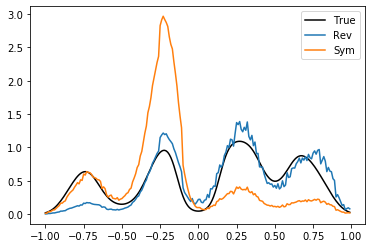

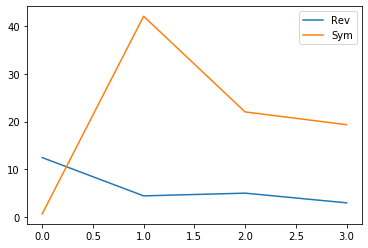

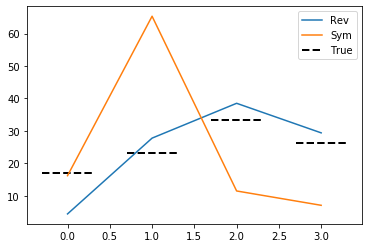

Error of rev: 3.0283018804652113, of sym: 8.929578208487277


In [42]:
mu_result_rev = model_mu.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
prinz_en = data_generator.prinz_energy(bin[:-1])
prinz_stat = np.exp(-prinz_en/kT_prinz)
scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
plt.plot(bin[:-1], hist_rev, label = 'Rev')
plt.plot(bin[:-1], hist_sym, label = 'Sym')
plt.legend()
plt.show()

rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
plt.plot(np.abs(rev_states_prob - tru_states_prob), label = "Rev")
plt.plot(np.abs(sym_states_prob - tru_states_prob), label = "Sym")
plt.legend()
plt.show()

rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
plt.plot(np.abs(rev_states_prob), label = "Rev")
plt.plot(np.abs(sym_states_prob), label = "Sym")
for j in range(4):
    legend=None
    if j>2:
        legend='True'
    plt.hlines(tru_states_prob[j], j-0.3, j+0.3, colors='k', linestyles='--', label=legend, lw=2)
plt.legend()
plt.show()

print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))

### Estimate eigenfunctions

[0.83244103 0.9057392  0.9822787  0.9999997 ]


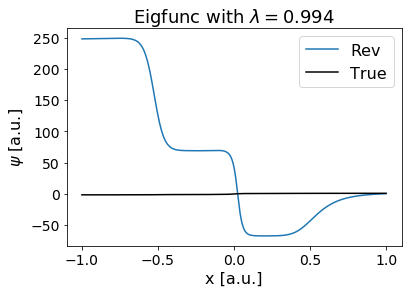

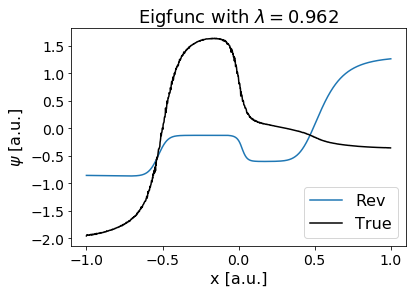

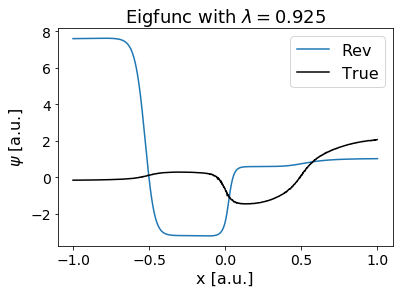

In [44]:
K_rev = model_K_all.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])[0]
eigvals_rev, eigvec_rev = np.linalg.eig(K_rev)
print(eigvals_rev)
sort_ind = np.argsort(eigvals_rev)[::-1]
# sort_ind = [2,1,3,0]
eigvals_rev = eigvals_rev[sort_ind]
eigvec_rev = eigvec_rev[:,sort_ind]

pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
eigfunc_rev1 = pred_xax @ eigvec_rev
for i in range(1,output_size):
    plt.title('Eigfunc with $\lambda={:.3}$'.format(true_eigvals[i]), fontsize=18)
    fac = true_eigfunc[0,i] / eigfunc_rev1[0,i]
    fac = true_eigfunc[-1,i] / eigfunc_rev1[-1,i]
    fac1 = true_eigfunc[0,i] / eigfunc_rev1[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_rev1[-1,i]
    fac = (fac1 + fac2)/2
    plt.plot(xax, fac*eigfunc_rev1[:,i], label='Rev')
    plt.plot(xax[::10], true_eigfunc[:,i], 'k', label='True')
    plt.legend(fontsize=16)
    plt.xlabel('x [a.u.]', fontsize=16)
    plt.xticks([-1.,-.5,0,0.5,1.],fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('$\psi$ [a.u.]', fontsize=16)
    plt.show()

### Reset $\mathbf{u}$ for training

In [45]:
def check_model():
    # model_chi.set_weights(weights_chi)
    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    N = Data_chi_X.shape[0]

    xax = np.linspace(-1, 1, 10000)
    pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
    for i in range(output_size):
        plt.plot(pred_xax[:,i])
    pot = data_generator.prinz_energy(xax)
    plt.plot(pot / pot.max())
    plt.show()
    c_0 = 1/N*Data_chi_X.T @ Data_chi_X
    c_tau = 1/N*Data_chi_X.T @ Data_chi_Y
    c_1 = 1/N*Data_chi_Y.T @ Data_chi_Y


    # estimate K_vamp

    eigv_all, eigvec_all = np.linalg.eigh(c_0)
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)

    K_vamp = c0_inv @ c_tau

    # estimate pi

    eigv, eigvec = np.linalg.eig(K_vamp.T)
    ind_pi = np.argmin((eigv-1)**2)
    pi_vec = eigvec[:,ind_pi]
    pi = pi_vec / np.sum(pi_vec, keepdims=True)
    print(pi)

    u_guess = c0_inv @ pi
    u_kernel = u_guess / factor_u

    print(u_guess)
    
    
    vamp_layer_u.set_weights([u_kernel])

    mu_result_rev = model_mu.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
    prinz_en = data_generator.prinz_energy(bin[:-1])
    prinz_stat = np.exp(-prinz_en/kT_prinz)
    scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
    plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
    plt.plot(bin[:-1], hist_rev, label = 'Rev')
    plt.plot(bin[:-1], hist_sym, label = 'Sym')
    plt.legend()
    plt.show()

    rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
    sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
    tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
    plt.plot(np.abs(rev_states_prob - tru_states_prob), label = "Rev")
    plt.plot(np.abs(sym_states_prob - tru_states_prob), label = "Sym")
    plt.legend()
    plt.show()
    
    rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
    sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
    tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
    plt.plot(np.abs(rev_states_prob), label = "Rev")
    plt.plot(np.abs(sym_states_prob), label = "Sym")
    for j in range(4):
        legend=None
        if j>2:
            legend='True'
        plt.hlines(tru_states_prob[j], j-0.3, j+0.3, colors='k', linestyles='--', label=legend, lw=2)
    plt.legend()
    plt.show()
    
    print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))
# get Sigma, invert it to get proxy S
    return

### Training loop with reseting u, stopping criteria via validation set score

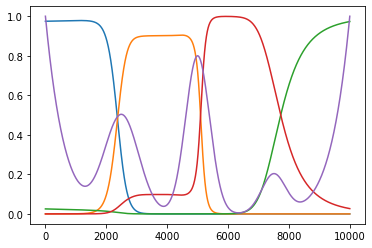

[0.06637553 0.17318481 0.27855995 0.48187965]
[ 0.37608075 -0.10078493  4.8095202   3.7910843 ]


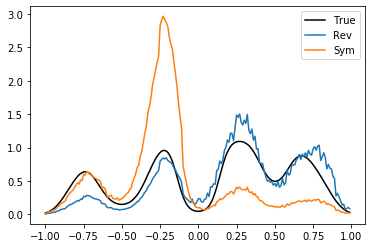

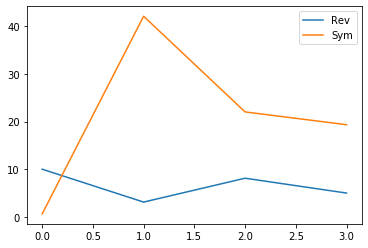

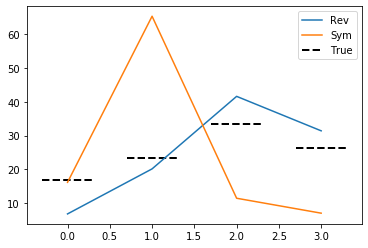

Error of rev: 2.9361463908677226, of sym: 8.929578208487277


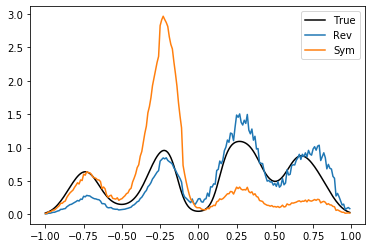

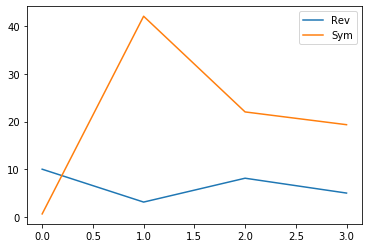

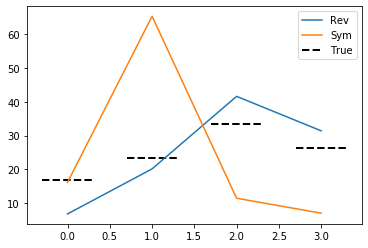

After S und u training
Error of rev: 2.9361312615696233, of sym: 8.929578208487277


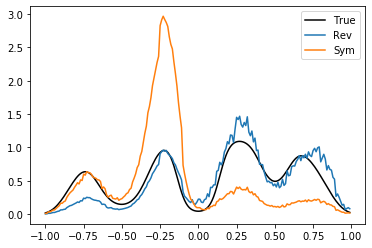

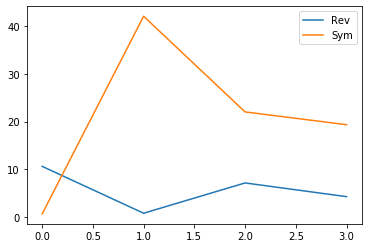

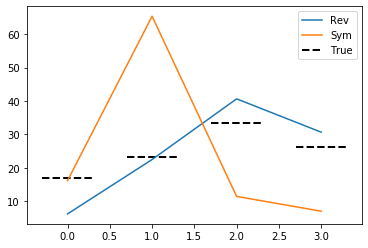

After training everyting
Error of rev: 2.8405642544032594, of sym: 8.929578208487277
110000/110000 [==============================] - 0s 2us/sample - loss: -3.6933
Old score 0.0, new score 3.693272352218628
Score is better and weights are saved


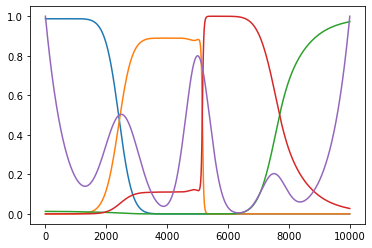

[0.13332787 0.26709834 0.2177183  0.3818555 ]
[0.8739748  0.14358062 3.7515533  2.8430443 ]


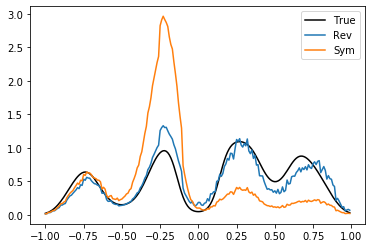

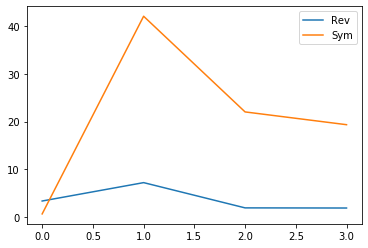

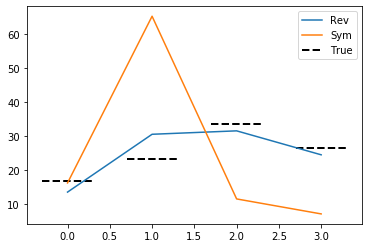

Error of rev: 2.169516357486396, of sym: 8.929578208487277


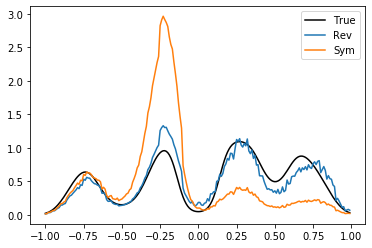

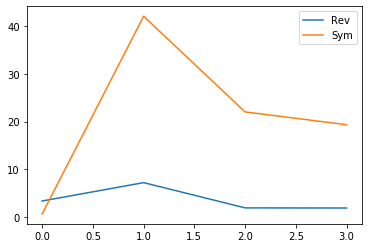

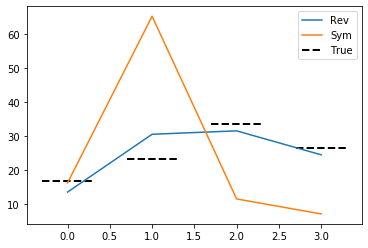

After S und u training
Error of rev: 2.1695623790753027, of sym: 8.929578208487277


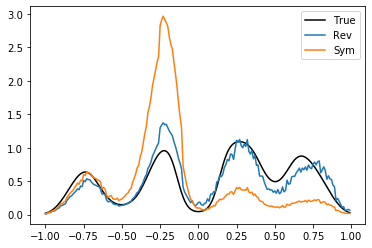

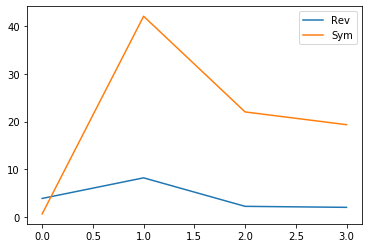

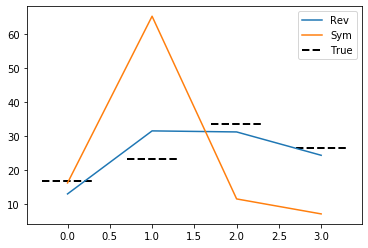

After training everyting
Error of rev: 2.3238478667681095, of sym: 8.929578208487277
110000/110000 [==============================] - 0s 2us/sample - loss: -3.7185
Old score 3.693272352218628, new score 3.7185232639312744
Score is better and weights are saved


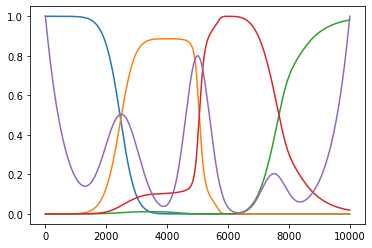

[0.07149895 0.13786331 0.3072554  0.48338234]
[ 0.48256782 -0.26127648  5.20072     3.8742163 ]


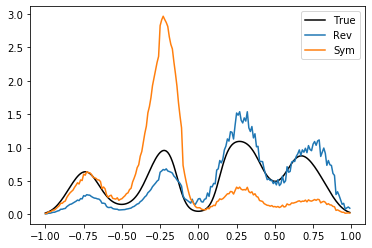

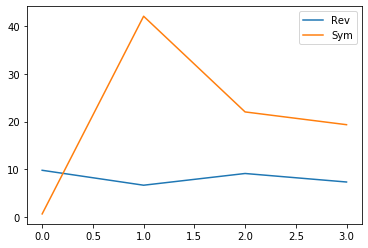

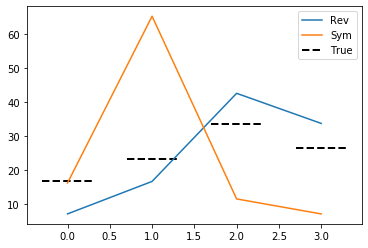

Error of rev: 3.287801582272483, of sym: 8.929578208487277


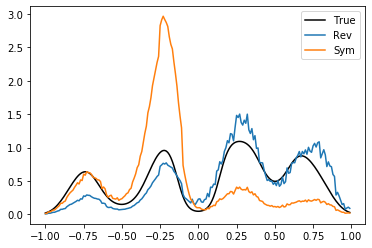

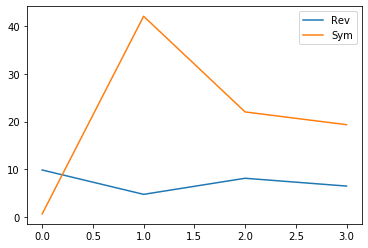

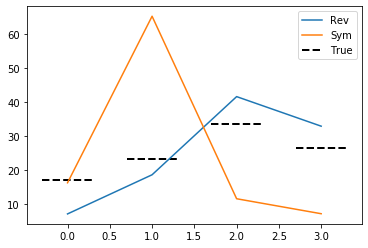

After S und u training
Error of rev: 3.063838988300702, of sym: 8.929578208487277


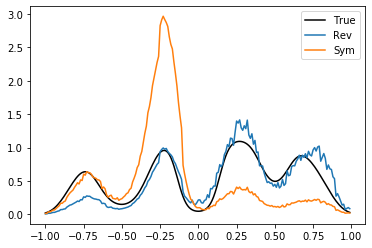

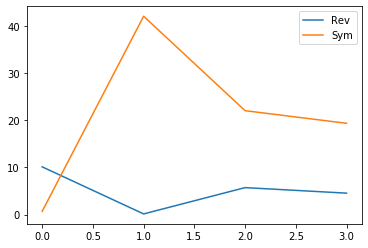

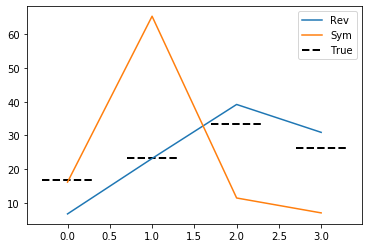

After training everyting
Error of rev: 2.7003189614547876, of sym: 8.929578208487277
110000/110000 [==============================] - 0s 2us/sample - loss: -3.7040
Old score 3.7185232639312744, new score 3.7040207386016846


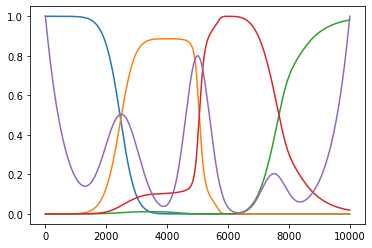

[0.07149895 0.13786331 0.3072554  0.48338234]
[ 0.48256782 -0.26127648  5.20072     3.8742163 ]


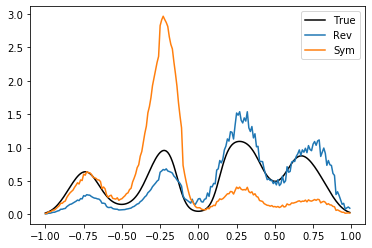

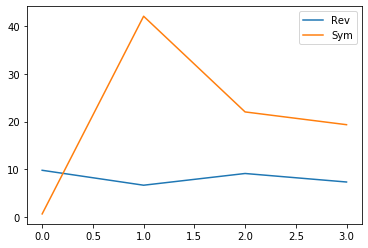

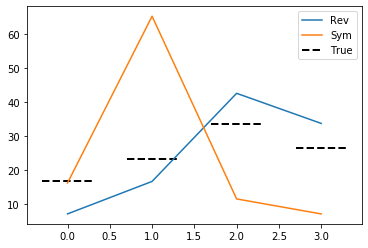

Error of rev: 3.287801582272483, of sym: 8.929578208487277


In [ ]:
score = 0. #- model_all_vampE.evaluate([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_train.shape[0])
weights_all = model_all_vampE.get_weights()
score_old = score
while (score >= score_old):
    
    check_model()


    vamp_layer_u.trainable = True
    vamp_layer_S.trainable = True
    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    Data_chi_vali = model_chi.predict([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])
    Data_chi_X_vali = Data_chi_vali[:,:output_size]
    Data_chi_Y_vali = Data_chi_vali[:,output_size:]


    model_both_vampE.compile(keras.optimizers.Adam(learning_rate=learning_rate*10000, clipnorm=1.),
                 trace_vampe,
             )
    patience = 50
    callbacks = [EarlyStopping('val_loss', patience=patience, mode='min', restore_best_weights=True),
    #              EarlyStoppingByLossVal('val_loss', value=-3.70)
            ]
    hist = model_both_vampE.fit([Data_chi_X, Data_chi_Y], Y_train ,
                     batch_size=Data_chi_X.shape[0],
                     epochs = np_epoch_S,
                     validation_data=([Data_chi_X_vali, Data_chi_Y_vali], Y_vali ),
                     verbose=0,
                     callbacks=callbacks,
                     shuffle=True)


    mu_result_rev = model_mu.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
    prinz_en = data_generator.prinz_energy(bin[:-1])
    prinz_stat = np.exp(-prinz_en/kT_prinz)
    scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
    plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
    plt.plot(bin[:-1], hist_rev, label = 'Rev')
    plt.plot(bin[:-1], hist_sym, label = 'Sym')
    plt.legend()
    plt.show()

    rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
    sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
    tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
    plt.plot(np.abs(rev_states_prob - tru_states_prob), label = "Rev")
    plt.plot(np.abs(sym_states_prob - tru_states_prob), label = "Sym")
    plt.legend()
    plt.show()

    rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
    sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
    tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
    plt.plot(np.abs(rev_states_prob), label = "Rev")
    plt.plot(np.abs(sym_states_prob), label = "Sym")
    for j in range(4):
        legend=None
        if j>2:
            legend='True'
        plt.hlines(tru_states_prob[j], j-0.3, j+0.3, colors='k', linestyles='--', label=legend, lw=2)
    plt.legend()
    plt.show()
    print('After S und u training')
    print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))

    epochs_all =3000
    patience = 100
    vamp_layer_u.trainable = True
    vamp_layer_S.trainable = True
    model_all_vampE.compile(keras.optimizers.Adam(learning_rate=learning_rate*0.04, clipnorm=1.),
                     trace_vampe,
                 )
    callbacks = [EarlyStopping('val_loss', patience=patience, mode='min', restore_best_weights=True)]
    hist = model_all_vampE.fit(
        [whiten(X1_train), whiten(X2_train)],
        Y_train,
        batch_size = X1_train.shape[0],
        epochs = epochs_all, #epoch_all,
        validation_data = ([whiten(X1_vali), whiten(X2_vali)], Y_vali ),
        verbose = 0,
        callbacks=callbacks,
        shuffle = True
    )

    mu_result_rev = model_mu.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
    prinz_en = data_generator.prinz_energy(bin[:-1])
    prinz_stat = np.exp(-prinz_en/kT_prinz)
    scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
    plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
    plt.plot(bin[:-1], hist_rev, label = 'Rev')
    plt.plot(bin[:-1], hist_sym, label = 'Sym')
    plt.legend()
    plt.show()

    rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
    sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
    tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
    plt.plot(np.abs(rev_states_prob - tru_states_prob), label = "Rev")
    plt.plot(np.abs(sym_states_prob - tru_states_prob), label = "Sym")
    plt.legend()
    plt.show()

    rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
    sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
    tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
    plt.plot(np.abs(rev_states_prob), label = "Rev")
    plt.plot(np.abs(sym_states_prob), label = "Sym")
    for j in range(4):
        legend=None
        if j>2:
            legend='True'
        plt.hlines(tru_states_prob[j], j-0.3, j+0.3, colors='k', linestyles='--', label=legend, lw=2)
    plt.legend()
    plt.show()
    print('After training everyting')
    print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))

    score = - model_all_vampE.evaluate([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])

    print('Old score {}, new score {}'.format(score_old, score))
    if (score>score_old):
        print('Score is better and weights are saved')
        score_old = score
        weights_all = model_all_vampE.get_weights()
        
        
model_all_vampE.set_weights(weights_all)
check_model()
    

vamp_layer_u.trainable = True
vamp_layer_S.trainable = True
Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
Data_chi_X = Data_chi[:,:output_size]
Data_chi_Y = Data_chi[:,output_size:]
Data_chi_vali = model_chi.predict([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])
Data_chi_X_vali = Data_chi_vali[:,:output_size]
Data_chi_Y_vali = Data_chi_vali[:,output_size:]


model_both_vampE.compile(keras.optimizers.Adam(learning_rate=learning_rate*10000, clipnorm=1.),
             trace_vampe,
         )

callbacks = [EarlyStopping('val_loss', patience=patience, mode='min', restore_best_weights=True),
#              EarlyStoppingByLossVal('val_loss', value=-3.70)
        ]
hist = model_both_vampE.fit([Data_chi_X, Data_chi_Y], Y_train ,
                 batch_size=Data_chi_X.shape[0],
                 epochs = np_epoch_S,
                 validation_data=([Data_chi_X_vali, Data_chi_Y_vali], Y_vali ),
                 verbose=0,
                 callbacks=callbacks,
                 shuffle=True)

mu_result_rev = model_mu.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
prinz_en = data_generator.prinz_energy(bin[:-1])
prinz_stat = np.exp(-prinz_en/kT_prinz)
scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
plt.plot(bin[:-1], hist_rev, label = 'Rev')
plt.plot(bin[:-1], hist_sym, label = 'Sym')
plt.legend()
plt.show()

rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
plt.plot(np.abs(rev_states_prob - tru_states_prob), label = "Rev")
plt.plot(np.abs(sym_states_prob - tru_states_prob), label = "Sym")
plt.legend()
plt.show()

rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
plt.plot(np.abs(rev_states_prob), label = "Rev")
plt.plot(np.abs(sym_states_prob), label = "Sym")
for j in range(4):
    legend=None
    if j>2:
        legend='True'
    plt.hlines(tru_states_prob[j], j-0.3, j+0.3, colors='k', linestyles='--', label=legend, lw=2)
plt.legend()
plt.show()
print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))

### Plotting eigenfunctions for revVAMPnet

[0.9297427  0.9623949  0.99552953 1.0000001 ]


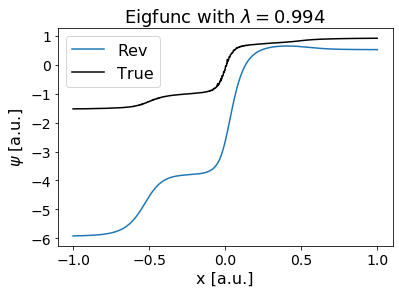

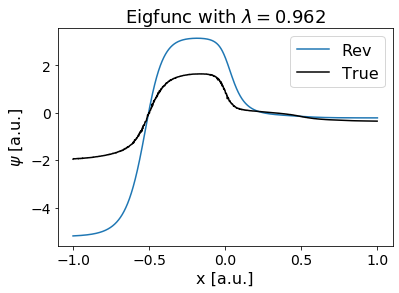

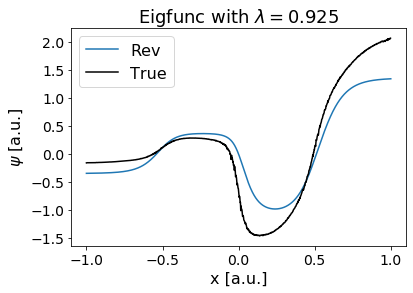

In [70]:
K_rev = model_K_all.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])[0]
eigvals_rev, eigvec_rev = np.linalg.eig(K_rev)
print(eigvals_rev)
sort_ind = np.argsort(eigvals_rev)[::-1]
# sort_ind = [2,1,3,0]
eigvals_rev = eigvals_rev[sort_ind]
eigvec_rev = eigvec_rev[:,sort_ind]

pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
eigfunc_rev = pred_xax @ eigvec_rev
for i in range(1,output_size):
    plt.title('Eigfunc with $\lambda={:.3}$'.format(true_eigvals[i]),fontsize=18)

    fac1 = true_eigfunc[0,i] / eigfunc_rev[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_rev[-1,i]
    fac = (fac1 + fac2)/2
#     if np.abs(eigfunc_rev[0,i]) > np.abs(eigfunc_rev[-1,i]):
#         fac = fac1
#     else:
#         fac = fac2
    plt.plot(xax, fac*eigfunc_rev[:,i], label='Rev')
    plt.plot(xax[::10], true_eigfunc[:,i], 'k', label='True')
    plt.legend(fontsize=16)
    plt.xlabel('x [a.u.]', fontsize=16)
    plt.xticks([-1.,-.5,0,0.5,1.],fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('$\psi$ [a.u.]', fontsize=16)
    plt.show()

## Training for revDMSM

### Initialization method

In [71]:
def estimate_u_S_with_vampnets():
    ''' For linear S and u, resulted in strange behaviour of S, K matrix had a lot of eigenvalues larger
    than 1...'''
#     model_chi.set_weights(weights_chi)
        
    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    N = Data_chi_X.shape[0]
    
    xax = np.linspace(-1, 1, 10000)
    pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
    for i in range(output_size):
        plt.plot(pred_xax[:,i])
    pot = data_generator.prinz_energy(xax)
    plt.plot(pot / pot.max())
    plt.show()
    
    c_0 = 1/N*Data_chi_X.T @ Data_chi_X
    c_tau = 1/N*Data_chi_X.T @ Data_chi_Y
    c_1 = 1/N*Data_chi_Y.T @ Data_chi_Y
    
    
    eigv_all, eigvec_all = np.linalg.eigh(c_0)
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
        
    K_vamp = c0_inv @ c_tau
    

    eigv, eigvec = np.linalg.eig(K_vamp.T)
    ind_pi = np.argmin((eigv-1)**2)
    
    pi_vec = eigvec[:,ind_pi]
#     print(eigv, ind_pi, pi_vec, eigvec)
    pi = pi_vec / np.sum(pi_vec, keepdims=True)
    print('Stationary vector is: {}'.format(pi))
    
    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    N = Data_chi_X.shape[0]

    
    c_0 = 1/N*Data_chi_X.T @ Data_chi_X
    eigv_all, eigvec_all = np.linalg.eigh(c_0)
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
    
    c_tau = 1/N*Data_chi_X.T @ Data_chi_Y
#     K_vamp = c0_inv @ c_tau
    
    u_guess = c0_inv @ pi
    u_kernel = np.log(np.abs(u_guess))
    
    print('Estimated u is: {}'.format(u_guess))
#     K_vamp = msm.transition_matrix
    
    # get Sigma, invert it to get proxy S
    vamp_layer_u_msm.set_weights([u_kernel])
    model_chi.set_weights(weights_chi)
    mu_result_rev = model_mu_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
    prinz_en = data_generator.prinz_energy(bin[:-1])
    prinz_stat = np.exp(-prinz_en/kT_prinz)
    scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
    plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
    plt.plot(bin[:-1], hist_rev, label = 'Rev')
    plt.plot(bin[:-1], hist_sym, label = 'Sym')
    plt.legend()
    plt.show()

    rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
    sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
    tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
    plt.plot(np.abs(rev_states_prob - tru_states_prob), label = "Rev")
    plt.plot(np.abs(sym_states_prob - tru_states_prob), label = "Sym")
    plt.legend()
    plt.show()
    print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))
    
    v_input, C_00_input, C_11_input, C_01_input, Sigma_input = model_input_S_msm.predict([Data_chi_X, Data_chi_Y], batch_size=Data_chi_X.shape[0])
    
    eigv_all, eigvec_all = np.linalg.eigh(Sigma_input[0])
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    sigma_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
    
#     print(K_vamp, np.linalg.eigvals(K_vamp))
    S_nonrev = K_vamp @ sigma_inv
    
    S_rev_add = 1/2 * (S_nonrev + S_nonrev.T)
#     print(S_rev_add @ Sigma_input[0])
    
    kernel_S = S_nonrev / 2.
    kernel_S = np.log(np.abs(kernel_S))
    
    vamp_layer_S_msm.set_weights([kernel_S])
    
    K_result = model_K_all_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
#     print(K_result[0])
#     helper = S_nonrev @ S_nonrev.T
#     include = eigv_all > epsilon
#     eigv = eigv_all[include]
#     eigvec = eigvec_all[:,include]    
#     S_rev_sqrt = eigvec @ np.diag(np.sqrt(eigv)) @ np.transpose(eigvec)
#     print(S_rev_sqrt @ Sigma_input[0])
#     print(np.linalg.eigvals(K_result[0]))
    
    return u_kernel, kernel_S

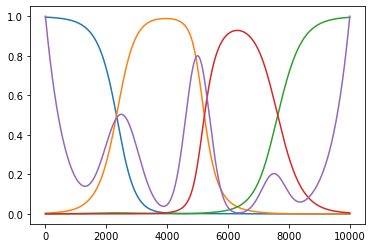

Stationary vector is: [0.03133573 0.09906208 0.3895086  0.48009363]
Estimated u is: [0.21654446 0.04775097 5.9557323  4.653107  ]


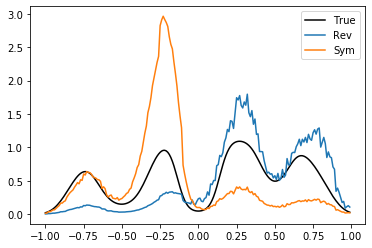

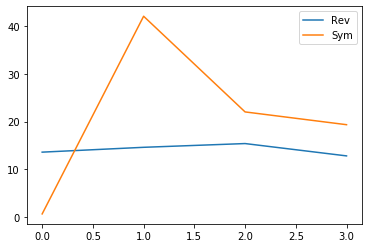

Error of rev: 5.067384263466334, of sym: 8.929578208487277


In [72]:
u_init, S_init = estimate_u_S_with_vampnets()

In [73]:
np_epoch_S = 10000
patience = 100
vamp_layer_u.trainable = True
vamp_layer_S.trainable = True
Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
Data_chi_X = Data_chi[:,:output_size]
Data_chi_Y = Data_chi[:,output_size:]
Data_chi_vali = model_chi.predict([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])
Data_chi_X_vali = Data_chi_vali[:,:output_size]
Data_chi_Y_vali = Data_chi_vali[:,output_size:]


model_both_vampE_msm.compile(keras.optimizers.Adam(learning_rate=learning_rate*10, clipnorm=1.),
             trace_vampe,
         )

callbacks = [EarlyStopping('val_loss', patience=patience, mode='min', restore_best_weights=True),
#              EarlyStoppingByLossVal('val_loss', value=-3.70)
        ]
hist = model_both_vampE_msm.fit([Data_chi_X, Data_chi_Y], Y_train ,
                 batch_size=Data_chi_X.shape[0],
                 epochs = np_epoch_S,
                 validation_data=([Data_chi_X_vali, Data_chi_Y_vali], Y_vali ),
                 verbose=1,
                 callbacks=callbacks,
                 shuffle=True)

Train on 110000 samples, validate on 110000 samples
Epoch 1/10000
110000/110000 [==============================] - 2s 14us/sample - loss: -1.8853 - val_loss: -1.8442
Epoch 2/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -1.8999 - val_loss: -1.8574
Epoch 3/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -1.9144 - val_loss: -1.8706
Epoch 4/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -1.9289 - val_loss: -1.8837
Epoch 5/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -1.9432 - val_loss: -1.8968
Epoch 6/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -1.9575 - val_loss: -1.9099
Epoch 7/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -1.9716 - val_loss: -1.9229
Epoch 8/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -1.9857 - val_loss: -1.9358
Epoch 9/10000
110000/110000 [==============

Epoch 73/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7527 - val_loss: -2.6970
Epoch 74/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7632 - val_loss: -2.7063
Epoch 75/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7735 - val_loss: -2.7153
Epoch 76/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7836 - val_loss: -2.7243
Epoch 77/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.7936 - val_loss: -2.7331
Epoch 78/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8033 - val_loss: -2.7419
Epoch 79/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8129 - val_loss: -2.7504
Epoch 80/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2.8224 - val_loss: -2.7589
Epoch 81/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -2

Epoch 145/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.2089 - val_loss: -3.1300
Epoch 146/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.2127 - val_loss: -3.1339
Epoch 147/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.2164 - val_loss: -3.1377
Epoch 148/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.2201 - val_loss: -3.1414
Epoch 149/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.2238 - val_loss: -3.1452
Epoch 150/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.2274 - val_loss: -3.1488
Epoch 151/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.2310 - val_loss: -3.1525
Epoch 152/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.2345 - val_loss: -3.1561
Epoch 153/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 217/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.3974 - val_loss: -3.3264
Epoch 218/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.3991 - val_loss: -3.3282
Epoch 219/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.4008 - val_loss: -3.3301
Epoch 220/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.4026 - val_loss: -3.3319
Epoch 221/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.4042 - val_loss: -3.3337
Epoch 222/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.4059 - val_loss: -3.3355
Epoch 223/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.4076 - val_loss: -3.3373
Epoch 224/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.4092 - val_loss: -3.3391
Epoch 225/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 289/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.4881 - val_loss: -3.4258
Epoch 290/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.4890 - val_loss: -3.4267
Epoch 291/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.4898 - val_loss: -3.4277
Epoch 292/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.4907 - val_loss: -3.4287
Epoch 293/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.4916 - val_loss: -3.4297
Epoch 294/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.4924 - val_loss: -3.4306
Epoch 295/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.4933 - val_loss: -3.4316
Epoch 296/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.4941 - val_loss: -3.4325
Epoch 297/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 361/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5359 - val_loss: -3.4805
Epoch 362/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5364 - val_loss: -3.4811
Epoch 363/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5369 - val_loss: -3.4816
Epoch 364/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5374 - val_loss: -3.4822
Epoch 365/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5378 - val_loss: -3.4828
Epoch 366/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5383 - val_loss: -3.4833
Epoch 367/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5388 - val_loss: -3.4839
Epoch 368/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5392 - val_loss: -3.4844
Epoch 369/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 433/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5630 - val_loss: -3.5127
Epoch 434/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5632 - val_loss: -3.5130
Epoch 435/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5635 - val_loss: -3.5134
Epoch 436/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5638 - val_loss: -3.5137
Epoch 437/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5641 - val_loss: -3.5141
Epoch 438/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5644 - val_loss: -3.5144
Epoch 439/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5646 - val_loss: -3.5147
Epoch 440/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5649 - val_loss: -3.5151
Epoch 441/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 505/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5791 - val_loss: -3.5326
Epoch 506/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5793 - val_loss: -3.5328
Epoch 507/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5795 - val_loss: -3.5330
Epoch 508/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5797 - val_loss: -3.5333
Epoch 509/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5798 - val_loss: -3.5335
Epoch 510/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5800 - val_loss: -3.5337
Epoch 511/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5802 - val_loss: -3.5339
Epoch 512/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5803 - val_loss: -3.5341
Epoch 513/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 577/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5893 - val_loss: -3.5455
Epoch 578/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5894 - val_loss: -3.5456
Epoch 579/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5895 - val_loss: -3.5458
Epoch 580/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5896 - val_loss: -3.5459
Epoch 581/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5898 - val_loss: -3.5461
Epoch 582/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5899 - val_loss: -3.5462
Epoch 583/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5900 - val_loss: -3.5464
Epoch 584/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5901 - val_loss: -3.5465
Epoch 585/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 649/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5960 - val_loss: -3.5542
Epoch 650/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5960 - val_loss: -3.5543
Epoch 651/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5961 - val_loss: -3.5544
Epoch 652/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5962 - val_loss: -3.5545
Epoch 653/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5963 - val_loss: -3.5546
Epoch 654/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5963 - val_loss: -3.5547
Epoch 655/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5964 - val_loss: -3.5548
Epoch 656/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.5965 - val_loss: -3.5549
Epoch 657/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 721/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6005 - val_loss: -3.5602
Epoch 722/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6006 - val_loss: -3.5603
Epoch 723/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6006 - val_loss: -3.5604
Epoch 724/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6007 - val_loss: -3.5604
Epoch 725/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6007 - val_loss: -3.5605
Epoch 726/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6008 - val_loss: -3.5606
Epoch 727/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6008 - val_loss: -3.5606
Epoch 728/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6009 - val_loss: -3.5607
Epoch 729/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 793/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6037 - val_loss: -3.5646
Epoch 794/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6038 - val_loss: -3.5646
Epoch 795/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6038 - val_loss: -3.5647
Epoch 796/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6039 - val_loss: -3.5647
Epoch 797/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6039 - val_loss: -3.5648
Epoch 798/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6039 - val_loss: -3.5648
Epoch 799/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6040 - val_loss: -3.5649
Epoch 800/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6040 - val_loss: -3.5649
Epoch 801/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 865/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6061 - val_loss: -3.5678
Epoch 866/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6061 - val_loss: -3.5678
Epoch 867/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6062 - val_loss: -3.5679
Epoch 868/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6062 - val_loss: -3.5679
Epoch 869/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6062 - val_loss: -3.5679
Epoch 870/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6062 - val_loss: -3.5680
Epoch 871/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6063 - val_loss: -3.5680
Epoch 872/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6063 - val_loss: -3.5680
Epoch 873/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 937/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6079 - val_loss: -3.5702
Epoch 938/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6079 - val_loss: -3.5702
Epoch 939/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6079 - val_loss: -3.5703
Epoch 940/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6079 - val_loss: -3.5703
Epoch 941/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6079 - val_loss: -3.5703
Epoch 942/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6080 - val_loss: -3.5704
Epoch 943/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6080 - val_loss: -3.5704
Epoch 944/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6080 - val_loss: -3.5704
Epoch 945/10000
110000/110000 [==============================] - 0s 1us/sample -

Epoch 1009/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6092 - val_loss: -3.5721
Epoch 1010/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6092 - val_loss: -3.5721
Epoch 1011/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6092 - val_loss: -3.5721
Epoch 1012/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6092 - val_loss: -3.5722
Epoch 1013/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6093 - val_loss: -3.5722
Epoch 1014/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6093 - val_loss: -3.5722
Epoch 1015/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6093 - val_loss: -3.5722
Epoch 1016/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6093 - val_loss: -3.5723
Epoch 1017/10000
110000/110000 [==============================] - 0s 1us

Epoch 1080/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6102 - val_loss: -3.5736
Epoch 1081/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6102 - val_loss: -3.5736
Epoch 1082/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6103 - val_loss: -3.5736
Epoch 1083/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6103 - val_loss: -3.5736
Epoch 1084/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6103 - val_loss: -3.5736
Epoch 1085/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6103 - val_loss: -3.5737
Epoch 1086/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6103 - val_loss: -3.5737
Epoch 1087/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6103 - val_loss: -3.5737
Epoch 1088/10000
110000/110000 [==============================] - 0s 1us

Epoch 1151/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6110 - val_loss: -3.5747
Epoch 1152/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6111 - val_loss: -3.5747
Epoch 1153/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6111 - val_loss: -3.5748
Epoch 1154/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6111 - val_loss: -3.5748
Epoch 1155/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6111 - val_loss: -3.5748
Epoch 1156/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6111 - val_loss: -3.5748
Epoch 1157/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6111 - val_loss: -3.5748
Epoch 1158/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6111 - val_loss: -3.5748
Epoch 1159/10000
110000/110000 [==============================] - 0s 1us

Epoch 1222/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6117 - val_loss: -3.5757
Epoch 1223/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6117 - val_loss: -3.5757
Epoch 1224/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6117 - val_loss: -3.5757
Epoch 1225/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6117 - val_loss: -3.5757
Epoch 1226/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6117 - val_loss: -3.5757
Epoch 1227/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6117 - val_loss: -3.5757
Epoch 1228/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6117 - val_loss: -3.5758
Epoch 1229/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6117 - val_loss: -3.5758
Epoch 1230/10000
110000/110000 [==============================] - 0s 1us

Epoch 1293/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6122 - val_loss: -3.5765
Epoch 1294/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6122 - val_loss: -3.5765
Epoch 1295/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6122 - val_loss: -3.5765
Epoch 1296/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6122 - val_loss: -3.5765
Epoch 1297/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6122 - val_loss: -3.5765
Epoch 1298/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6122 - val_loss: -3.5765
Epoch 1299/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6123 - val_loss: -3.5765
Epoch 1300/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6123 - val_loss: -3.5765
Epoch 1301/10000
110000/110000 [==============================] - 0s 1us

Epoch 1364/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6126 - val_loss: -3.5771
Epoch 1365/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6126 - val_loss: -3.5771
Epoch 1366/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6126 - val_loss: -3.5771
Epoch 1367/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6127 - val_loss: -3.5771
Epoch 1368/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6127 - val_loss: -3.5771
Epoch 1369/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6127 - val_loss: -3.5771
Epoch 1370/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6127 - val_loss: -3.5771
Epoch 1371/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6127 - val_loss: -3.5772
Epoch 1372/10000
110000/110000 [==============================] - 0s 1us

Epoch 1435/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6130 - val_loss: -3.5776
Epoch 1436/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6130 - val_loss: -3.5776
Epoch 1437/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6130 - val_loss: -3.5776
Epoch 1438/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6130 - val_loss: -3.5777
Epoch 1439/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6130 - val_loss: -3.5777
Epoch 1440/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6130 - val_loss: -3.5777
Epoch 1441/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6130 - val_loss: -3.5777
Epoch 1442/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6130 - val_loss: -3.5777
Epoch 1443/10000
110000/110000 [==============================] - 0s 1us

Epoch 1506/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6132 - val_loss: -3.5781
Epoch 1507/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6132 - val_loss: -3.5781
Epoch 1508/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6132 - val_loss: -3.5781
Epoch 1509/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6132 - val_loss: -3.5781
Epoch 1510/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6132 - val_loss: -3.5781
Epoch 1511/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6132 - val_loss: -3.5782
Epoch 1512/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6132 - val_loss: -3.5782
Epoch 1513/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6132 - val_loss: -3.5782
Epoch 1514/10000
110000/110000 [==============================] - 0s 1us

Epoch 1577/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6133 - val_loss: -3.5785
Epoch 1578/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6133 - val_loss: -3.5785
Epoch 1579/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6133 - val_loss: -3.5785
Epoch 1580/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6133 - val_loss: -3.5785
Epoch 1581/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6133 - val_loss: -3.5785
Epoch 1582/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6133 - val_loss: -3.5785
Epoch 1583/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6133 - val_loss: -3.5785
Epoch 1584/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6133 - val_loss: -3.5785
Epoch 1585/10000
110000/110000 [==============================] - 0s 1us

Epoch 1648/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6134 - val_loss: -3.5787
Epoch 1649/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6134 - val_loss: -3.5787
Epoch 1650/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6134 - val_loss: -3.5787
Epoch 1651/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6134 - val_loss: -3.5787
Epoch 1652/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6134 - val_loss: -3.5787
Epoch 1653/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6134 - val_loss: -3.5787
Epoch 1654/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6135 - val_loss: -3.5787
Epoch 1655/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6135 - val_loss: -3.5787
Epoch 1656/10000
110000/110000 [==============================] - 0s 1us

Epoch 1719/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6135 - val_loss: -3.5789
Epoch 1720/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6135 - val_loss: -3.5789
Epoch 1721/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6135 - val_loss: -3.5789
Epoch 1722/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6135 - val_loss: -3.5789
Epoch 1723/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6135 - val_loss: -3.5789
Epoch 1724/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6135 - val_loss: -3.5789
Epoch 1725/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6135 - val_loss: -3.5789
Epoch 1726/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6136 - val_loss: -3.5789
Epoch 1727/10000
110000/110000 [==============================] - 0s 1us

Epoch 1790/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6136 - val_loss: -3.5791
Epoch 1791/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6136 - val_loss: -3.5791
Epoch 1792/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6136 - val_loss: -3.5791
Epoch 1793/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6136 - val_loss: -3.5791
Epoch 1794/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6136 - val_loss: -3.5791
Epoch 1795/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6136 - val_loss: -3.5791
Epoch 1796/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6136 - val_loss: -3.5791
Epoch 1797/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6136 - val_loss: -3.5791
Epoch 1798/10000
110000/110000 [==============================] - 0s 1us

Epoch 1861/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6137 - val_loss: -3.5792
Epoch 1862/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6137 - val_loss: -3.5792
Epoch 1863/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6137 - val_loss: -3.5792
Epoch 1864/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6137 - val_loss: -3.5792
Epoch 1865/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6137 - val_loss: -3.5792
Epoch 1866/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6137 - val_loss: -3.5792
Epoch 1867/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6137 - val_loss: -3.5792
Epoch 1868/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6137 - val_loss: -3.5792
Epoch 1869/10000
110000/110000 [==============================] - 0s 1us

Epoch 1932/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6138 - val_loss: -3.5794
Epoch 1933/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6138 - val_loss: -3.5794
Epoch 1934/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6138 - val_loss: -3.5794
Epoch 1935/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6138 - val_loss: -3.5794
Epoch 1936/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6138 - val_loss: -3.5794
Epoch 1937/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6138 - val_loss: -3.5794
Epoch 1938/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6138 - val_loss: -3.5794
Epoch 1939/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6138 - val_loss: -3.5794
Epoch 1940/10000
110000/110000 [==============================] - 0s 1us

Epoch 2003/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5795
Epoch 2004/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5795
Epoch 2005/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5795
Epoch 2006/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5795
Epoch 2007/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5795
Epoch 2008/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5795
Epoch 2009/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5795
Epoch 2010/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5795
Epoch 2011/10000
110000/110000 [==============================] - 0s 1us

Epoch 2074/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5796
Epoch 2075/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5796
Epoch 2076/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5796
Epoch 2077/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5796
Epoch 2078/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5796
Epoch 2079/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5796
Epoch 2080/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5796
Epoch 2081/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6139 - val_loss: -3.5796
Epoch 2082/10000
110000/110000 [==============================] - 0s 1us

Epoch 2145/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2146/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2147/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2148/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2149/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2150/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2151/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2152/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2153/10000
110000/110000 [==============================] - 0s 1us

Epoch 2216/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2217/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2218/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2219/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2220/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2221/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2222/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2223/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6140 - val_loss: -3.5797
Epoch 2224/10000
110000/110000 [==============================] - 0s 1us

Epoch 2287/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5798
Epoch 2288/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5798
Epoch 2289/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5798
Epoch 2290/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5798
Epoch 2291/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5798
Epoch 2292/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5798
Epoch 2293/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5798
Epoch 2294/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5798
Epoch 2295/10000
110000/110000 [==============================] - 0s 1us

Epoch 2358/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5799
Epoch 2359/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5799
Epoch 2360/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5799
Epoch 2361/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5799
Epoch 2362/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5799
Epoch 2363/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5799
Epoch 2364/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5799
Epoch 2365/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6141 - val_loss: -3.5799
Epoch 2366/10000
110000/110000 [==============================] - 0s 1us

Epoch 2429/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5799
Epoch 2430/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5799
Epoch 2431/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5799
Epoch 2432/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5799
Epoch 2433/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5799
Epoch 2434/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5799
Epoch 2435/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5799
Epoch 2436/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5799
Epoch 2437/10000
110000/110000 [==============================] - 0s 1us

Epoch 2500/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5800
Epoch 2501/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5800
Epoch 2502/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5800
Epoch 2503/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5800
Epoch 2504/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5800
Epoch 2505/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5800
Epoch 2506/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5800
Epoch 2507/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6142 - val_loss: -3.5800
Epoch 2508/10000
110000/110000 [==============================] - 0s 1us

Epoch 2571/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5800
Epoch 2572/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5800
Epoch 2573/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5800
Epoch 2574/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5800
Epoch 2575/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5800
Epoch 2576/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5800
Epoch 2577/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5800
Epoch 2578/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5800
Epoch 2579/10000
110000/110000 [==============================] - 0s 1us

Epoch 2642/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5801
Epoch 2643/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5801
Epoch 2644/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5801
Epoch 2645/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5801
Epoch 2646/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5801
Epoch 2647/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5801
Epoch 2648/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5801
Epoch 2649/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6143 - val_loss: -3.5801
Epoch 2650/10000
110000/110000 [==============================] - 0s 1us

Epoch 2713/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5801
Epoch 2714/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5801
Epoch 2715/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5801
Epoch 2716/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5801
Epoch 2717/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5801
Epoch 2718/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5801
Epoch 2719/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5801
Epoch 2720/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5801
Epoch 2721/10000
110000/110000 [==============================] - 0s 1us

Epoch 2784/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5801
Epoch 2785/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5802
Epoch 2786/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5801
Epoch 2787/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5802
Epoch 2788/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5802
Epoch 2789/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5802
Epoch 2790/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5802
Epoch 2791/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5802
Epoch 2792/10000
110000/110000 [==============================] - 0s 1us

Epoch 2855/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5802
Epoch 2856/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5802
Epoch 2857/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5802
Epoch 2858/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5802
Epoch 2859/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5802
Epoch 2860/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5802
Epoch 2861/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5802
Epoch 2862/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6144 - val_loss: -3.5802
Epoch 2863/10000
110000/110000 [==============================] - 0s 1us

Epoch 2926/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5802
Epoch 2927/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5802
Epoch 2928/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5802
Epoch 2929/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5802
Epoch 2930/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5802
Epoch 2931/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5802
Epoch 2932/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5802
Epoch 2933/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5802
Epoch 2934/10000
110000/110000 [==============================] - 0s 1us

Epoch 2997/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5803
Epoch 2998/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5803
Epoch 2999/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5803
Epoch 3000/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5803
Epoch 3001/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5803
Epoch 3002/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5803
Epoch 3003/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5803
Epoch 3004/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6145 - val_loss: -3.5803
Epoch 3005/10000
110000/110000 [==============================] - 0s 1us

Epoch 3068/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3069/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3070/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3071/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3072/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3073/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3074/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3075/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3076/10000
110000/110000 [==============================] - 0s 1us

Epoch 3139/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3140/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3141/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3142/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3143/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3144/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3145/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3146/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3147/10000
110000/110000 [==============================] - 0s 1us

Epoch 3210/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3211/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5803
Epoch 3212/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5804
Epoch 3213/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5804
Epoch 3214/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5804
Epoch 3215/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5804
Epoch 3216/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5804
Epoch 3217/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6146 - val_loss: -3.5804
Epoch 3218/10000
110000/110000 [==============================] - 0s 1us

Epoch 3281/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3282/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3283/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3284/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3285/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3286/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3287/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3288/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3289/10000
110000/110000 [==============================] - 0s 1us

Epoch 3352/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3353/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3354/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3355/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3356/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3357/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3358/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3359/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6147 - val_loss: -3.5804
Epoch 3360/10000
110000/110000 [==============================] - 0s 1us

Epoch 3423/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5804
Epoch 3424/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5804
Epoch 3425/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5804
Epoch 3426/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5804
Epoch 3427/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5804
Epoch 3428/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5804
Epoch 3429/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5804
Epoch 3430/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5804
Epoch 3431/10000
110000/110000 [==============================] - 0s 1us

Epoch 3494/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3495/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3496/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3497/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3498/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3499/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3500/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3501/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3502/10000
110000/110000 [==============================] - 0s 1us

Epoch 3565/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3566/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3567/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3568/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3569/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3570/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3571/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3572/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6148 - val_loss: -3.5805
Epoch 3573/10000
110000/110000 [==============================] - 0s 1us

Epoch 3636/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3637/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3638/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3639/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3640/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3641/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3642/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3643/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3644/10000
110000/110000 [==============================] - 0s 1us

Epoch 3707/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3708/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3709/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3710/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3711/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3712/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3713/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3714/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5805
Epoch 3715/10000
110000/110000 [==============================] - 0s 1us

Epoch 3778/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5806
Epoch 3779/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5806
Epoch 3780/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5806
Epoch 3781/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5806
Epoch 3782/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5806
Epoch 3783/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5806
Epoch 3784/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5806
Epoch 3785/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6149 - val_loss: -3.5806
Epoch 3786/10000
110000/110000 [==============================] - 0s 1us

Epoch 3849/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3850/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3851/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3852/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3853/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3854/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3855/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3856/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3857/10000
110000/110000 [==============================] - 0s 1us

Epoch 3920/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3921/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3922/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3923/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3924/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3925/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3926/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3927/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3928/10000
110000/110000 [==============================] - 0s 1us

Epoch 3991/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3992/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3993/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3994/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3995/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3996/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3997/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3998/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5806
Epoch 3999/10000
110000/110000 [==============================] - 0s 1us

Epoch 4062/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5807
Epoch 4063/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5807
Epoch 4064/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5807
Epoch 4065/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6150 - val_loss: -3.5807
Epoch 4066/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4067/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4068/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4069/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4070/10000
110000/110000 [==============================] - 0s 1us

Epoch 4133/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4134/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4135/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4136/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4137/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4138/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4139/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4140/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4141/10000
110000/110000 [==============================] - 0s 1us

Epoch 4204/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4205/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4206/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4207/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4208/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4209/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4210/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4211/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4212/10000
110000/110000 [==============================] - 0s 1us

Epoch 4275/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4276/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4277/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4278/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4279/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4280/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4281/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4282/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6151 - val_loss: -3.5807
Epoch 4283/10000
110000/110000 [==============================] - 0s 1us

Epoch 4346/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5807
Epoch 4347/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5807
Epoch 4348/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5807
Epoch 4349/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5807
Epoch 4350/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5807
Epoch 4351/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4352/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4353/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4354/10000
110000/110000 [==============================] - 0s 1us

Epoch 4417/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4418/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4419/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4420/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4421/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4422/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4423/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4424/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4425/10000
110000/110000 [==============================] - 0s 1us

Epoch 4488/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4489/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4490/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4491/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4492/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4493/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4494/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4495/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4496/10000
110000/110000 [==============================] - 0s 1us

Epoch 4559/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4560/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4561/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4562/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4563/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4564/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4565/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4566/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6152 - val_loss: -3.5808
Epoch 4567/10000
110000/110000 [==============================] - 0s 1us

Epoch 4630/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4631/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4632/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4633/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4634/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4635/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4636/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4637/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4638/10000
110000/110000 [==============================] - 0s 1us

Epoch 4701/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4702/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4703/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4704/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4705/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4706/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4707/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5808
Epoch 4708/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4709/10000
110000/110000 [==============================] - 0s 1us

Epoch 4772/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4773/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4774/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4775/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4776/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4777/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4778/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4779/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4780/10000
110000/110000 [==============================] - 0s 1us

Epoch 4843/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4844/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4845/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4846/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4847/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4848/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4849/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4850/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6153 - val_loss: -3.5809
Epoch 4851/10000
110000/110000 [==============================] - 0s 1us

Epoch 4914/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4915/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4916/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4917/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4918/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4919/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4920/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4921/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4922/10000
110000/110000 [==============================] - 0s 1us

Epoch 4985/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4986/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4987/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4988/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4989/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4990/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4991/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4992/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 4993/10000
110000/110000 [==============================] - 0s 1us

Epoch 5056/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 5057/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 5058/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 5059/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 5060/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 5061/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 5062/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 5063/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5809
Epoch 5064/10000
110000/110000 [==============================] - 0s 1us

Epoch 5127/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5810
Epoch 5128/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5810
Epoch 5129/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5810
Epoch 5130/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5810
Epoch 5131/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5810
Epoch 5132/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5810
Epoch 5133/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5810
Epoch 5134/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6154 - val_loss: -3.5810
Epoch 5135/10000
110000/110000 [==============================] - 0s 1us

Epoch 5198/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5199/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5200/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5201/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5202/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5203/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5204/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5205/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5206/10000
110000/110000 [==============================] - 0s 1us

Epoch 5269/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5270/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5271/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5272/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5273/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5274/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5275/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5276/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5277/10000
110000/110000 [==============================] - 0s 1us

Epoch 5340/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5341/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5342/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5343/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5344/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5345/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5346/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5347/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5348/10000
110000/110000 [==============================] - 0s 1us

Epoch 5411/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5412/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5413/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5414/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5415/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5416/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5417/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5418/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5419/10000
110000/110000 [==============================] - 0s 1us

Epoch 5482/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5483/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5484/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5485/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5486/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5487/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5488/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5489/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6155 - val_loss: -3.5810
Epoch 5490/10000
110000/110000 [==============================] - 0s 1us

Epoch 5553/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5810
Epoch 5554/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5810
Epoch 5555/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5810
Epoch 5556/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5810
Epoch 5557/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5810
Epoch 5558/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5810
Epoch 5559/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5810
Epoch 5560/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5810
Epoch 5561/10000
110000/110000 [==============================] - 0s 1us

Epoch 5624/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5625/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5626/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5627/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5628/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5629/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5630/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5631/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5632/10000
110000/110000 [==============================] - 0s 1us

Epoch 5695/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5696/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5697/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5698/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5699/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5700/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5701/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5702/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5703/10000
110000/110000 [==============================] - 0s 1us

Epoch 5766/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5767/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5768/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5769/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5770/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5771/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5772/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5773/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5774/10000
110000/110000 [==============================] - 0s 1us

Epoch 5837/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5838/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5839/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5840/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5841/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5842/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5843/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5844/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5845/10000
110000/110000 [==============================] - 0s 1us

Epoch 5908/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5909/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5910/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5911/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5912/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5913/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5914/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5915/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6156 - val_loss: -3.5811
Epoch 5916/10000
110000/110000 [==============================] - 0s 1us

Epoch 5979/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 5980/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 5981/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 5982/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 5983/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 5984/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 5985/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 5986/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 5987/10000
110000/110000 [==============================] - 0s 1us

Epoch 6050/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6051/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6052/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6053/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6054/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6055/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6056/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6057/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6058/10000
110000/110000 [==============================] - 0s 1us

Epoch 6121/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6122/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6123/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6124/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6125/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6126/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6127/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6128/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5811
Epoch 6129/10000
110000/110000 [==============================] - 0s 1us

Epoch 6192/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6193/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6194/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6195/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6196/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6197/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6198/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6199/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6200/10000
110000/110000 [==============================] - 0s 1us

Epoch 6263/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6264/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6265/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6266/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6267/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6268/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6269/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6270/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6271/10000
110000/110000 [==============================] - 0s 1us

Epoch 6334/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6335/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6336/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6337/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6338/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6339/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6340/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6341/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6342/10000
110000/110000 [==============================] - 0s 1us

Epoch 6405/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6406/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6407/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6408/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6409/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6157 - val_loss: -3.5812
Epoch 6410/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6411/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6412/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6413/10000
110000/110000 [==============================] - 0s 1us

Epoch 6476/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6477/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6478/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6479/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6480/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6481/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6482/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6483/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6484/10000
110000/110000 [==============================] - 0s 1us

Epoch 6547/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6548/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6549/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6550/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6551/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6552/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6553/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6554/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6555/10000
110000/110000 [==============================] - 0s 1us

Epoch 6618/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6619/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6620/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6621/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6622/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6623/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6624/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6625/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6626/10000
110000/110000 [==============================] - 0s 1us

Epoch 6689/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6690/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6691/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6692/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6693/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6694/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6695/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6696/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6697/10000
110000/110000 [==============================] - 0s 1us

Epoch 6760/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6761/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6762/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6763/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6764/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6765/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6766/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6767/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6768/10000
110000/110000 [==============================] - 0s 1us

Epoch 6831/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6832/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6833/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6834/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6835/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6836/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6837/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6838/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5812
Epoch 6839/10000
110000/110000 [==============================] - 0s 1us

Epoch 6902/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6903/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6904/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6905/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6906/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6907/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6908/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6909/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6910/10000
110000/110000 [==============================] - 0s 1us

Epoch 6973/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6974/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6975/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6976/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6977/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6978/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6979/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6980/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6158 - val_loss: -3.5813
Epoch 6981/10000
110000/110000 [==============================] - 0s 1us

Epoch 7044/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7045/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7046/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7047/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7048/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7049/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7050/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7051/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7052/10000
110000/110000 [==============================] - 0s 1us

Epoch 7115/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7116/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7117/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7118/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7119/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7120/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7121/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7122/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7123/10000
110000/110000 [==============================] - 0s 1us

Epoch 7186/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7187/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7188/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7189/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7190/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7191/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7192/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7193/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7194/10000
110000/110000 [==============================] - 0s 1us

Epoch 7257/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7258/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7259/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7260/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7261/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7262/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7263/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7264/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7265/10000
110000/110000 [==============================] - 0s 1us

Epoch 7328/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7329/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7330/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7331/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7332/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7333/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7334/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7335/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7336/10000
110000/110000 [==============================] - 0s 1us

Epoch 7399/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7400/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7401/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7402/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7403/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7404/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7405/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7406/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7407/10000
110000/110000 [==============================] - 0s 1us

Epoch 7470/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7471/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7472/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7473/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7474/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7475/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7476/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7477/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7478/10000
110000/110000 [==============================] - 0s 1us

Epoch 7541/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7542/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7543/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7544/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7545/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7546/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7547/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7548/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7549/10000
110000/110000 [==============================] - 0s 1us

Epoch 7612/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7613/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7614/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7615/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7616/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7617/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7618/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7619/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7620/10000
110000/110000 [==============================] - 0s 1us

Epoch 7683/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7684/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7685/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7686/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7687/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7688/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7689/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7690/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7691/10000
110000/110000 [==============================] - 0s 1us

Epoch 7754/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7755/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7756/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7757/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7758/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7759/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7760/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7761/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7762/10000
110000/110000 [==============================] - 0s 1us

Epoch 7825/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7826/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7827/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7828/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7829/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6159 - val_loss: -3.5813
Epoch 7830/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7831/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7832/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7833/10000
110000/110000 [==============================] - 0s 1us

Epoch 7896/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7897/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7898/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7899/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7900/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7901/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7902/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7903/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7904/10000
110000/110000 [==============================] - 0s 1us

Epoch 7967/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7968/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7969/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7970/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7971/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7972/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7973/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7974/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5813
Epoch 7975/10000
110000/110000 [==============================] - 0s 1us

Epoch 8038/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8039/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8040/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8041/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8042/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8043/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8044/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8045/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8046/10000
110000/110000 [==============================] - 0s 1us

Epoch 8109/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8110/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8111/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8112/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8113/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8114/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8115/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8116/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8117/10000
110000/110000 [==============================] - 0s 1us

Epoch 8180/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8181/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8182/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8183/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8184/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8185/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8186/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8187/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8188/10000
110000/110000 [==============================] - 0s 1us

Epoch 8251/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8252/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8253/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8254/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8255/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8256/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8257/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8258/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8259/10000
110000/110000 [==============================] - 0s 1us

Epoch 8322/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8323/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8324/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8325/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8326/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8327/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8328/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8329/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8330/10000
110000/110000 [==============================] - 0s 1us

Epoch 8393/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8394/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8395/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8396/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8397/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8398/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8399/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8400/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8401/10000
110000/110000 [==============================] - 0s 1us

Epoch 8464/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8465/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8466/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8467/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8468/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8469/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8470/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8471/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8472/10000
110000/110000 [==============================] - 0s 1us

Epoch 8535/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8536/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8537/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8538/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8539/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8540/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8541/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8542/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8543/10000
110000/110000 [==============================] - 0s 1us

Epoch 8606/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8607/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8608/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8609/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8610/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8611/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8612/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8613/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8614/10000
110000/110000 [==============================] - 0s 1us

Epoch 8677/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8678/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8679/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8680/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8681/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8682/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8683/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8684/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8685/10000
110000/110000 [==============================] - 0s 1us

Epoch 8748/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8749/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8750/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8751/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8752/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8753/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8754/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8755/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8756/10000
110000/110000 [==============================] - 0s 1us

Epoch 8819/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8820/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8821/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8822/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8823/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8824/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8825/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8826/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8827/10000
110000/110000 [==============================] - 0s 1us

Epoch 8890/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8891/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8892/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8893/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8894/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8895/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8896/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8897/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8898/10000
110000/110000 [==============================] - 0s 1us

Epoch 8961/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8962/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8963/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8964/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8965/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8966/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8967/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8968/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 8969/10000
110000/110000 [==============================] - 0s 1us

Epoch 9032/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 9033/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 9034/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 9035/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 9036/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 9037/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 9038/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 9039/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 9040/10000
110000/110000 [==============================] - 0s 1us

Epoch 9103/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 9104/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 9105/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 9106/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 9107/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6160 - val_loss: -3.5814
Epoch 9108/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9109/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9110/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9111/10000
110000/110000 [==============================] - 0s 1us

Epoch 9174/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9175/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9176/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9177/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9178/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9179/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9180/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9181/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9182/10000
110000/110000 [==============================] - 0s 1us

Epoch 9245/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9246/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9247/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9248/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9249/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9250/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9251/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9252/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9253/10000
110000/110000 [==============================] - 0s 1us

Epoch 9316/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9317/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9318/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9319/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9320/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9321/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9322/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9323/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9324/10000
110000/110000 [==============================] - 0s 1us

Epoch 9387/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9388/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9389/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9390/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9391/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9392/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9393/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9394/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9395/10000
110000/110000 [==============================] - 0s 1us

Epoch 9458/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9459/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9460/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9461/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9462/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9463/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9464/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9465/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9466/10000
110000/110000 [==============================] - 0s 1us

Epoch 9529/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9530/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9531/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9532/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9533/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9534/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9535/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9536/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9537/10000
110000/110000 [==============================] - 0s 1us

Epoch 9600/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9601/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9602/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9603/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9604/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9605/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9606/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9607/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9608/10000
110000/110000 [==============================] - 0s 1us

Epoch 9671/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9672/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9673/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9674/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9675/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9676/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9677/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9678/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9679/10000
110000/110000 [==============================] - 0s 1us

Epoch 9742/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9743/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9744/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9745/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9746/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9747/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9748/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9749/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9750/10000
110000/110000 [==============================] - 0s 1us

Epoch 9813/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9814/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9815/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9816/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9817/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9818/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9819/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9820/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9821/10000
110000/110000 [==============================] - 0s 1us

Epoch 9884/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9885/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9886/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9887/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9888/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9889/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9890/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9891/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9892/10000
110000/110000 [==============================] - 0s 1us

Epoch 9955/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9956/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9957/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9958/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9959/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9960/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9961/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9962/10000
110000/110000 [==============================] - 0s 1us/sample - loss: -3.6161 - val_loss: -3.5814
Epoch 9963/10000
110000/110000 [==============================] - 0s 1us

In [74]:
epochs_all = 3000
patience = 50
vamp_layer_u_msm.trainable = True
vamp_layer_S_msm.trainable = True
model_all_vampE_msm.compile(keras.optimizers.Adam(learning_rate=learning_rate*0.04, clipnorm=1.),
                 trace_vampe,
             )
callbacks = [EarlyStopping('val_loss', patience=patience, mode='min', restore_best_weights=True)]
hist = model_all_vampE_msm.fit(
    [whiten(X1_train), whiten(X2_train)],
    Y_train,
    batch_size = X1_train.shape[0],
    epochs = epochs_all, #epoch_all,
    validation_data = ([whiten(X1_vali), whiten(X2_vali)], Y_vali ),
    verbose = 2,
    callbacks=callbacks,
    shuffle = True
)

Train on 110000 samples, validate on 110000 samples
Epoch 1/3000
110000/110000 - 2s - loss: -3.6161e+00 - val_loss: -3.5844e+00
Epoch 2/3000
110000/110000 - 0s - loss: -3.6186e+00 - val_loss: -3.5872e+00
Epoch 3/3000
110000/110000 - 0s - loss: -3.6209e+00 - val_loss: -3.5898e+00
Epoch 4/3000
110000/110000 - 0s - loss: -3.6231e+00 - val_loss: -3.5923e+00
Epoch 5/3000
110000/110000 - 0s - loss: -3.6252e+00 - val_loss: -3.5946e+00
Epoch 6/3000
110000/110000 - 0s - loss: -3.6271e+00 - val_loss: -3.5968e+00
Epoch 7/3000
110000/110000 - 0s - loss: -3.6290e+00 - val_loss: -3.5989e+00
Epoch 8/3000
110000/110000 - 0s - loss: -3.6308e+00 - val_loss: -3.6009e+00
Epoch 9/3000
110000/110000 - 0s - loss: -3.6325e+00 - val_loss: -3.6029e+00
Epoch 10/3000
110000/110000 - 0s - loss: -3.6341e+00 - val_loss: -3.6047e+00
Epoch 11/3000
110000/110000 - 0s - loss: -3.6357e+00 - val_loss: -3.6065e+00
Epoch 12/3000
110000/110000 - 0s - loss: -3.6372e+00 - val_loss: -3.6081e+00
Epoch 13/3000
110000/110000 - 0s 

Epoch 107/3000
110000/110000 - 0s - loss: -3.7059e+00 - val_loss: -3.6782e+00
Epoch 108/3000
110000/110000 - 0s - loss: -3.7062e+00 - val_loss: -3.6785e+00
Epoch 109/3000
110000/110000 - 0s - loss: -3.7065e+00 - val_loss: -3.6788e+00
Epoch 110/3000
110000/110000 - 0s - loss: -3.7068e+00 - val_loss: -3.6791e+00
Epoch 111/3000
110000/110000 - 0s - loss: -3.7071e+00 - val_loss: -3.6794e+00
Epoch 112/3000
110000/110000 - 0s - loss: -3.7073e+00 - val_loss: -3.6797e+00
Epoch 113/3000
110000/110000 - 0s - loss: -3.7076e+00 - val_loss: -3.6799e+00
Epoch 114/3000
110000/110000 - 0s - loss: -3.7079e+00 - val_loss: -3.6802e+00
Epoch 115/3000
110000/110000 - 0s - loss: -3.7082e+00 - val_loss: -3.6805e+00
Epoch 116/3000
110000/110000 - 0s - loss: -3.7084e+00 - val_loss: -3.6807e+00
Epoch 117/3000
110000/110000 - 0s - loss: -3.7087e+00 - val_loss: -3.6810e+00
Epoch 118/3000
110000/110000 - 0s - loss: -3.7089e+00 - val_loss: -3.6813e+00
Epoch 119/3000
110000/110000 - 0s - loss: -3.7092e+00 - val_loss

110000/110000 - 0s - loss: -3.7222e+00 - val_loss: -3.6944e+00
Epoch 213/3000
110000/110000 - 0s - loss: -3.7223e+00 - val_loss: -3.6944e+00
Epoch 214/3000
110000/110000 - 0s - loss: -3.7223e+00 - val_loss: -3.6945e+00
Epoch 215/3000
110000/110000 - 0s - loss: -3.7224e+00 - val_loss: -3.6946e+00
Epoch 216/3000
110000/110000 - 0s - loss: -3.7225e+00 - val_loss: -3.6946e+00
Epoch 217/3000
110000/110000 - 0s - loss: -3.7225e+00 - val_loss: -3.6947e+00
Epoch 218/3000
110000/110000 - 0s - loss: -3.7226e+00 - val_loss: -3.6948e+00
Epoch 219/3000
110000/110000 - 0s - loss: -3.7227e+00 - val_loss: -3.6948e+00
Epoch 220/3000
110000/110000 - 0s - loss: -3.7227e+00 - val_loss: -3.6949e+00
Epoch 221/3000
110000/110000 - 0s - loss: -3.7228e+00 - val_loss: -3.6950e+00
Epoch 222/3000
110000/110000 - 0s - loss: -3.7228e+00 - val_loss: -3.6950e+00
Epoch 223/3000
110000/110000 - 0s - loss: -3.7229e+00 - val_loss: -3.6951e+00
Epoch 224/3000
110000/110000 - 0s - loss: -3.7230e+00 - val_loss: -3.6951e+00
E

Epoch 318/3000
110000/110000 - 0s - loss: -3.7262e+00 - val_loss: -3.6982e+00
Epoch 319/3000
110000/110000 - 0s - loss: -3.7262e+00 - val_loss: -3.6982e+00
Epoch 320/3000
110000/110000 - 0s - loss: -3.7262e+00 - val_loss: -3.6983e+00
Epoch 321/3000
110000/110000 - 0s - loss: -3.7262e+00 - val_loss: -3.6983e+00
Epoch 322/3000
110000/110000 - 0s - loss: -3.7263e+00 - val_loss: -3.6983e+00
Epoch 323/3000
110000/110000 - 0s - loss: -3.7263e+00 - val_loss: -3.6983e+00
Epoch 324/3000
110000/110000 - 0s - loss: -3.7263e+00 - val_loss: -3.6983e+00
Epoch 325/3000
110000/110000 - 0s - loss: -3.7263e+00 - val_loss: -3.6983e+00
Epoch 326/3000
110000/110000 - 0s - loss: -3.7263e+00 - val_loss: -3.6984e+00
Epoch 327/3000
110000/110000 - 0s - loss: -3.7263e+00 - val_loss: -3.6984e+00
Epoch 328/3000
110000/110000 - 0s - loss: -3.7264e+00 - val_loss: -3.6984e+00
Epoch 329/3000
110000/110000 - 0s - loss: -3.7264e+00 - val_loss: -3.6984e+00
Epoch 330/3000
110000/110000 - 0s - loss: -3.7264e+00 - val_loss

110000/110000 - 0s - loss: -3.7273e+00 - val_loss: -3.6992e+00
Epoch 424/3000
110000/110000 - 0s - loss: -3.7273e+00 - val_loss: -3.6992e+00
Epoch 425/3000
110000/110000 - 0s - loss: -3.7273e+00 - val_loss: -3.6992e+00
Epoch 426/3000
110000/110000 - 0s - loss: -3.7273e+00 - val_loss: -3.6992e+00
Epoch 427/3000
110000/110000 - 0s - loss: -3.7273e+00 - val_loss: -3.6992e+00
Epoch 428/3000
110000/110000 - 0s - loss: -3.7273e+00 - val_loss: -3.6992e+00
Epoch 429/3000
110000/110000 - 0s - loss: -3.7273e+00 - val_loss: -3.6992e+00
Epoch 430/3000
110000/110000 - 0s - loss: -3.7273e+00 - val_loss: -3.6992e+00
Epoch 431/3000
110000/110000 - 0s - loss: -3.7273e+00 - val_loss: -3.6992e+00
Epoch 432/3000
110000/110000 - 0s - loss: -3.7273e+00 - val_loss: -3.6992e+00
Epoch 433/3000
110000/110000 - 0s - loss: -3.7274e+00 - val_loss: -3.6992e+00
Epoch 434/3000
110000/110000 - 0s - loss: -3.7274e+00 - val_loss: -3.6993e+00
Epoch 435/3000
110000/110000 - 0s - loss: -3.7274e+00 - val_loss: -3.6993e+00
E

Epoch 529/3000
110000/110000 - 0s - loss: -3.7277e+00 - val_loss: -3.6995e+00
Epoch 530/3000
110000/110000 - 0s - loss: -3.7277e+00 - val_loss: -3.6995e+00
Epoch 531/3000
110000/110000 - 0s - loss: -3.7277e+00 - val_loss: -3.6995e+00
Epoch 532/3000
110000/110000 - 0s - loss: -3.7277e+00 - val_loss: -3.6995e+00
Epoch 533/3000
110000/110000 - 0s - loss: -3.7277e+00 - val_loss: -3.6995e+00
Epoch 534/3000
110000/110000 - 0s - loss: -3.7277e+00 - val_loss: -3.6995e+00
Epoch 535/3000
110000/110000 - 0s - loss: -3.7277e+00 - val_loss: -3.6995e+00
Epoch 536/3000
110000/110000 - 0s - loss: -3.7277e+00 - val_loss: -3.6995e+00
Epoch 537/3000
110000/110000 - 0s - loss: -3.7277e+00 - val_loss: -3.6995e+00
Epoch 538/3000
110000/110000 - 0s - loss: -3.7277e+00 - val_loss: -3.6995e+00
Epoch 539/3000
110000/110000 - 0s - loss: -3.7277e+00 - val_loss: -3.6995e+00
Epoch 540/3000
110000/110000 - 0s - loss: -3.7277e+00 - val_loss: -3.6995e+00
Epoch 541/3000
110000/110000 - 0s - loss: -3.7277e+00 - val_loss

110000/110000 - 0s - loss: -3.7279e+00 - val_loss: -3.6997e+00
Epoch 635/3000
110000/110000 - 0s - loss: -3.7279e+00 - val_loss: -3.6997e+00
Epoch 636/3000
110000/110000 - 0s - loss: -3.7279e+00 - val_loss: -3.6997e+00
Epoch 637/3000
110000/110000 - 0s - loss: -3.7279e+00 - val_loss: -3.6997e+00
Epoch 638/3000
110000/110000 - 0s - loss: -3.7279e+00 - val_loss: -3.6997e+00
Epoch 639/3000
110000/110000 - 0s - loss: -3.7279e+00 - val_loss: -3.6997e+00
Epoch 640/3000
110000/110000 - 0s - loss: -3.7279e+00 - val_loss: -3.6997e+00
Epoch 641/3000
110000/110000 - 0s - loss: -3.7279e+00 - val_loss: -3.6997e+00
Epoch 642/3000
110000/110000 - 0s - loss: -3.7279e+00 - val_loss: -3.6997e+00
Epoch 643/3000
110000/110000 - 0s - loss: -3.7279e+00 - val_loss: -3.6997e+00
Epoch 644/3000
110000/110000 - 0s - loss: -3.7279e+00 - val_loss: -3.6997e+00
Epoch 645/3000
110000/110000 - 0s - loss: -3.7279e+00 - val_loss: -3.6997e+00
Epoch 646/3000
110000/110000 - 0s - loss: -3.7279e+00 - val_loss: -3.6997e+00
E

Epoch 740/3000
110000/110000 - 0s - loss: -3.7281e+00 - val_loss: -3.6998e+00
Epoch 741/3000
110000/110000 - 0s - loss: -3.7281e+00 - val_loss: -3.6998e+00
Epoch 742/3000
110000/110000 - 0s - loss: -3.7281e+00 - val_loss: -3.6999e+00
Epoch 743/3000
110000/110000 - 0s - loss: -3.7281e+00 - val_loss: -3.6999e+00
Epoch 744/3000
110000/110000 - 0s - loss: -3.7281e+00 - val_loss: -3.6999e+00
Epoch 745/3000
110000/110000 - 0s - loss: -3.7281e+00 - val_loss: -3.6999e+00
Epoch 746/3000
110000/110000 - 0s - loss: -3.7281e+00 - val_loss: -3.6999e+00
Epoch 747/3000
110000/110000 - 0s - loss: -3.7281e+00 - val_loss: -3.6999e+00
Epoch 748/3000
110000/110000 - 0s - loss: -3.7281e+00 - val_loss: -3.6999e+00
Epoch 749/3000
110000/110000 - 0s - loss: -3.7281e+00 - val_loss: -3.6999e+00
Epoch 750/3000
110000/110000 - 0s - loss: -3.7281e+00 - val_loss: -3.6999e+00
Epoch 751/3000
110000/110000 - 0s - loss: -3.7281e+00 - val_loss: -3.6999e+00
Epoch 752/3000
110000/110000 - 0s - loss: -3.7281e+00 - val_loss

110000/110000 - 0s - loss: -3.7282e+00 - val_loss: -3.7000e+00
Epoch 846/3000
110000/110000 - 0s - loss: -3.7282e+00 - val_loss: -3.7000e+00
Epoch 847/3000
110000/110000 - 0s - loss: -3.7282e+00 - val_loss: -3.7000e+00
Epoch 848/3000
110000/110000 - 0s - loss: -3.7282e+00 - val_loss: -3.7000e+00
Epoch 849/3000
110000/110000 - 0s - loss: -3.7282e+00 - val_loss: -3.7000e+00
Epoch 850/3000
110000/110000 - 0s - loss: -3.7282e+00 - val_loss: -3.7000e+00
Epoch 851/3000
110000/110000 - 0s - loss: -3.7282e+00 - val_loss: -3.7000e+00
Epoch 852/3000
110000/110000 - 0s - loss: -3.7283e+00 - val_loss: -3.7000e+00
Epoch 853/3000
110000/110000 - 0s - loss: -3.7283e+00 - val_loss: -3.7000e+00
Epoch 854/3000
110000/110000 - 0s - loss: -3.7283e+00 - val_loss: -3.7000e+00
Epoch 855/3000
110000/110000 - 0s - loss: -3.7283e+00 - val_loss: -3.7000e+00
Epoch 856/3000
110000/110000 - 0s - loss: -3.7283e+00 - val_loss: -3.7000e+00
Epoch 857/3000
110000/110000 - 0s - loss: -3.7283e+00 - val_loss: -3.7000e+00
E

Epoch 951/3000
110000/110000 - 0s - loss: -3.7284e+00 - val_loss: -3.7001e+00
Epoch 952/3000
110000/110000 - 0s - loss: -3.7284e+00 - val_loss: -3.7001e+00
Epoch 953/3000
110000/110000 - 0s - loss: -3.7284e+00 - val_loss: -3.7001e+00
Epoch 954/3000
110000/110000 - 0s - loss: -3.7284e+00 - val_loss: -3.7001e+00
Epoch 955/3000
110000/110000 - 0s - loss: -3.7284e+00 - val_loss: -3.7001e+00
Epoch 956/3000
110000/110000 - 0s - loss: -3.7284e+00 - val_loss: -3.7001e+00
Epoch 957/3000
110000/110000 - 0s - loss: -3.7284e+00 - val_loss: -3.7001e+00
Epoch 958/3000
110000/110000 - 0s - loss: -3.7284e+00 - val_loss: -3.7002e+00
Epoch 959/3000
110000/110000 - 0s - loss: -3.7284e+00 - val_loss: -3.7002e+00
Epoch 960/3000
110000/110000 - 0s - loss: -3.7284e+00 - val_loss: -3.7002e+00
Epoch 961/3000
110000/110000 - 0s - loss: -3.7284e+00 - val_loss: -3.7002e+00
Epoch 962/3000
110000/110000 - 0s - loss: -3.7284e+00 - val_loss: -3.7002e+00
Epoch 963/3000
110000/110000 - 0s - loss: -3.7284e+00 - val_loss

Epoch 1056/3000
110000/110000 - 0s - loss: -3.7285e+00 - val_loss: -3.7003e+00
Epoch 1057/3000
110000/110000 - 0s - loss: -3.7285e+00 - val_loss: -3.7003e+00
Epoch 1058/3000
110000/110000 - 0s - loss: -3.7285e+00 - val_loss: -3.7003e+00
Epoch 1059/3000
110000/110000 - 0s - loss: -3.7285e+00 - val_loss: -3.7003e+00
Epoch 1060/3000
110000/110000 - 0s - loss: -3.7285e+00 - val_loss: -3.7003e+00
Epoch 1061/3000
110000/110000 - 0s - loss: -3.7285e+00 - val_loss: -3.7003e+00
Epoch 1062/3000
110000/110000 - 0s - loss: -3.7285e+00 - val_loss: -3.7003e+00
Epoch 1063/3000
110000/110000 - 0s - loss: -3.7285e+00 - val_loss: -3.7003e+00
Epoch 1064/3000
110000/110000 - 0s - loss: -3.7285e+00 - val_loss: -3.7003e+00
Epoch 1065/3000
110000/110000 - 0s - loss: -3.7285e+00 - val_loss: -3.7003e+00
Epoch 1066/3000
110000/110000 - 0s - loss: -3.7285e+00 - val_loss: -3.7003e+00
Epoch 1067/3000
110000/110000 - 0s - loss: -3.7285e+00 - val_loss: -3.7003e+00
Epoch 1068/3000
110000/110000 - 0s - loss: -3.7286e+

Epoch 1160/3000
110000/110000 - 0s - loss: -3.7287e+00 - val_loss: -3.7004e+00
Epoch 1161/3000
110000/110000 - 0s - loss: -3.7287e+00 - val_loss: -3.7004e+00
Epoch 1162/3000
110000/110000 - 0s - loss: -3.7287e+00 - val_loss: -3.7004e+00
Epoch 1163/3000
110000/110000 - 0s - loss: -3.7287e+00 - val_loss: -3.7004e+00
Epoch 1164/3000
110000/110000 - 0s - loss: -3.7287e+00 - val_loss: -3.7004e+00
Epoch 1165/3000
110000/110000 - 0s - loss: -3.7287e+00 - val_loss: -3.7004e+00
Epoch 1166/3000
110000/110000 - 0s - loss: -3.7287e+00 - val_loss: -3.7004e+00
Epoch 1167/3000
110000/110000 - 0s - loss: -3.7287e+00 - val_loss: -3.7004e+00
Epoch 1168/3000
110000/110000 - 0s - loss: -3.7287e+00 - val_loss: -3.7004e+00
Epoch 1169/3000
110000/110000 - 0s - loss: -3.7287e+00 - val_loss: -3.7004e+00
Epoch 1170/3000
110000/110000 - 0s - loss: -3.7287e+00 - val_loss: -3.7004e+00
Epoch 1171/3000
110000/110000 - 0s - loss: -3.7287e+00 - val_loss: -3.7004e+00
Epoch 1172/3000
110000/110000 - 0s - loss: -3.7287e+

Epoch 1264/3000
110000/110000 - 0s - loss: -3.7288e+00 - val_loss: -3.7005e+00
Epoch 1265/3000
110000/110000 - 0s - loss: -3.7288e+00 - val_loss: -3.7005e+00
Epoch 1266/3000
110000/110000 - 0s - loss: -3.7288e+00 - val_loss: -3.7005e+00
Epoch 1267/3000
110000/110000 - 0s - loss: -3.7288e+00 - val_loss: -3.7005e+00
Epoch 1268/3000
110000/110000 - 0s - loss: -3.7288e+00 - val_loss: -3.7005e+00
Epoch 1269/3000
110000/110000 - 0s - loss: -3.7288e+00 - val_loss: -3.7005e+00
Epoch 1270/3000
110000/110000 - 0s - loss: -3.7288e+00 - val_loss: -3.7005e+00
Epoch 1271/3000
110000/110000 - 0s - loss: -3.7288e+00 - val_loss: -3.7005e+00
Epoch 1272/3000
110000/110000 - 0s - loss: -3.7288e+00 - val_loss: -3.7005e+00
Epoch 1273/3000
110000/110000 - 0s - loss: -3.7288e+00 - val_loss: -3.7005e+00
Epoch 1274/3000
110000/110000 - 0s - loss: -3.7288e+00 - val_loss: -3.7005e+00
Epoch 1275/3000
110000/110000 - 0s - loss: -3.7288e+00 - val_loss: -3.7005e+00
Epoch 1276/3000
110000/110000 - 0s - loss: -3.7288e+

Epoch 1368/3000
110000/110000 - 0s - loss: -3.7289e+00 - val_loss: -3.7006e+00
Epoch 1369/3000
110000/110000 - 0s - loss: -3.7289e+00 - val_loss: -3.7006e+00
Epoch 1370/3000
110000/110000 - 0s - loss: -3.7289e+00 - val_loss: -3.7006e+00
Epoch 1371/3000
110000/110000 - 0s - loss: -3.7289e+00 - val_loss: -3.7006e+00
Epoch 1372/3000
110000/110000 - 0s - loss: -3.7289e+00 - val_loss: -3.7006e+00
Epoch 1373/3000
110000/110000 - 0s - loss: -3.7289e+00 - val_loss: -3.7006e+00
Epoch 1374/3000
110000/110000 - 0s - loss: -3.7289e+00 - val_loss: -3.7006e+00
Epoch 1375/3000
110000/110000 - 0s - loss: -3.7289e+00 - val_loss: -3.7006e+00
Epoch 1376/3000
110000/110000 - 0s - loss: -3.7289e+00 - val_loss: -3.7006e+00
Epoch 1377/3000
110000/110000 - 0s - loss: -3.7289e+00 - val_loss: -3.7006e+00
Epoch 1378/3000
110000/110000 - 0s - loss: -3.7289e+00 - val_loss: -3.7006e+00
Epoch 1379/3000
110000/110000 - 0s - loss: -3.7289e+00 - val_loss: -3.7006e+00
Epoch 1380/3000
110000/110000 - 0s - loss: -3.7289e+

Epoch 1472/3000
110000/110000 - 0s - loss: -3.7290e+00 - val_loss: -3.7007e+00
Epoch 1473/3000
110000/110000 - 0s - loss: -3.7290e+00 - val_loss: -3.7007e+00
Epoch 1474/3000
110000/110000 - 0s - loss: -3.7290e+00 - val_loss: -3.7007e+00
Epoch 1475/3000
110000/110000 - 0s - loss: -3.7290e+00 - val_loss: -3.7007e+00
Epoch 1476/3000
110000/110000 - 0s - loss: -3.7290e+00 - val_loss: -3.7007e+00
Epoch 1477/3000
110000/110000 - 0s - loss: -3.7290e+00 - val_loss: -3.7007e+00
Epoch 1478/3000
110000/110000 - 0s - loss: -3.7290e+00 - val_loss: -3.7007e+00
Epoch 1479/3000
110000/110000 - 0s - loss: -3.7290e+00 - val_loss: -3.7007e+00
Epoch 1480/3000
110000/110000 - 0s - loss: -3.7290e+00 - val_loss: -3.7007e+00
Epoch 1481/3000
110000/110000 - 0s - loss: -3.7290e+00 - val_loss: -3.7007e+00
Epoch 1482/3000
110000/110000 - 0s - loss: -3.7290e+00 - val_loss: -3.7007e+00
Epoch 1483/3000
110000/110000 - 0s - loss: -3.7290e+00 - val_loss: -3.7007e+00
Epoch 1484/3000
110000/110000 - 0s - loss: -3.7290e+

Epoch 1576/3000
110000/110000 - 0s - loss: -3.7291e+00 - val_loss: -3.7007e+00
Epoch 1577/3000
110000/110000 - 0s - loss: -3.7291e+00 - val_loss: -3.7007e+00
Epoch 1578/3000
110000/110000 - 0s - loss: -3.7291e+00 - val_loss: -3.7007e+00
Epoch 1579/3000
110000/110000 - 0s - loss: -3.7291e+00 - val_loss: -3.7007e+00
Epoch 1580/3000
110000/110000 - 0s - loss: -3.7291e+00 - val_loss: -3.7007e+00
Epoch 1581/3000
110000/110000 - 0s - loss: -3.7291e+00 - val_loss: -3.7007e+00
Epoch 1582/3000
110000/110000 - 0s - loss: -3.7291e+00 - val_loss: -3.7007e+00
Epoch 1583/3000
110000/110000 - 0s - loss: -3.7291e+00 - val_loss: -3.7007e+00
Epoch 1584/3000
110000/110000 - 0s - loss: -3.7291e+00 - val_loss: -3.7007e+00
Epoch 1585/3000
110000/110000 - 0s - loss: -3.7291e+00 - val_loss: -3.7007e+00
Epoch 1586/3000
110000/110000 - 0s - loss: -3.7291e+00 - val_loss: -3.7007e+00
Epoch 1587/3000
110000/110000 - 0s - loss: -3.7291e+00 - val_loss: -3.7007e+00
Epoch 1588/3000
110000/110000 - 0s - loss: -3.7291e+

Epoch 1680/3000
110000/110000 - 0s - loss: -3.7292e+00 - val_loss: -3.7008e+00
Epoch 1681/3000
110000/110000 - 0s - loss: -3.7292e+00 - val_loss: -3.7008e+00
Epoch 1682/3000
110000/110000 - 0s - loss: -3.7292e+00 - val_loss: -3.7008e+00
Epoch 1683/3000
110000/110000 - 0s - loss: -3.7292e+00 - val_loss: -3.7008e+00
Epoch 1684/3000
110000/110000 - 0s - loss: -3.7292e+00 - val_loss: -3.7008e+00
Epoch 1685/3000
110000/110000 - 0s - loss: -3.7292e+00 - val_loss: -3.7008e+00
Epoch 1686/3000
110000/110000 - 0s - loss: -3.7292e+00 - val_loss: -3.7008e+00
Epoch 1687/3000
110000/110000 - 0s - loss: -3.7292e+00 - val_loss: -3.7008e+00
Epoch 1688/3000
110000/110000 - 0s - loss: -3.7292e+00 - val_loss: -3.7008e+00
Epoch 1689/3000
110000/110000 - 0s - loss: -3.7292e+00 - val_loss: -3.7008e+00
Epoch 1690/3000
110000/110000 - 0s - loss: -3.7292e+00 - val_loss: -3.7008e+00
Epoch 1691/3000
110000/110000 - 0s - loss: -3.7292e+00 - val_loss: -3.7008e+00
Epoch 1692/3000
110000/110000 - 0s - loss: -3.7292e+

Epoch 1784/3000
110000/110000 - 0s - loss: -3.7292e+00 - val_loss: -3.7009e+00
Epoch 1785/3000
110000/110000 - 0s - loss: -3.7292e+00 - val_loss: -3.7009e+00
Epoch 1786/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1787/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1788/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1789/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1790/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1791/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1792/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1793/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1794/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1795/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1796/3000
110000/110000 - 0s - loss: -3.7293e+

Epoch 1888/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1889/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1890/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1891/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1892/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1893/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1894/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1895/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1896/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1897/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1898/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1899/3000
110000/110000 - 0s - loss: -3.7293e+00 - val_loss: -3.7009e+00
Epoch 1900/3000
110000/110000 - 0s - loss: -3.7293e+

Epoch 1992/3000
110000/110000 - 0s - loss: -3.7294e+00 - val_loss: -3.7010e+00
Epoch 1993/3000
110000/110000 - 0s - loss: -3.7294e+00 - val_loss: -3.7010e+00
Epoch 1994/3000
110000/110000 - 0s - loss: -3.7294e+00 - val_loss: -3.7010e+00
Epoch 1995/3000
110000/110000 - 0s - loss: -3.7294e+00 - val_loss: -3.7010e+00
Epoch 1996/3000
110000/110000 - 0s - loss: -3.7294e+00 - val_loss: -3.7010e+00
Epoch 1997/3000
110000/110000 - 0s - loss: -3.7294e+00 - val_loss: -3.7010e+00
Epoch 1998/3000
110000/110000 - 0s - loss: -3.7294e+00 - val_loss: -3.7010e+00
Epoch 1999/3000
110000/110000 - 0s - loss: -3.7294e+00 - val_loss: -3.7010e+00
Epoch 2000/3000
110000/110000 - 0s - loss: -3.7294e+00 - val_loss: -3.7010e+00
Epoch 2001/3000
110000/110000 - 0s - loss: -3.7294e+00 - val_loss: -3.7010e+00
Epoch 2002/3000
110000/110000 - 0s - loss: -3.7294e+00 - val_loss: -3.7010e+00
Epoch 2003/3000
110000/110000 - 0s - loss: -3.7294e+00 - val_loss: -3.7010e+00
Epoch 2004/3000
110000/110000 - 0s - loss: -3.7294e+

Epoch 2096/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7010e+00
Epoch 2097/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7010e+00
Epoch 2098/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7010e+00
Epoch 2099/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7010e+00
Epoch 2100/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7010e+00
Epoch 2101/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7010e+00
Epoch 2102/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7010e+00
Epoch 2103/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7010e+00
Epoch 2104/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7010e+00
Epoch 2105/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7010e+00
Epoch 2106/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7010e+00
Epoch 2107/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7010e+00
Epoch 2108/3000
110000/110000 - 0s - loss: -3.7295e+

Epoch 2200/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7011e+00
Epoch 2201/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7011e+00
Epoch 2202/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7011e+00
Epoch 2203/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7011e+00
Epoch 2204/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7011e+00
Epoch 2205/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7011e+00
Epoch 2206/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7011e+00
Epoch 2207/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7011e+00
Epoch 2208/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7011e+00
Epoch 2209/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7011e+00
Epoch 2210/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7011e+00
Epoch 2211/3000
110000/110000 - 0s - loss: -3.7295e+00 - val_loss: -3.7011e+00
Epoch 2212/3000
110000/110000 - 0s - loss: -3.7295e+

Epoch 2304/3000
110000/110000 - 0s - loss: -3.7296e+00 - val_loss: -3.7011e+00
Epoch 2305/3000
110000/110000 - 0s - loss: -3.7296e+00 - val_loss: -3.7011e+00
Epoch 2306/3000
110000/110000 - 0s - loss: -3.7296e+00 - val_loss: -3.7011e+00
Epoch 2307/3000
110000/110000 - 0s - loss: -3.7296e+00 - val_loss: -3.7011e+00
Epoch 2308/3000
110000/110000 - 0s - loss: -3.7296e+00 - val_loss: -3.7011e+00
Epoch 2309/3000
110000/110000 - 0s - loss: -3.7296e+00 - val_loss: -3.7011e+00
Epoch 2310/3000
110000/110000 - 0s - loss: -3.7296e+00 - val_loss: -3.7011e+00
Epoch 2311/3000
110000/110000 - 0s - loss: -3.7296e+00 - val_loss: -3.7011e+00
Epoch 2312/3000
110000/110000 - 0s - loss: -3.7296e+00 - val_loss: -3.7011e+00
Epoch 2313/3000
110000/110000 - 0s - loss: -3.7296e+00 - val_loss: -3.7011e+00
Epoch 2314/3000
110000/110000 - 0s - loss: -3.7296e+00 - val_loss: -3.7011e+00
Epoch 2315/3000
110000/110000 - 0s - loss: -3.7296e+00 - val_loss: -3.7011e+00
Epoch 2316/3000
110000/110000 - 0s - loss: -3.7296e+

Epoch 2408/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2409/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2410/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2411/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2412/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2413/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2414/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2415/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2416/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2417/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2418/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2419/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2420/3000
110000/110000 - 0s - loss: -3.7297e+

Epoch 2512/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2513/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2514/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2515/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2516/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2517/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2518/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2519/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2520/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2521/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2522/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2523/3000
110000/110000 - 0s - loss: -3.7297e+00 - val_loss: -3.7012e+00
Epoch 2524/3000
110000/110000 - 0s - loss: -3.7297e+

Epoch 2616/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7012e+00
Epoch 2617/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7012e+00
Epoch 2618/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7012e+00
Epoch 2619/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7012e+00
Epoch 2620/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7012e+00
Epoch 2621/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7012e+00
Epoch 2622/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7012e+00
Epoch 2623/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7012e+00
Epoch 2624/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7012e+00
Epoch 2625/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7012e+00
Epoch 2626/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7012e+00
Epoch 2627/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7012e+00
Epoch 2628/3000
110000/110000 - 0s - loss: -3.7298e+

Epoch 2720/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7013e+00
Epoch 2721/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7013e+00
Epoch 2722/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7013e+00
Epoch 2723/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7013e+00
Epoch 2724/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7013e+00
Epoch 2725/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7013e+00
Epoch 2726/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7013e+00
Epoch 2727/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7013e+00
Epoch 2728/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7013e+00
Epoch 2729/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7013e+00
Epoch 2730/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7013e+00
Epoch 2731/3000
110000/110000 - 0s - loss: -3.7298e+00 - val_loss: -3.7013e+00
Epoch 2732/3000
110000/110000 - 0s - loss: -3.7298e+

Epoch 2824/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7013e+00
Epoch 2825/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7013e+00
Epoch 2826/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7013e+00
Epoch 2827/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7013e+00
Epoch 2828/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7013e+00
Epoch 2829/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7013e+00
Epoch 2830/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7013e+00
Epoch 2831/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7013e+00
Epoch 2832/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7013e+00
Epoch 2833/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7013e+00
Epoch 2834/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7013e+00
Epoch 2835/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7013e+00
Epoch 2836/3000
110000/110000 - 0s - loss: -3.7299e+

Epoch 2928/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7014e+00
Epoch 2929/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7014e+00
Epoch 2930/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7014e+00
Epoch 2931/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7014e+00
Epoch 2932/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7014e+00
Epoch 2933/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7014e+00
Epoch 2934/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7014e+00
Epoch 2935/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7014e+00
Epoch 2936/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7014e+00
Epoch 2937/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7014e+00
Epoch 2938/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7014e+00
Epoch 2939/3000
110000/110000 - 0s - loss: -3.7299e+00 - val_loss: -3.7014e+00
Epoch 2940/3000
110000/110000 - 0s - loss: -3.7299e+

[0.84360695 0.8964861  0.99999934 0.9774175 ]


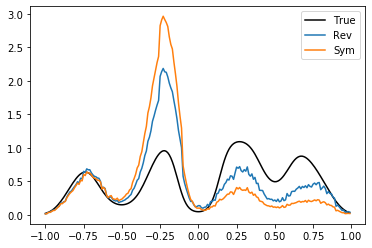

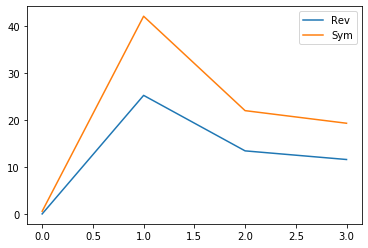

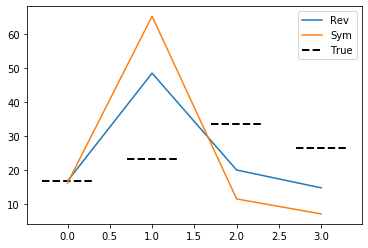

Error of rev: 5.509256608834367, of sym: 8.929578208487277


In [75]:
K_result = model_K_all_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
print(np.linalg.eigvals(K_result[0]))
mu_result_rev = model_mu_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
prinz_en = data_generator.prinz_energy(bin[:-1])
prinz_stat = np.exp(-prinz_en/kT_prinz)
scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
plt.plot(bin[:-1], hist_rev, label = 'Rev')
plt.plot(bin[:-1], hist_sym, label = 'Sym')
plt.legend()
plt.show()

rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
plt.plot(np.abs(rev_states_prob - tru_states_prob), label = "Rev")
plt.plot(np.abs(sym_states_prob - tru_states_prob), label = "Sym")
plt.legend()
plt.show()

rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
plt.plot(np.abs(rev_states_prob), label = "Rev")
plt.plot(np.abs(sym_states_prob), label = "Sym")
for j in range(4):
    legend=None
    if j>2:
        legend='True'
    plt.hlines(tru_states_prob[j], j-0.3, j+0.3, colors='k', linestyles='--', label=legend, lw=2)
plt.legend()
plt.show()

print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))

[0.84360695 0.8964861  0.99999934 0.9774175 ]


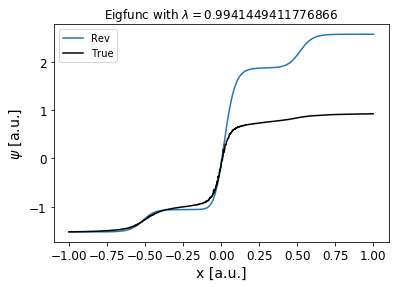

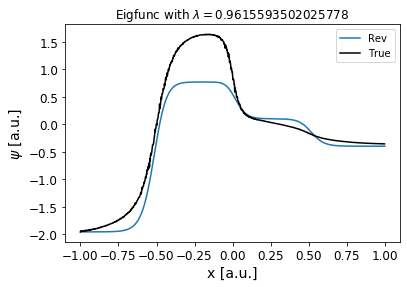

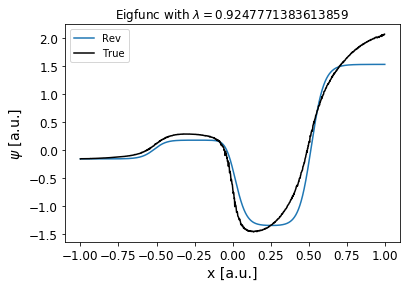

In [76]:
K_rev_msm = model_K_all_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])[0]
eigvals_rev, eigvec_rev = np.linalg.eig(K_rev_msm)
print(eigvals_rev)
sort_ind = np.argsort(eigvals_rev)[::-1]
# sort_ind = [2,1,3,0]
eigvals_rev = eigvals_rev[sort_ind]
eigvec_rev = eigvec_rev[:,sort_ind]

pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
eigfunc_rev_msm1 = pred_xax @ eigvec_rev
for i in range(1,output_size):
    plt.title('Eigfunc with $\lambda={}$'.format(true_eigvals[i]))
    fac = true_eigfunc[0,i] / eigfunc_rev_msm1[0,i]
    plt.plot(xax, fac*eigfunc_rev_msm1[:,i], label='Rev')
    plt.plot(xax[::10], true_eigfunc[:,i], 'k', label='True')
    plt.legend()
    plt.xlabel('x [a.u.]', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('$\psi$ [a.u.]', fontsize=14)
    plt.show()

In [77]:
def check_model():
    # model_chi.set_weights(weights_chi)
    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    N = Data_chi_X.shape[0]

    xax = np.linspace(-1, 1, 10000)
    pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
    for i in range(output_size):
        plt.plot(pred_xax[:,i])
    pot = data_generator.prinz_energy(xax)
    plt.plot(pot / pot.max())
    plt.show()
    c_0 = 1/N*Data_chi_X.T @ Data_chi_X
    c_tau = 1/N*Data_chi_X.T @ Data_chi_Y
    c_1 = 1/N*Data_chi_Y.T @ Data_chi_Y


    # estimate K_vamp

    eigv_all, eigvec_all = np.linalg.eigh(c_0)
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)

    K_vamp = c0_inv @ c_tau

    # estimate pi

    eigv, eigvec = np.linalg.eig(K_vamp.T)
    ind_pi = np.argmin((eigv-1)**2)
    pi_vec = eigvec[:,ind_pi]
    pi = pi_vec / np.sum(pi_vec, keepdims=True)
    print(pi)

    u_guess = c0_inv @ pi
    u_kernel = np.log(np.abs(u_guess))

    print(u_guess)
    
    
    vamp_layer_u_msm.set_weights([u_kernel])

    mu_result_rev = model_mu_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
    prinz_en = data_generator.prinz_energy(bin[:-1])
    prinz_stat = np.exp(-prinz_en/kT_prinz)
    scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
    plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
    plt.plot(bin[:-1], hist_rev, label = 'Rev')
    plt.plot(bin[:-1], hist_sym, label = 'Sym')
    plt.legend()
    plt.show()

    rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
    sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
    tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
    plt.plot(np.abs(rev_states_prob - tru_states_prob), label = "Rev")
    plt.plot(np.abs(sym_states_prob - tru_states_prob), label = "Sym")
    plt.legend()
    plt.show()
    
    rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
    sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
    tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
    plt.plot(np.abs(rev_states_prob), label = "Rev")
    plt.plot(np.abs(sym_states_prob), label = "Sym")
    for j in range(4):
        legend=None
        if j>2:
            legend='True'
        plt.hlines(tru_states_prob[j], j-0.3, j+0.3, colors='k', linestyles='--', label=legend, lw=2)
    plt.legend()
    plt.show()
    
    print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))
# get Sigma, invert it to get proxy S
    return

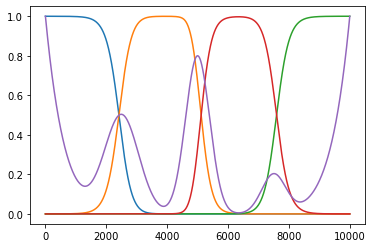

[0.0257728  0.07603823 0.42139876 0.47679016]
[0.1719824  0.08383471 6.347141   4.284368  ]


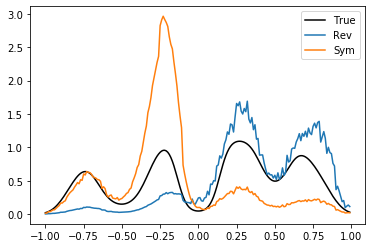

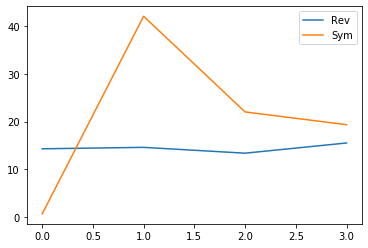

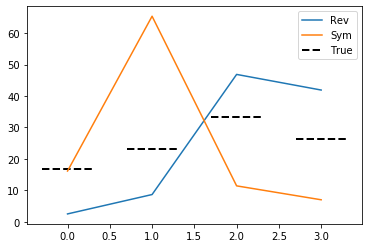

Error of rev: 5.1493298519150015, of sym: 8.929578208487277


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [80]:
score = 0. #- model_all_vampE.evaluate([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_train.shape[0])
weights_all = model_all_vampE.get_weights()
score_old = score
while (score >= score_old):
    
    check_model()


    vamp_layer_u_msm.trainable = True
    vamp_layer_S_msm.trainable = True
    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    Data_chi_vali = model_chi.predict([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])
    Data_chi_X_vali = Data_chi_vali[:,:output_size]
    Data_chi_Y_vali = Data_chi_vali[:,output_size:]


    model_both_vampE_msm.compile(keras.optimizers.Adam(learning_rate=learning_rate*100, clipnorm=1.),
                 trace_vampe,
             )

    callbacks = [EarlyStopping('val_loss', patience=patience, mode='min', restore_best_weights=True),
    #              EarlyStoppingByLossVal('val_loss', value=-3.70)
            ]
    hist = model_both_vampE_msm.fit([Data_chi_X, Data_chi_Y], Y_train ,
                     batch_size=Data_chi_X.shape[0],
                     epochs = np_epoch_S,
                     validation_data=([Data_chi_X_vali, Data_chi_Y_vali], Y_vali ),
                     verbose=0,
                     callbacks=callbacks,
                     shuffle=True)


    mu_result_rev = model_mu_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
    prinz_en = data_generator.prinz_energy(bin[:-1])
    prinz_stat = np.exp(-prinz_en/kT_prinz)
    scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
    plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
    plt.plot(bin[:-1], hist_rev, label = 'Rev')
    plt.plot(bin[:-1], hist_sym, label = 'Sym')
    plt.legend()
    plt.show()

    rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
    sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
    tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
    plt.plot(np.abs(rev_states_prob - tru_states_prob), label = "Rev")
    plt.plot(np.abs(sym_states_prob - tru_states_prob), label = "Sym")
    plt.legend()
    plt.show()

    rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
    sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
    tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
    plt.plot(np.abs(rev_states_prob), label = "Rev")
    plt.plot(np.abs(sym_states_prob), label = "Sym")
    for j in range(4):
        legend=None
        if j>2:
            legend='True'
        plt.hlines(tru_states_prob[j], j-0.3, j+0.3, colors='k', linestyles='--', label=legend, lw=2)
    plt.legend()
    plt.show()
    print('After S und u training')
    print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))

    epochs_all = 3000
    patience = 100
    vamp_layer_u_msm.trainable = True
    vamp_layer_S_msm.trainable = True
    model_all_vampE_msm.compile(keras.optimizers.Adam(learning_rate=learning_rate*0.04, clipnorm=1.),
                     trace_vampe,
                 )
    callbacks = [EarlyStopping('val_loss', patience=patience, mode='min', restore_best_weights=True)]
    hist = model_all_vampE_msm.fit(
        [whiten(X1_train), whiten(X2_train)],
        Y_train,
        batch_size = X1_train.shape[0],
        epochs = epochs_all, #epoch_all,
        validation_data = ([whiten(X1_vali), whiten(X2_vali)], Y_vali ),
        verbose = 0,
        callbacks=callbacks,
        shuffle = True
    )

    mu_result_rev = model_mu_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
    prinz_en = data_generator.prinz_energy(bin[:-1])
    prinz_stat = np.exp(-prinz_en/kT_prinz)
    scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
    plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
    plt.plot(bin[:-1], hist_rev, label = 'Rev')
    plt.plot(bin[:-1], hist_sym, label = 'Sym')
    plt.legend()
    plt.show()

    rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
    sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
    tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
    plt.plot(np.abs(rev_states_prob - tru_states_prob), label = "Rev")
    plt.plot(np.abs(sym_states_prob - tru_states_prob), label = "Sym")
    plt.legend()
    plt.show()

    rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
    sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
    tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
    plt.plot(np.abs(rev_states_prob), label = "Rev")
    plt.plot(np.abs(sym_states_prob), label = "Sym")
    for j in range(4):
        legend=None
        if j>2:
            legend='True'
        plt.hlines(tru_states_prob[j], j-0.3, j+0.3, colors='k', linestyles='--', label=legend, lw=2)
    plt.legend()
    plt.show()
    print('After training everyting')
    print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))

    score = - model_all_vampE_msm.evaluate([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])

    print('Old score {}, new score {}'.format(score_old, score))
    if (score>score_old):
        print('Score is better and weights are saved')
        score_old = score
        weights_all = model_all_vampE_msm.get_weights()
        
        
model_all_vampE_msm.set_weights(weights_all)
check_model()
    

vamp_layer_u_msm.trainable = True
vamp_layer_S_msm.trainable = True
Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
Data_chi_X = Data_chi[:,:output_size]
Data_chi_Y = Data_chi[:,output_size:]
Data_chi_vali = model_chi.predict([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])
Data_chi_X_vali = Data_chi_vali[:,:output_size]
Data_chi_Y_vali = Data_chi_vali[:,output_size:]


# model_both_vampE_msm.compile(keras.optimizers.Adam(learning_rate=learning_rate*10000, clipnorm=1.),
#              trace_vampe,
#          )

# callbacks = [EarlyStopping('val_loss', patience=patience[number_i], mode='min', restore_best_weights=True),
# #              EarlyStoppingByLossVal('val_loss', value=-3.70)
#         ]
# hist = model_both_vampE_msm.fit([Data_chi_X, Data_chi_Y], Y_train ,
#                  batch_size=Data_chi_X.shape[0],
#                  epochs = np_epoch_S[number_i],
#                  validation_data=([Data_chi_X_vali, Data_chi_Y_vali], Y_vali),
#                  verbose=0,
#                  callbacks=callbacks,
#                  shuffle=True)

mu_result_rev = model_mu_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
prinz_en = data_generator.prinz_energy(bin[:-1])
prinz_stat = np.exp(-prinz_en/kT_prinz)
scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
plt.plot(bin[:-1], hist_rev, label = 'Rev')
plt.plot(bin[:-1], hist_sym, label = 'Sym')
plt.legend()
plt.show()

rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
plt.plot(np.abs(rev_states_prob - tru_states_prob), label = "Rev")
plt.plot(np.abs(sym_states_prob - tru_states_prob), label = "Sym")
plt.legend()
plt.show()

rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
plt.plot(np.abs(rev_states_prob), label = "Rev")
plt.plot(np.abs(sym_states_prob), label = "Sym")
for j in range(4):
    legend=None
    if j>2:
        legend='True'
    plt.hlines(tru_states_prob[j], j-0.3, j+0.3, colors='k', linestyles='--', label=legend, lw=2)
plt.legend()
plt.show()
print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))

[1.         0.9554403  0.8723932  0.81912434]


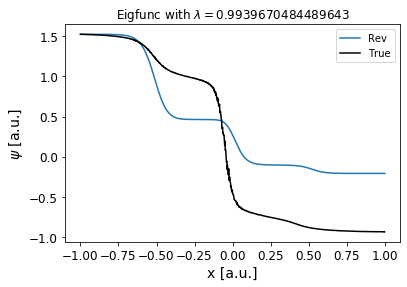

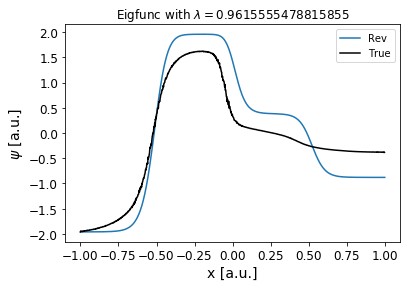

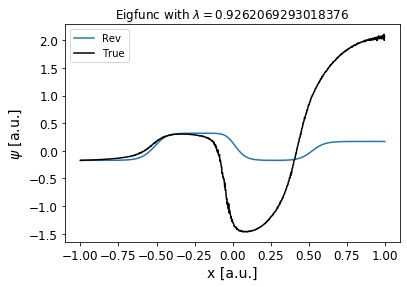

In [578]:
K_rev_msm = model_K_all_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])[0]
eigvals_rev, eigvec_rev = np.linalg.eig(K_rev_msm)
print(eigvals_rev)
sort_ind = np.argsort(eigvals_rev)[::-1]
# sort_ind = [2,1,3,0]
eigvals_rev = eigvals_rev[sort_ind]
eigvec_rev = eigvec_rev[:,sort_ind]

pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
eigfunc_rev_msm = pred_xax @ eigvec_rev
for i in range(1,output_size):
    plt.title('Eigfunc with $\lambda={}$'.format(true_eigvals[i]))
    fac = true_eigfunc[0,i] / eigfunc_rev_msm[0,i]
    plt.plot(xax, fac*eigfunc_rev_msm[:,i], label='Rev')
    plt.plot(xax[::10], true_eigfunc[:,i], 'k', label='True')
    plt.legend()
    plt.xlabel('x [a.u.]', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('$\psi$ [a.u.]', fontsize=14)
    plt.show()

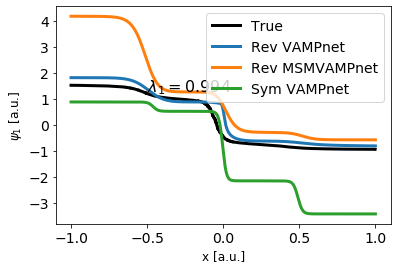

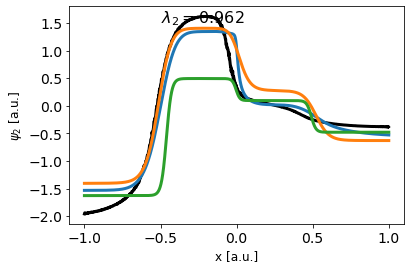

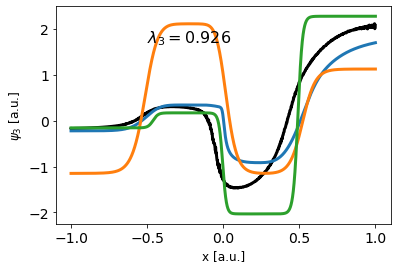

In [579]:
y=[1.3,1.5,1.7]
fontsize2 = 14
fontsize1 = 12
for i in range(1,output_size):
#     plt.title('$\lambda_{}={:.3}$'.format(i,eigvals_true[i]), fontsize=14)
    index_al = np.argmax(np.abs(true_eigfunc[:,i]))
    plt.text(-.5,y[i-1],'$\lambda_{}={:.3}$'.format(i,true_eigvals[i]), fontsize=fontsize2+2)
    plt.plot(xax[::10], true_eigfunc[:,i], 'k', lw=3, label='True')
    fac = true_eigfunc[index_al,i] / eigfunc_rev[index_al,i]
    fac1 = true_eigfunc[0,i] / eigfunc_rev[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_rev[-1,i]
    fac = (fac1 + fac2)/2
#     fac = fac2
#     if np.abs(eigfunc_rev[0,i]) > np.abs(eigfunc_rev[-1,i]):
#         fac = fac1
#     else:
#         fac = fac2
#     fac = np.sign(fac)*np.abs(fac1*fac2/np.sqrt(fac1*fac2))
    plt.plot(xax, fac*eigfunc_rev[:,i], lw=3, label='Rev VAMPnet')
    
    
    index_al = np.argmax(np.abs(true_eigfunc[:,i]))
    fac = true_eigfunc[index_al,i] / eigfunc_rev_msm[index_al,i]
    fac1 = true_eigfunc[0,i] / eigfunc_rev_msm[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_rev_msm[-1,i]
    fac = (fac1 + fac2)/2
#     fac = fac2
#     if np.abs(eigfunc_rev_msm[0,i]) > np.abs(eigfunc_rev_msm[-1,i]):
#         fac = fac1
#     else:
#         fac = fac2
#     fac = np.sign(fac)*np.abs(fac1*fac2/np.sqrt(fac1*fac2))
    plt.plot(xax, fac*eigfunc_rev_msm[:,i], lw=3, label='Rev MSMVAMPnet')
    
    index_al = np.argmax(np.abs(true_eigfunc[:,i]))
    fac = true_eigfunc[index_al,i] / eigfunc_sym[index_al,i]
    fac1 = true_eigfunc[0,i] / eigfunc_sym[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_sym[-1,i]
    fac = (fac1 + fac2)/2
#     if np.abs(eigfunc_sym[0,i]) > np.abs(eigfunc_sym[-1,i]):
#         fac = fac1
#     else:
#         fac = fac2
    plt.plot(xax, fac*eigfunc_sym[:,i], lw=3, label='Sym VAMPnet')
    if i==1:
        plt.legend(fontsize=fontsize2)
    plt.xlabel('x [a.u.]', fontsize=fontsize1)
    plt.xticks([-1,-.5,0,.5,1], fontsize=fontsize2)
    plt.yticks(fontsize=fontsize2)
    plt.ylabel('$\psi_{}$ [a.u.]'.format(i), fontsize=fontsize1)
#     plt.savefig('./paper_figs/prinz_eigfunc_{}_low_data.pdf'.format(i), bbox_inches='tight')
    plt.show()

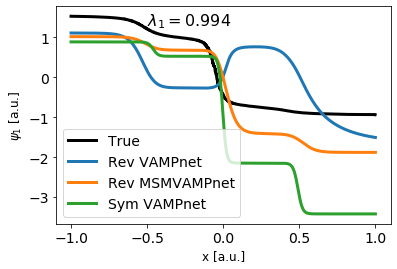

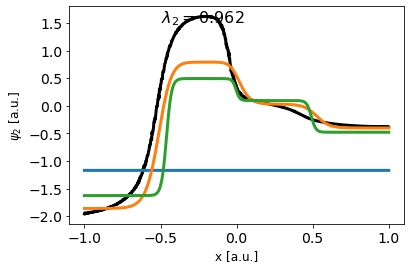

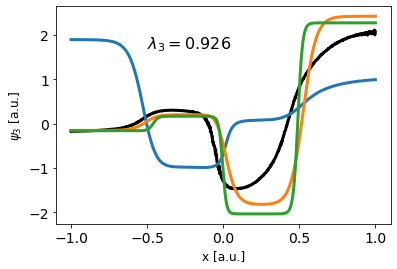

In [580]:
y=[1.3,1.5,1.7]
fontsize2 = 14
fontsize1 = 12
for i in range(1,output_size):
#     plt.title('$\lambda_{}={:.3}$'.format(i,eigvals_true[i]), fontsize=14)
    index_al = np.argmax(np.abs(true_eigfunc[:,i]))
    plt.text(-.5,y[i-1],'$\lambda_{}={:.3}$'.format(i,true_eigvals[i]), fontsize=fontsize2+2)
    plt.plot(xax[::10], true_eigfunc[:,i], 'k', lw=3, label='True')
    fac = true_eigfunc[index_al,i] / eigfunc_rev1[index_al,i]
    fac1 = true_eigfunc[0,i] / eigfunc_rev1[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_rev1[-1,i]
    fac = (fac1 + fac2)/2
#     fac = fac2
#     if np.abs(eigfunc_rev1[0,i]) > np.abs(eigfunc_rev1[-1,i]):
#         fac = fac1
#     else:
#         fac = fac2
#     fac = np.sign(fac)*np.abs(fac1*fac2/np.sqrt(fac1*fac2))
    plt.plot(xax, fac*eigfunc_rev1[:,i], lw=3, label='Rev VAMPnet')
    
    
    index_al = np.argmax(np.abs(true_eigfunc[:,i]))
    fac = true_eigfunc[index_al,i] / eigfunc_rev_msm1[index_al,i]
    fac1 = true_eigfunc[0,i] / eigfunc_rev_msm1[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_rev_msm1[-1,i]
    fac = (fac1 + fac2)/2
#     fac = fac2
#     if np.abs(eigfunc_rev_msm1[0,i]) > np.abs(eigfunc_rev_msm1[-1,i]):
#         fac = fac1
#     else:
#         fac = fac2
#     fac = np.sign(fac)*np.abs(fac1*fac2/np.sqrt(fac1*fac2))
    plt.plot(xax, fac*eigfunc_rev_msm1[:,i], lw=3, label='Rev MSMVAMPnet')
    
    index_al = np.argmax(np.abs(true_eigfunc[:,i]))
    fac = true_eigfunc[index_al,i] / eigfunc_sym[index_al,i]
    fac1 = true_eigfunc[0,i] / eigfunc_sym[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_sym[-1,i]
    fac = (fac1 + fac2)/2
#     if np.abs(eigfunc_sym[0,i]) > np.abs(eigfunc_sym[-1,i]):
#         fac = fac1
#     else:
#         fac = fac2
    plt.plot(xax, fac*eigfunc_sym[:,i], lw=3, label='Sym VAMPnet')
    if i==1:
        plt.legend(fontsize=fontsize2)
    plt.xlabel('x [a.u.]', fontsize=fontsize1)
    plt.xticks([-1,-.5,0,.5,1], fontsize=fontsize2)
    plt.yticks(fontsize=fontsize2)
    plt.ylabel('$\psi_{}$ [a.u.]'.format(i), fontsize=fontsize1)
#     plt.savefig('./paper_figs/prinz_eigfunc_{}_low_data.pdf'.format(i), bbox_inches='tight')
    plt.show()

In [848]:
def training_for_tau_both(new_tau):

    traj_data_train = np.concatenate([traj[:-new_tau] for traj in training_trajs])
    traj_data_train_lag = np.concatenate([traj[new_tau:] for traj in training_trajs])

    traj_data_valid = np.concatenate([traj[:-new_tau] for traj in validation_trajs])
    traj_data_valid_lag = np.concatenate([traj[new_tau:] for traj in validation_trajs])

    # Input of the first network
    X1_train = traj_data_train.astype('float32')
    X2_train  = traj_data_train_lag.astype('float32')

    X1_vali = traj_data_valid.astype('float32')
    X2_vali  = traj_data_valid_lag.astype('float32')

    Y_train = np.zeros((X1_train.shape[0], output_size))
    Y_vali = np.zeros((X1_vali.shape[0], output_size))
    
    vamp_layer_u.trainable = True
    reset_weights(vamp_layer_S.variables[0])
    estimate_S_with_vampnets(factor_S, X1_train, X2_train)
    
    
    model_S_vampE = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = VampE_matrix_S)
    adam = keras.optimizers.Adam(learning_rate=learning_rate*1000, )
    model_S_vampE.compile(adam,
                     trace_vampe,
                 )

    model_K_S = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = K_S)

    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    Data_chi_vali = model_chi.predict([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])
    Data_chi_X_vali = Data_chi_vali[:,:output_size]
    Data_chi_Y_vali = Data_chi_vali[:,output_size:]

    v_input, C_00_input, C_11_input, C_01_input, Sigma_input = model_input_S.predict([Data_chi_X, Data_chi_Y], batch_size=Data_chi_X.shape[0])
    v_input_vali, C_00_input_vali, C_11_input_vali, C_01_input_vali, Sigma_input_vali = model_input_S.predict([Data_chi_X_vali, Data_chi_Y_vali], batch_size=Data_chi_X_vali.shape[0])

    hist = model_S_vampE.fit([v_input[0][None], C_00_input[0][None], C_11_input[0][None], C_01_input[0][None], Sigma_input[0][None]], np.zeros_like(v_input[0][None]) ,
                 batch_size=v_input[0][None].shape[0],
                 epochs = epoch_Su,
                 validation_data=([v_input_vali[0][None], C_00_input_vali[0][None], C_11_input_vali[0][None], C_01_input_vali[0][None], Sigma_input_vali[0][None]], np.zeros_like(v_input_vali[0][None])),
                 verbose=0,
                 callbacks=callbacks,
                 shuffle=True)

    adam = keras.optimizers.Adam(learning_rate=learning_rate*2, clipnorm=1.)
#     reset_weights(vamp_layer_u.variables[0])
    model_both_vampE.compile(adam,
                     trace_vampe,
                     )
    model_K_both = keras.models.Model(inputs = [Data_chi_t_keras, Data_chi_tau_keras], outputs = K_both)
    hist = model_both_vampE.fit([Data_chi_X, Data_chi_Y], Y_train,
                 batch_size=Data_chi_X.shape[0],
                 epochs=epoch_all,
                 validation_data=([Data_chi_X_vali, Data_chi_Y_vali], Y_vali ),
                 verbose=0,
                 callbacks = [EarlyStopping('val_loss', patience=500, mode='min', restore_best_weights=True)],
                 shuffle=True)


    K_result = model_K_all.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])

    return K_result[0]

1


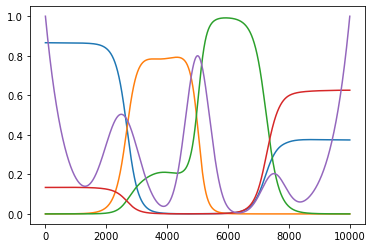

[[ 9.7862524e-01  2.1398928e-02  3.8721986e-04 -4.1172517e-04]
 [ 1.3393940e-02  9.6733129e-01  2.4012756e-02 -4.7376454e-03]
 [ 1.7150400e-02  5.0089476e-03  9.4974500e-01  2.8094780e-02]
 [ 3.7610207e-03 -1.3803495e-02  2.4640633e-02  9.8540199e-01]] [0.9317234  0.9565348  0.99999976 0.99284554]
[[ 0.97714704  0.02273849  0.00272635 -0.00286965]
 [ 0.01097451  0.9676073   0.02876482 -0.00736643]
 [ 0.01752787  0.00405177  0.9495047   0.02918602]
 [ 0.0048875  -0.01423708  0.02253659  0.986845  ]]
[[ 0.9772525   0.02273956  0.00273979 -0.00273323]
 [ 0.01097502  0.9676216   0.02876961 -0.00736634]
 [ 0.01750998  0.00403848  0.949291    0.02916053]
 [ 0.00487661 -0.0142371   0.02253506  0.9868274 ]]
[0.9314658 0.9565311 1.0000004 0.9929951]
2


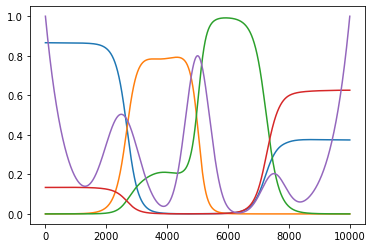

[[ 0.9590261   0.04338116 -0.00510574  0.00269901]
 [ 0.02707211  0.9382461   0.04787864 -0.0131965 ]
 [ 0.04242606 -0.0018086   0.8877972   0.07158478]
 [-0.00531944 -0.02596434  0.08407528  0.94720805]] [0.83690983 0.9074812  0.99999976 0.98788667]
[[ 9.5917404e-01  4.6559211e-02 -7.6724333e-04  2.7291775e-03]
 [ 2.0262657e-02  9.3696707e-01  2.7706005e-02 -2.0452682e-02]
 [ 5.2570365e-02  1.6993552e-03  8.9045781e-01  8.8303968e-02]
 [-6.4092036e-03 -2.8050106e-02  6.9359675e-02  9.4567883e-01]]
[[ 9.5601320e-01  4.6527233e-02 -1.1817813e-03 -1.3594627e-03]
 [ 2.1222226e-02  9.6272272e-01  3.6332097e-02 -2.0277567e-02]
 [ 5.0318308e-02  1.3756778e-04  8.6446303e-01  8.5081071e-02]
 [ 6.6423416e-04 -2.8040010e-02  7.0385963e-02  9.5699024e-01]]
[0.82054156 0.92052215 0.99999994 0.99912554]
3


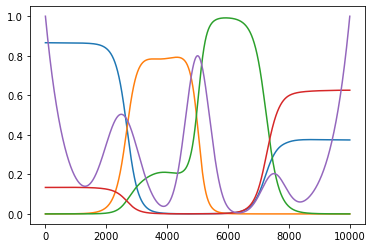

[[ 0.94448686  0.06032801 -0.00992487  0.00510937]
 [ 0.03910818  0.90615946  0.07501724 -0.02028462]
 [ 0.06509171  0.00138139  0.8241902   0.10933658]
 [-0.01278917 -0.03586738  0.13191009  0.9167479 ]] [0.7444441  0.86638916 1.0000004  0.9807508 ]
[[ 0.94783854  0.06566377 -0.00153151  0.01010742]
 [ 0.029209    0.90493554  0.0560455  -0.03008507]
 [ 0.08120372  0.00447251  0.8276518   0.13620518]
 [-0.01695398 -0.03941438  0.10736279  0.9111583 ]]
[[ 0.93878984  0.06557302 -0.00273734 -0.00162315]
 [ 0.03031836  0.93378216  0.06578295 -0.02988347]
 [ 0.07777545  0.00220772  0.7887231   0.13129357]
 [-0.0031817  -0.03939502  0.10939083  0.9331856 ]]
[0.7207206  0.8812087  1.0000005  0.99255085]
4


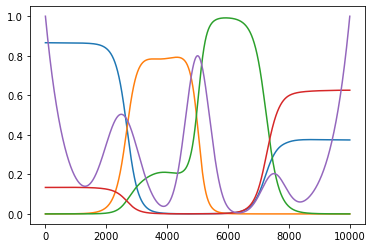

[[ 9.2130327e-01  8.3484590e-02 -9.6258903e-03  4.8389402e-03]
 [ 5.3730372e-02  8.7493968e-01  9.4978012e-02 -2.3648413e-02]
 [ 7.9201125e-02 -2.2990452e-04  7.8644222e-01  1.3458651e-01]
 [-8.5642207e-03 -5.0329331e-02  1.6086712e-01  8.9802611e-01]] [0.6874894 0.8198031 1.0000001 0.9734187]
[[ 0.9284826   0.08647402 -0.003529    0.01609762]
 [ 0.04224925  0.8731013   0.06287776 -0.03819885]
 [ 0.09865928  0.00488237  0.79121274  0.16622221]
 [-0.01614089 -0.05227511  0.13403678  0.88791525]]
[[ 9.1721106e-01  8.6362548e-02 -5.1065683e-03  1.5358925e-03]
 [ 4.3945789e-02  9.1637897e-01  7.7565566e-02 -3.7890509e-02]
 [ 9.4290860e-02  2.2101342e-03  7.4354720e-01  1.5995178e-01]
 [ 7.2455406e-04 -5.2251644e-02  1.3665947e-01  9.1486526e-01]]
[0.6588875  0.8416257  0.9999998  0.99148947]
6


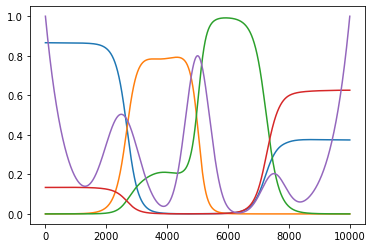

[[ 8.7581158e-01  1.2919548e-01 -9.6829189e-03  4.6766619e-03]
 [ 8.1183657e-02  8.2113785e-01  1.2551108e-01 -2.7833227e-02]
 [ 1.0889355e-01  1.6302853e-04  7.0724511e-01  1.8369931e-01]
 [-3.3786064e-03 -7.6723032e-02  2.2325867e-01  8.5684264e-01]] [0.56846523 0.7337936  1.0000004  0.95877796]
[[ 8.89427900e-01  1.24872416e-01 -4.24965547e-05  2.65581515e-02]
 [ 7.40953535e-02  8.19169462e-01  8.53585824e-02 -4.48560379e-02]
 [ 1.38036937e-01  6.33149082e-03  7.14137554e-01  2.31761977e-01]
 [-1.71379913e-02 -7.46692121e-02  1.82363883e-01  8.38301063e-01]]
[[ 0.8727162   0.12471379 -0.00244361  0.00501442]
 [ 0.07599801  0.86675215  0.10176136 -0.04451144]
 [ 0.131356    0.00252619  0.6440133   0.22210446]
 [ 0.00864673 -0.07463483  0.18651804  0.8794699 ]]
[0.5268324 0.7564393 1.0000001 0.9796796]
8


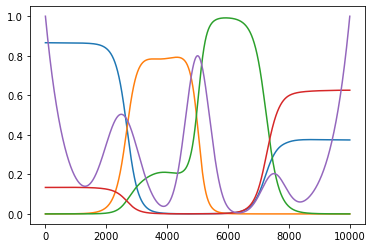

[[ 0.8122324   0.19447355 -0.01176683  0.00506118]
 [ 0.11404151  0.7492827   0.17092748 -0.0342514 ]
 [ 0.14280662  0.01968277  0.58823234  0.24927802]
 [-0.00176128 -0.11997557  0.3330128   0.788725  ]] [0.37500766 0.6262349  1.0000004  0.9372296 ]
[[ 0.8349853   0.17305934 -0.0214802   0.04269521]
 [ 0.10558046  0.75093174  0.18422347 -0.07729502]
 [ 0.19958088  0.01730168  0.59665406  0.3387227 ]
 [-0.02580768 -0.10528413  0.2756923   0.7559006 ]]
[[ 0.82300997  0.17294784 -0.02323079  0.02726984]
 [ 0.1066727   0.77686125  0.19356507 -0.07709926]
 [ 0.18804654  0.01101839  0.47900137  0.32193372]
 [ 0.01022434 -0.10523746  0.28164443  0.8133707 ]]
[0.3052565  0.63540965 0.99999994 0.95157725]
10


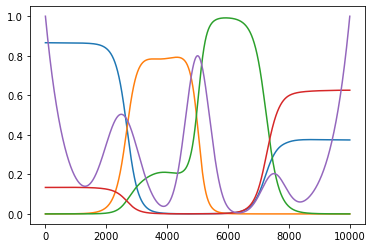

[[ 0.7582784   0.23857218  0.01074291 -0.007594  ]
 [ 0.13407066  0.708096    0.18897048 -0.03113721]
 [ 0.16805823  0.03571289  0.510284    0.2859448 ]
 [ 0.04036398 -0.14070034  0.28609928  0.8142368 ]] [0.31576985 0.5574309  0.99999976 0.91769475]
[[ 0.7790764   0.20335971 -0.00335853  0.02785398]
 [ 0.17400272  0.71220165  0.25081626 -0.01819569]
 [ 0.21063042  0.0267183   0.5141988   0.35300535]
 [ 0.01970588 -0.12110875  0.25237155  0.7854184 ]]
[[ 0.7762568   0.20333557 -0.00375134  0.02415943]
 [ 0.1702584   0.62457794  0.22402614 -0.01886225]
 [ 0.2021958   0.02300932  0.43433428  0.34046072]
 [ 0.04277229 -0.12108192  0.25601885  0.82229066]]
[0.26301914 0.5034887  1.0000001  0.8909517 ]


In [849]:
K_results_rev = np.ones((number_taus, output_size, output_size))
K_results = np.ones_like(K_results_rev)
for i, tau_i in enumerate(tau_list):
    print(tau_i)
    K_results_rev[i]= training_for_tau_both(tau_i)
    K_results[i]  = estimate_koopman_op(pred_ord_chi, tau_i, force_symmetric = True)

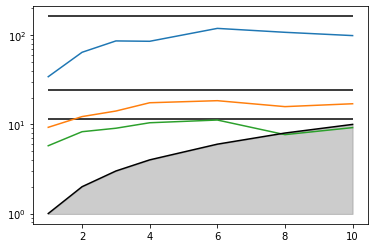

In [850]:
# timescale_real_values = np.array([12.72682393,  25.03881868, 176.48122152])
timescale_real_values = np.array([ 11.53593249,  24.48666445, 163.41165771])
for tsrv in timescale_real_values:
    plt.hlines(tsrv, tau_list[0], tau_list[-1])
vamp.plot_its(get_its(K_results_rev, tau_list, False), tau_list)

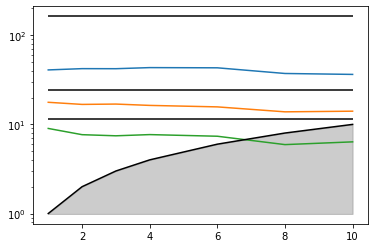

In [851]:
for tsrv in timescale_real_values:
    plt.hlines(tsrv, tau_list[0], tau_list[-1])
vamp.plot_its(get_its(K_results, tau_list, False), tau_list)

In [852]:
K_revs_all[number_i, bt_run] = K_results_rev
K_syms_all[number_i, bt_run] = K_results

In [853]:
# np.savez('./mu_its_compare_new31',
#         result_mu_rev = result_mu_rev,
#         result_mu_sym = result_mu_sym,
#         scaled_prinz_stat=scaled_prinz_stat,
#         real_its = timescale_real_values,
#         K_revs_all=K_revs_all,
#         K_syms_all=K_syms_all
#         )